In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# start: a
# kai_tak: b1
# sung_wong_tai: b2

margin_meters = 20
voxel_edge_length_meters = 5
number_of_paths_to_generate = 10
zero_ratio = 0.25
step_length_meters = 100
triangle_floor_half_length_meters = 20
triangle_floor_interval_length_meters = 5
assert triangle_floor_half_length_meters % triangle_floor_interval_length_meters == 0
maximum_number_of_descendants_per_node = 2 * int(triangle_floor_half_length_meters / triangle_floor_interval_length_meters) + 1

# meters
a_x_meters = 838825
a_y_meters = 819800
# b1_z_meters = 0

b1_x_meters = 838545
b1_y_meters = 821225
# b1_z_meters = 0 # -20

b2_x_meters = 837775
b2_y_meters = 820755
# tunnel_end_sung_wong_tai_z_meters = 0 # -20

current_b_x_meters = b1_x_meters
current_b_y_meters = b1_y_meters
# current_b_z_meters = b

voxel_grid_smallest_x_meters = min(a_x_meters, b1_x_meters, b2_x_meters) - margin_meters
voxel_grid_smallest_y_meters = min(a_y_meters, b1_y_meters, b2_y_meters) - margin_meters
# voxel_grid_smallest_z_meters = 0 # -50

voxel_grid_largest_x_meters = max(a_x_meters, b1_x_meters, b2_x_meters) + margin_meters
voxel_grid_largest_y_meters = max(a_y_meters, b1_y_meters, b2_y_meters) + margin_meters
# voxel_grid_largest_z_meters = 0

# coordinates
a_x_voxel_coordinate = a_x_meters // voxel_edge_length_meters
a_y_voxel_coordinate = a_y_meters // voxel_edge_length_meters
# tunnel_start_z_voxel_coordinate = tunnel_start_z_meters // voxel_edge_length_meters

b1_x_voxel_coordinate = b1_x_meters // voxel_edge_length_meters
b1_y_voxel_coordinate = b1_y_meters // voxel_edge_length_meters
# tunnel_end_kai_tak_z_voxel_coordinate = tunnel_end_kai_tak_z_meters // voxel_edge_length_meters

b2_x_voxel_coordinate = b2_x_meters // voxel_edge_length_meters
b2_y_voxel_coordinate = b2_y_meters // voxel_edge_length_meters
# tunnel_end_sung_wong_tai_z_voxel_coordinate = tunnel_end_sung_wong_tai_z_meters // voxel_edge_length_meters

voxel_grid_smallest_x_voxel_coordinate = voxel_grid_smallest_x_meters // voxel_edge_length_meters
voxel_grid_smallest_y_voxel_coordinate = voxel_grid_smallest_y_meters // voxel_edge_length_meters
# voxel_grid_smallest_z_voxel_coordinate = voxel_grid_smallest_z_meters // voxel_edge_length_meters

voxel_grid_largest_x_voxel_coordinate = voxel_grid_largest_x_meters // voxel_edge_length_meters
voxel_grid_largest_y_voxel_coordinate = voxel_grid_largest_y_meters // voxel_edge_length_meters
# voxel_grid_largest_z_voxel_coordinate = voxel_grid_largest_z_meters // voxel_edge_length_meters

# generate values uniformly random between 0 and 1
data = np.random.uniform(low=0.0, high=1.0, size=(voxel_grid_largest_x_voxel_coordinate-voxel_grid_smallest_x_voxel_coordinate, voxel_grid_largest_y_voxel_coordinate-voxel_grid_smallest_y_voxel_coordinate))
random_zero_indices = np.random.choice(np.arange(data.size), replace=False,
                                       size=int(data.size * zero_ratio))
data[np.unravel_index(random_zero_indices, data.shape)] = 0

data = xr.DataArray(
    data=data,
    dims=("x", "y"),
    coords={
        "x": range(voxel_grid_smallest_x_voxel_coordinate, voxel_grid_largest_x_voxel_coordinate),
        "y": range(voxel_grid_smallest_y_voxel_coordinate, voxel_grid_largest_y_voxel_coordinate),
        # "z": range(voxel_grid_smallest_z_voxel_coordinate, voxel_grid_largest_z_voxel_coordinate),
    },
)


/var/folders/q5/tb_fb5l57nb_8z19g54gr3900000gn/T/ipykernel_43293/2328080881.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 6))


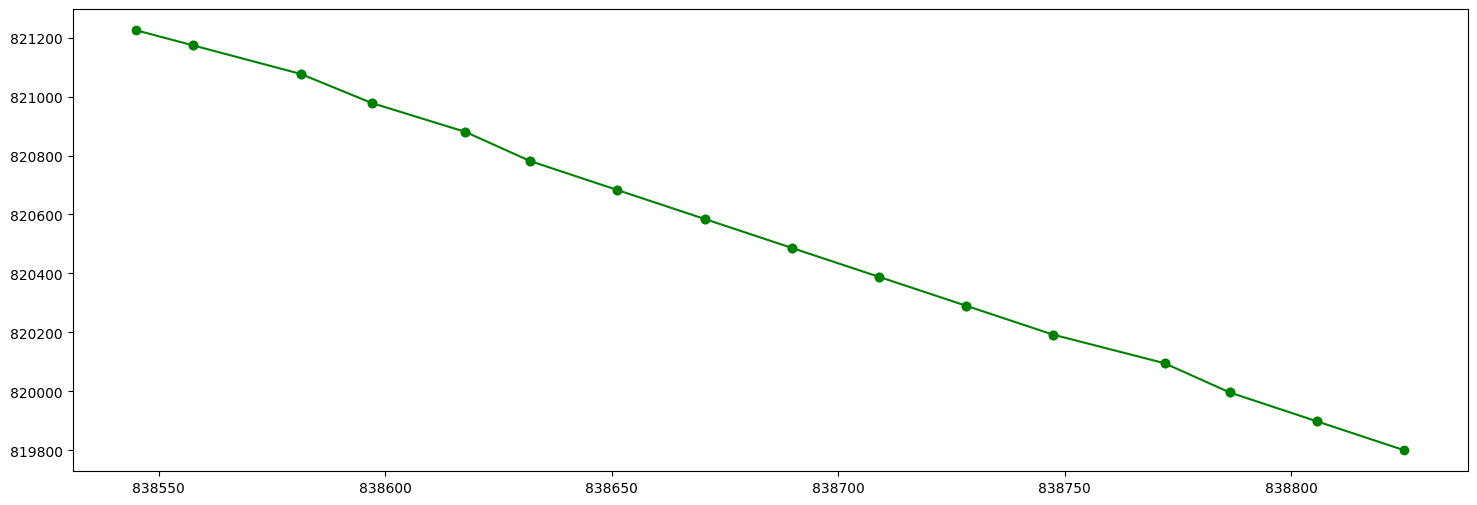

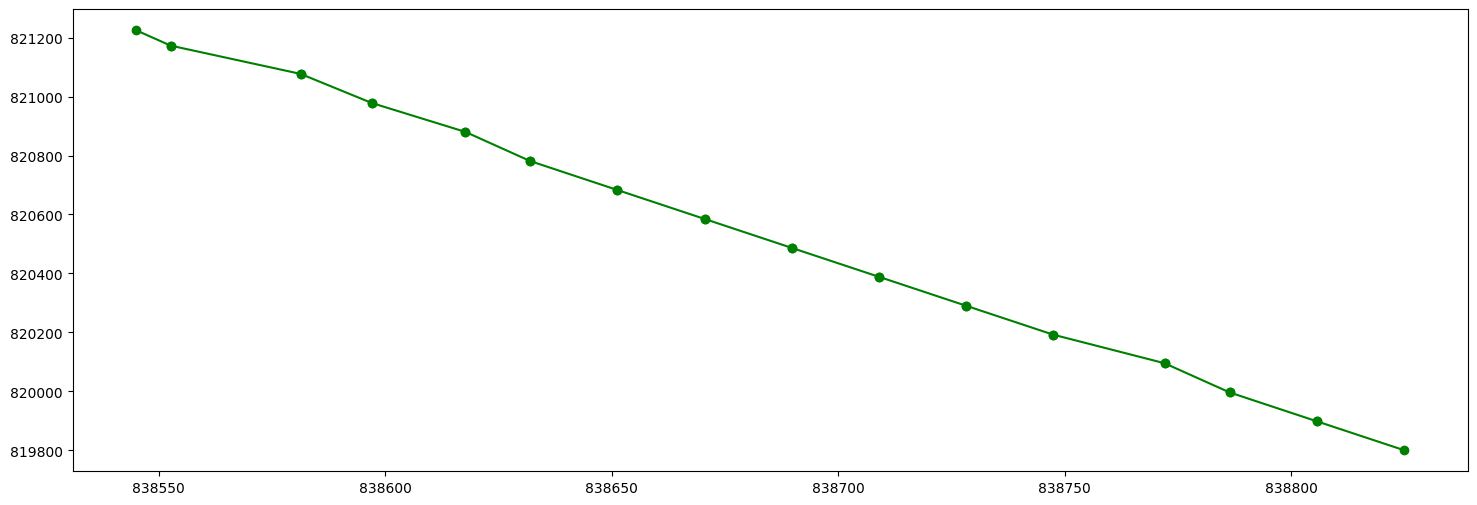

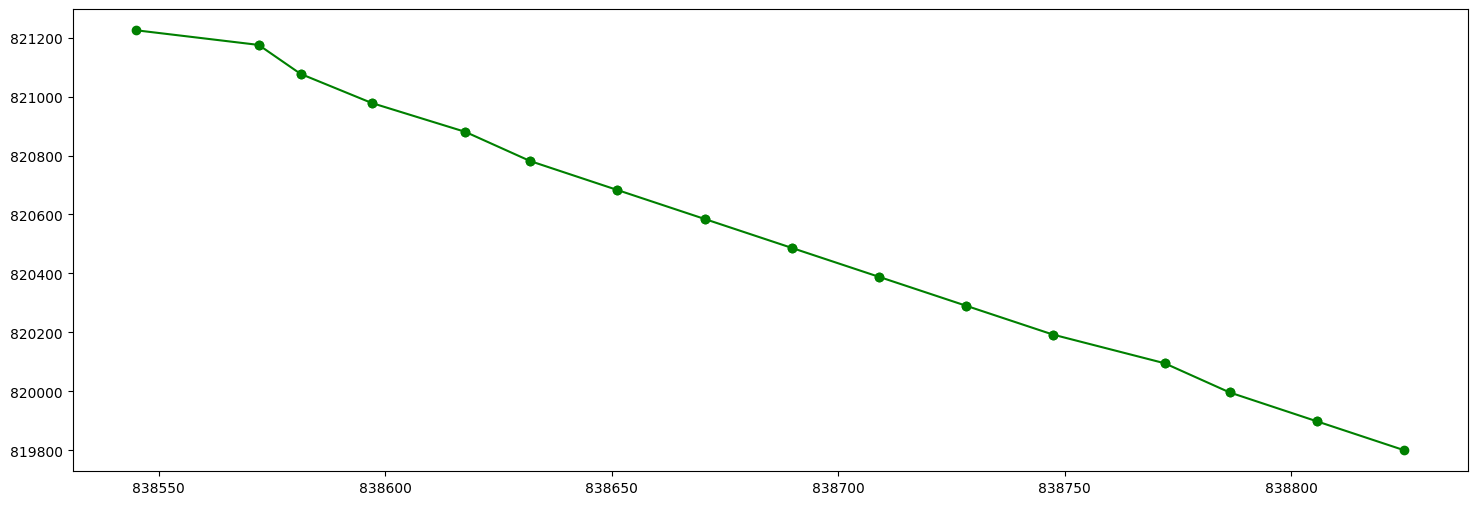

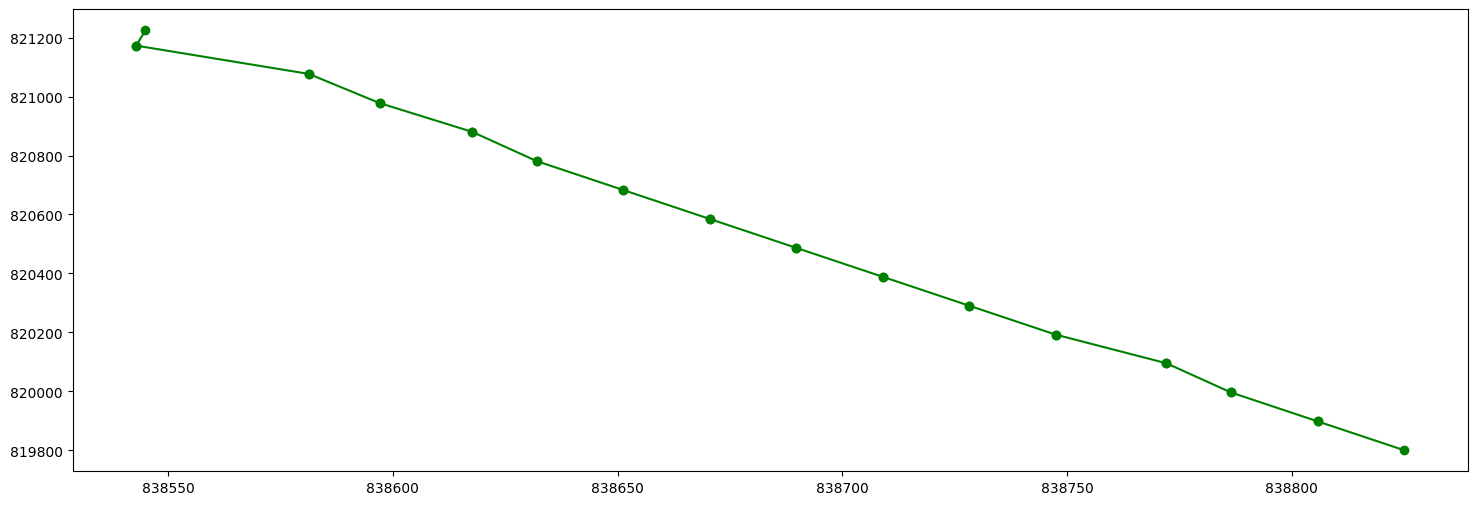

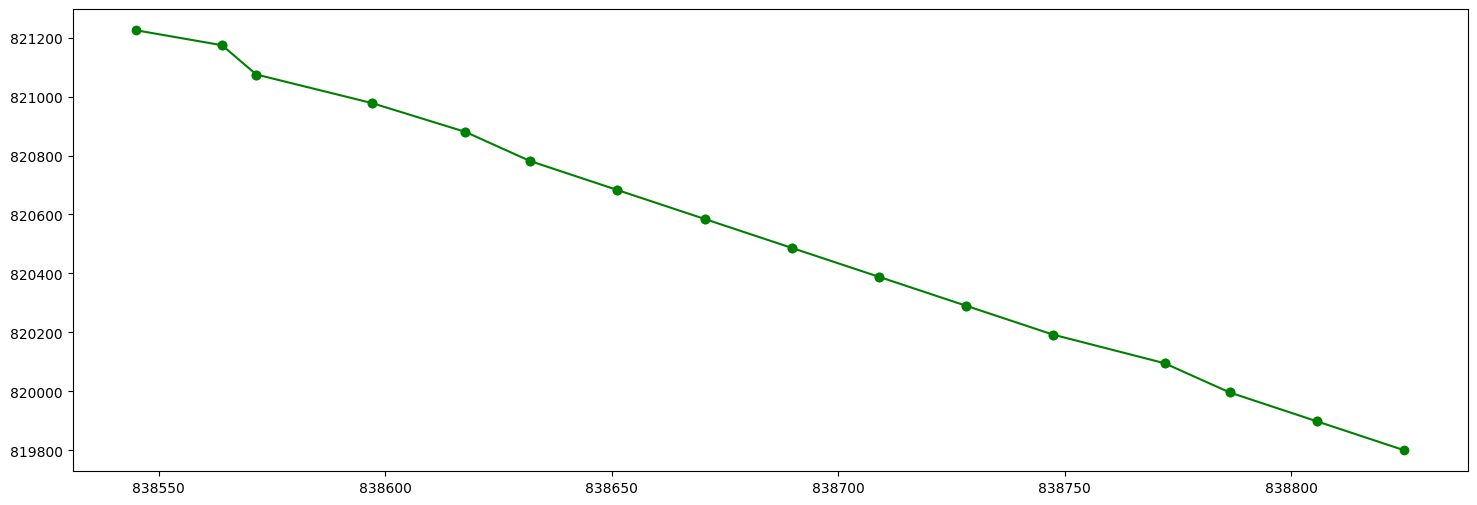

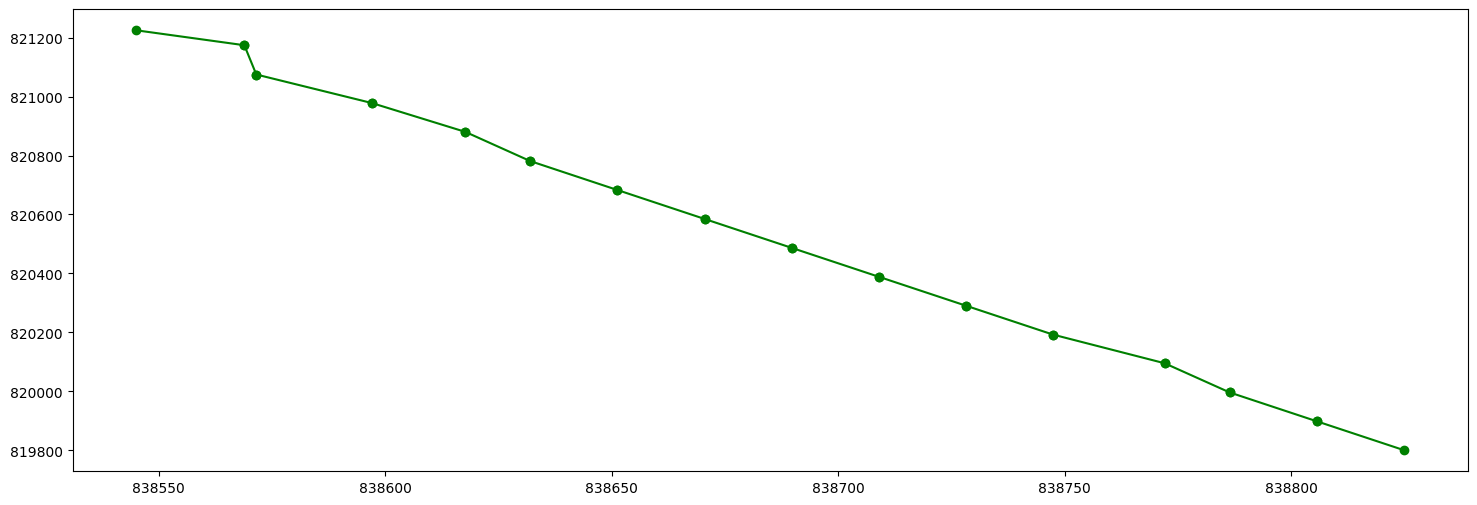

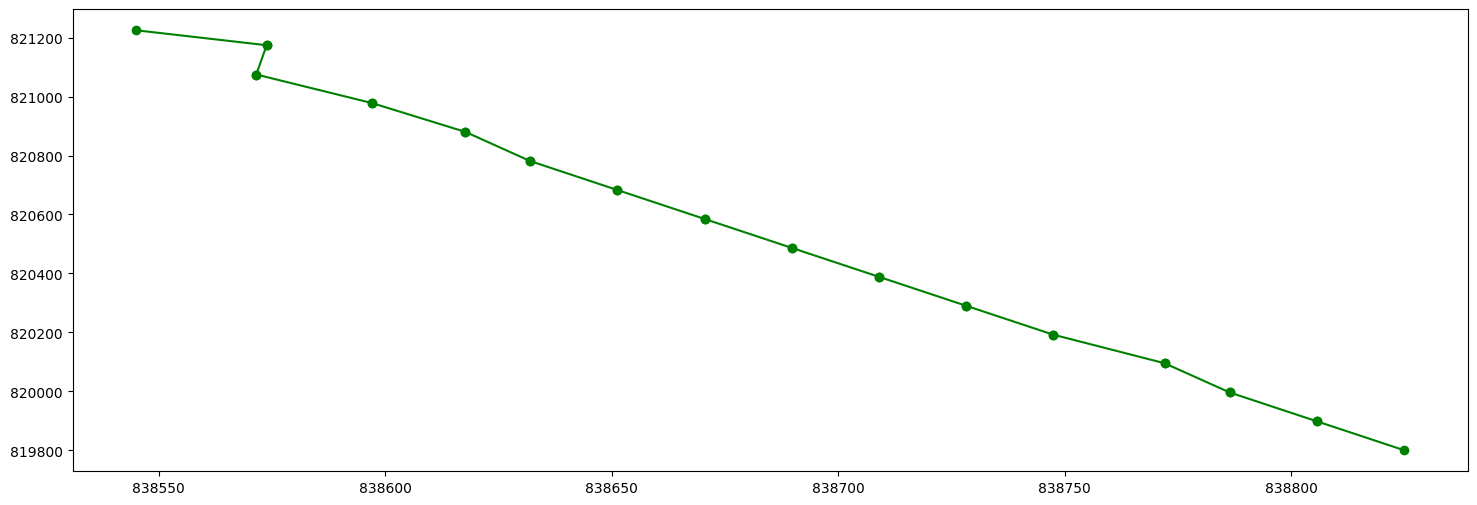

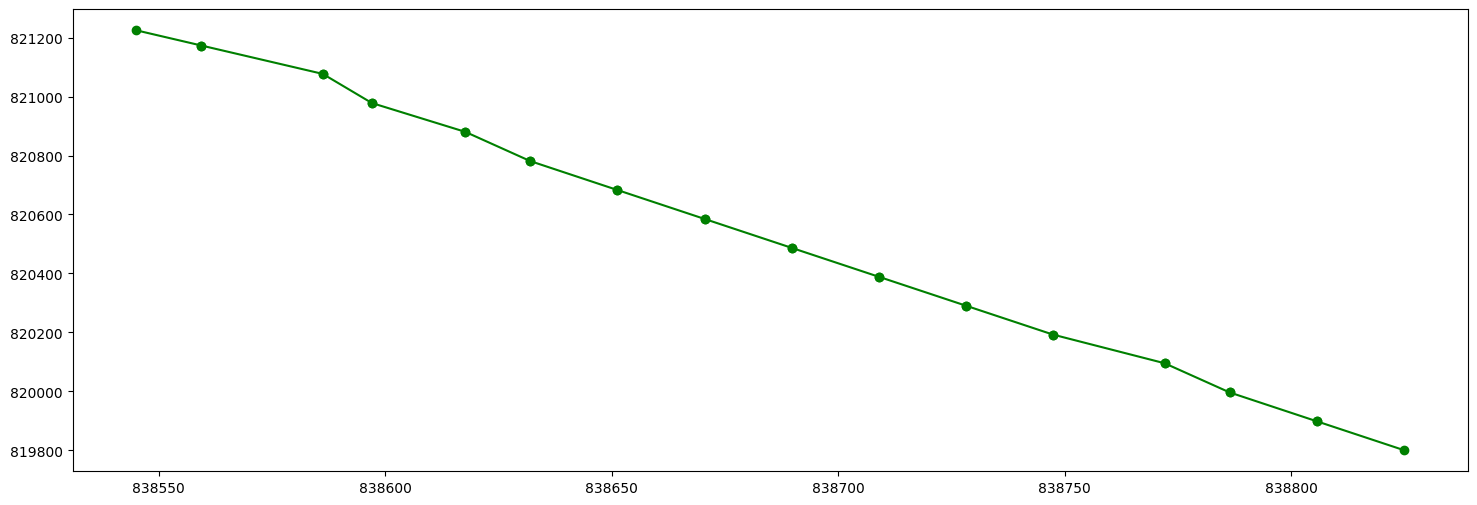

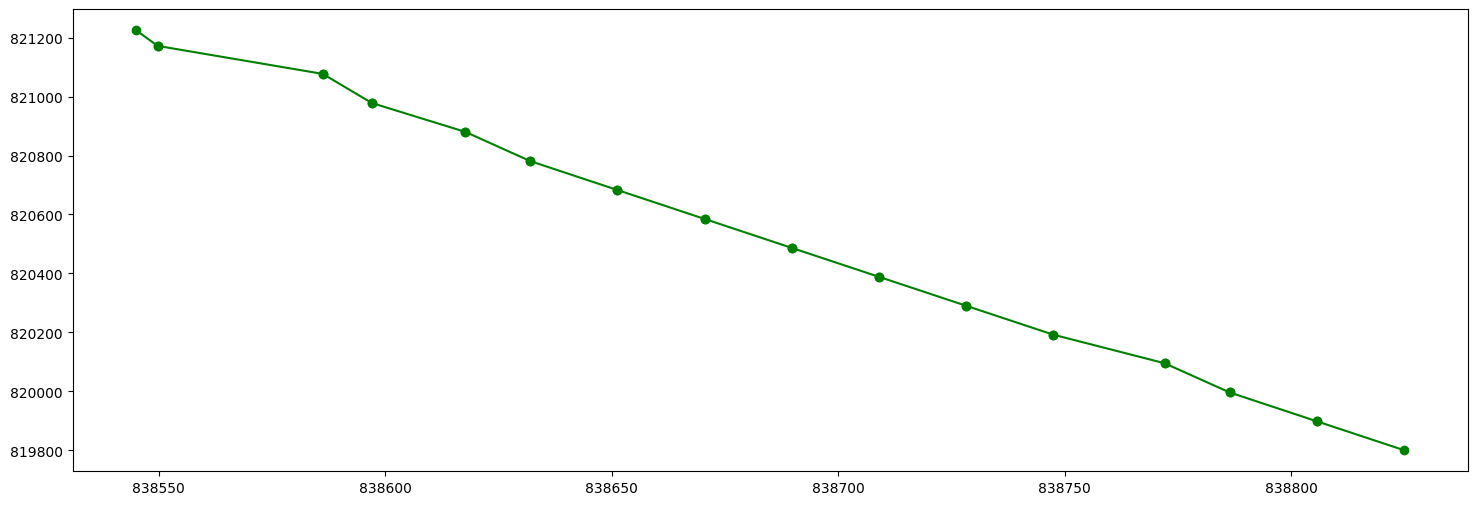

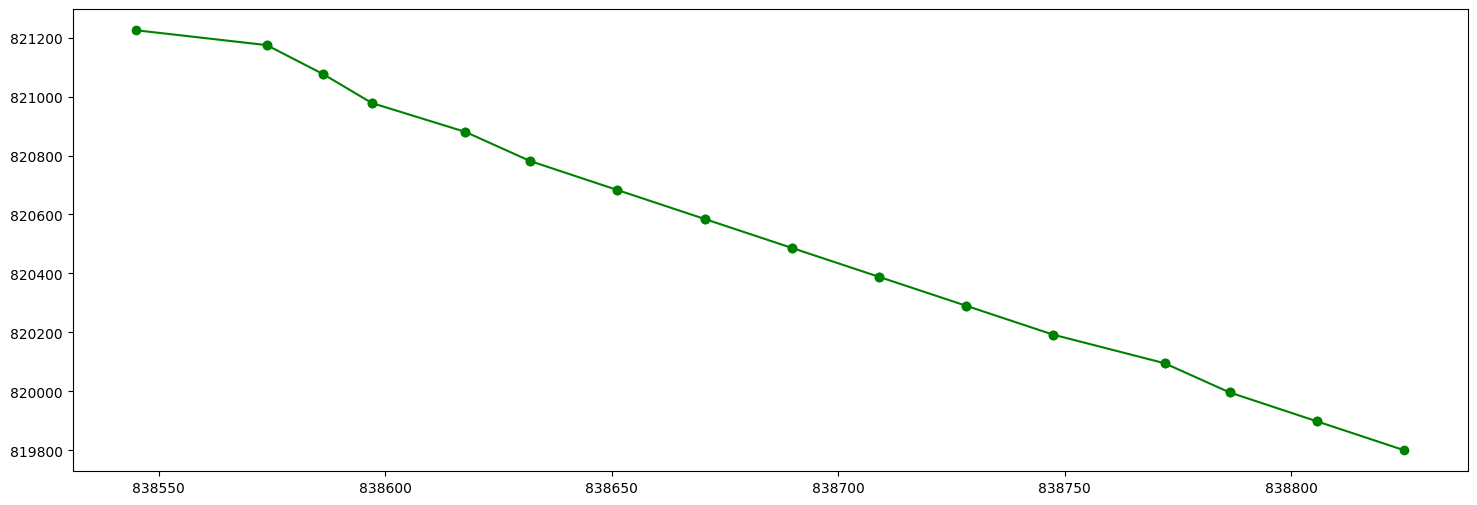

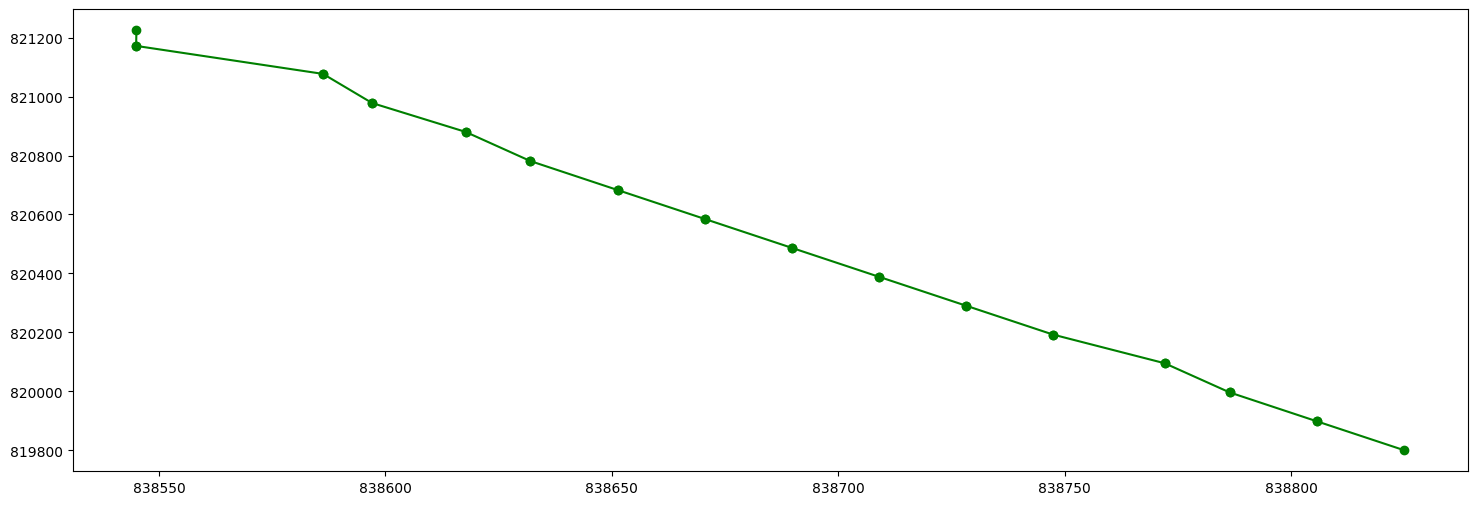

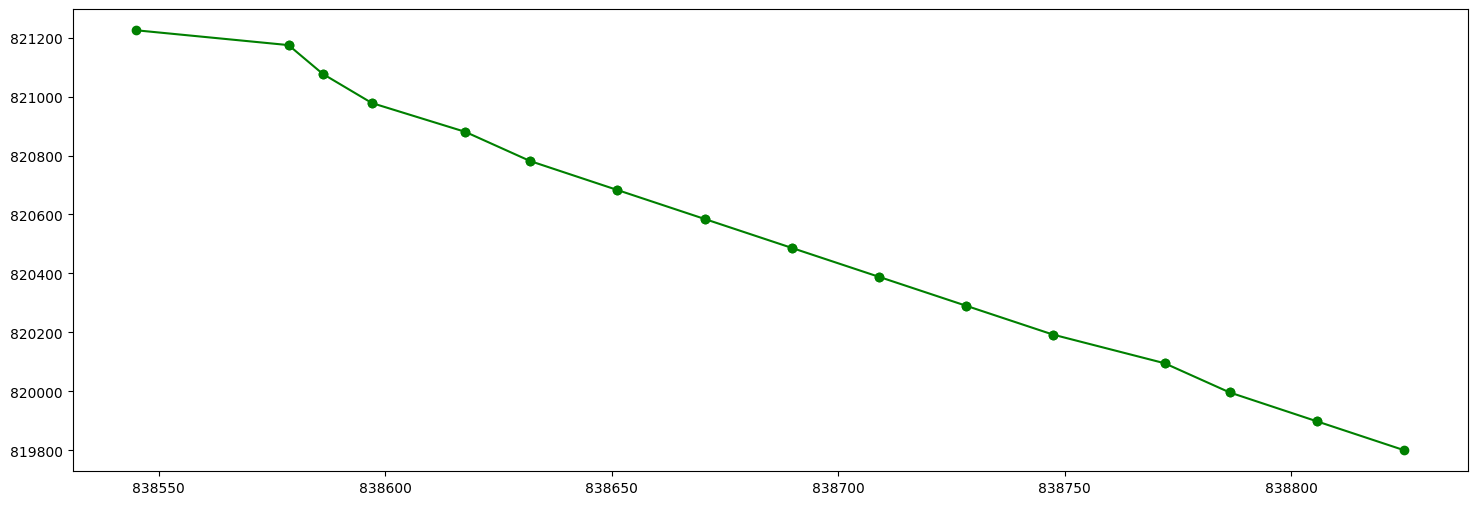

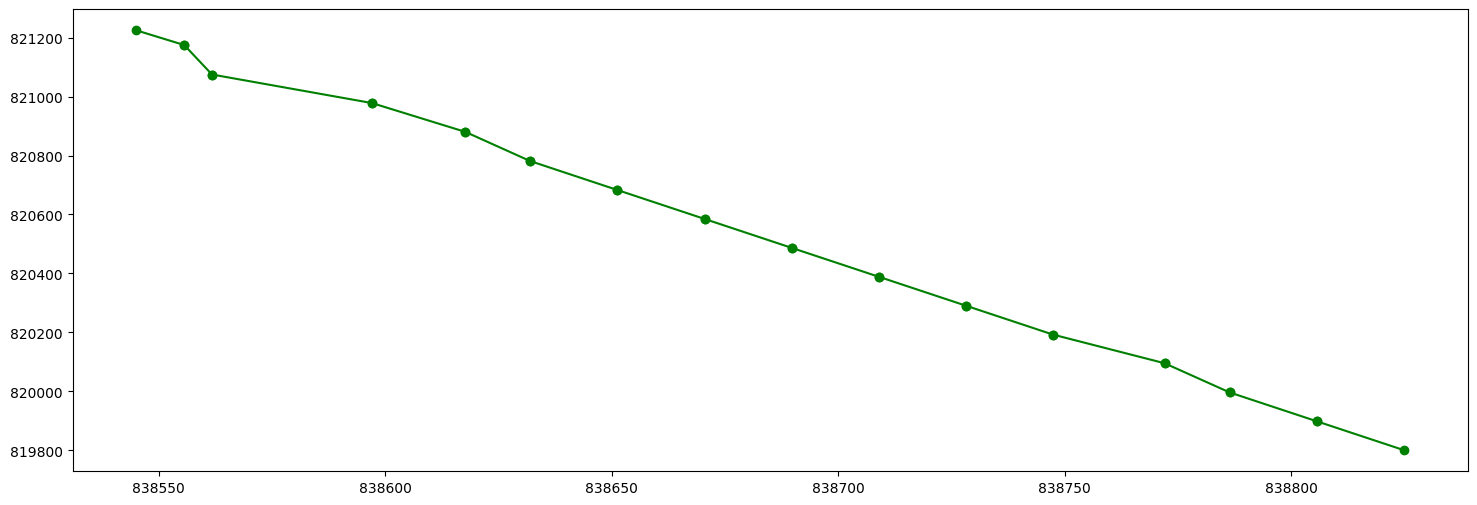

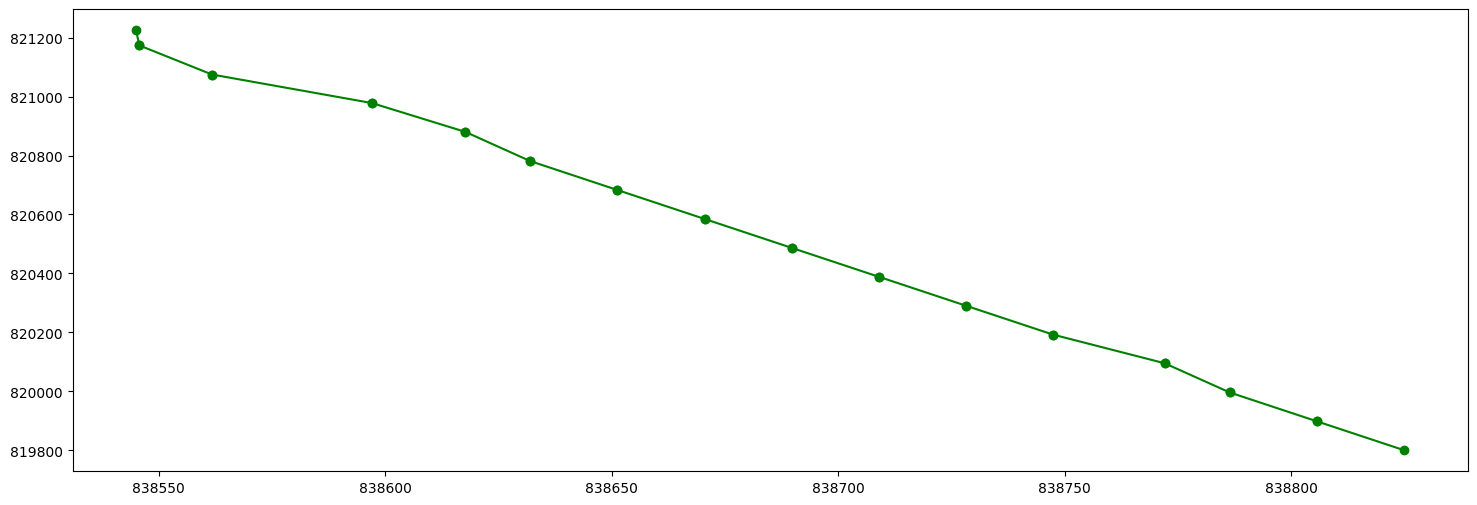

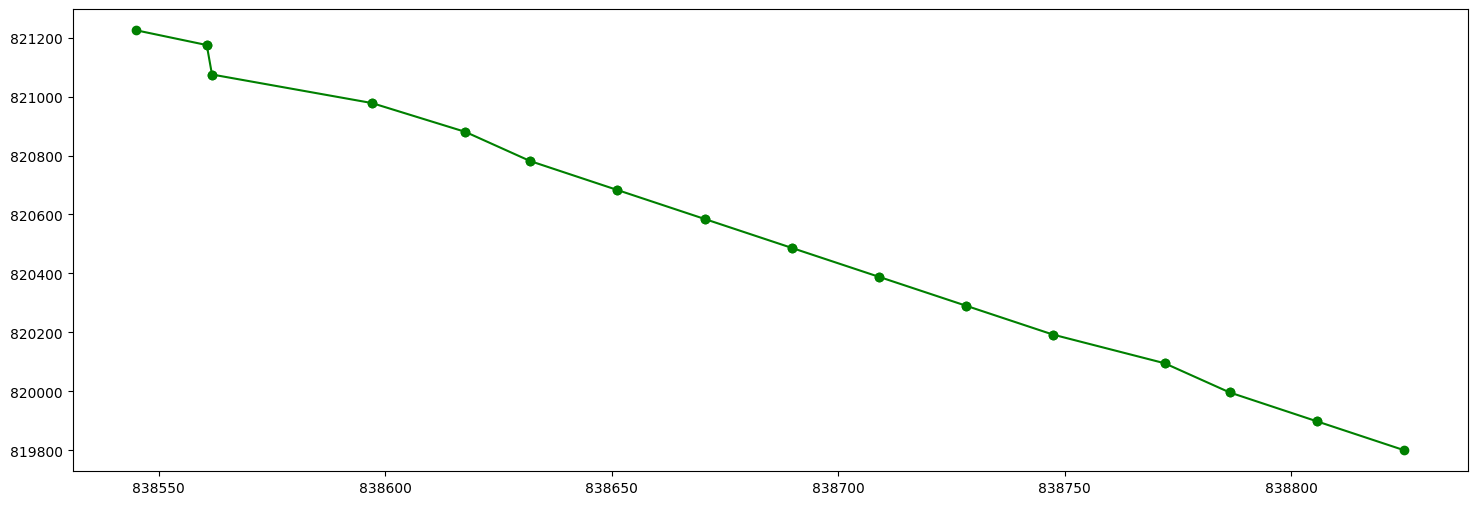

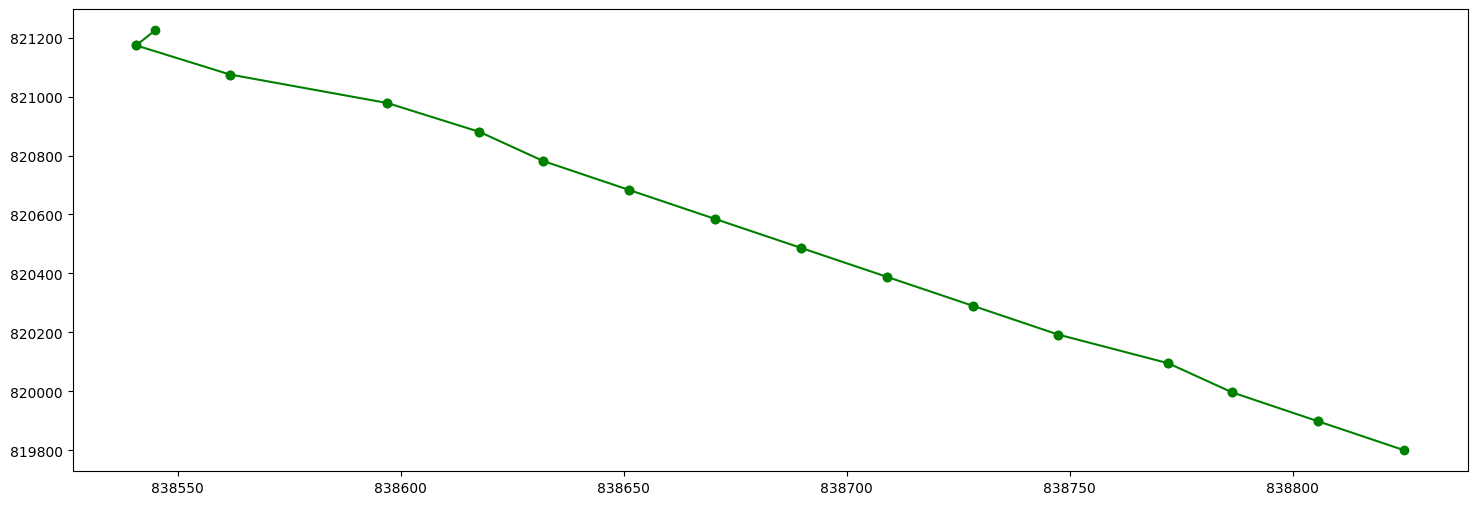

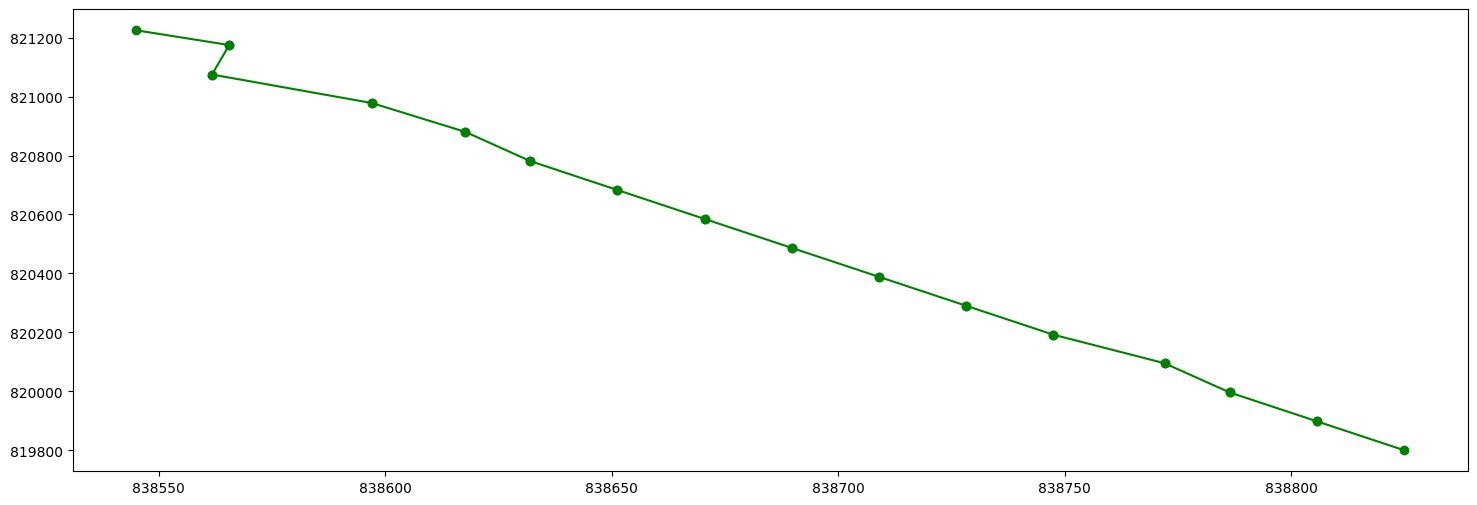

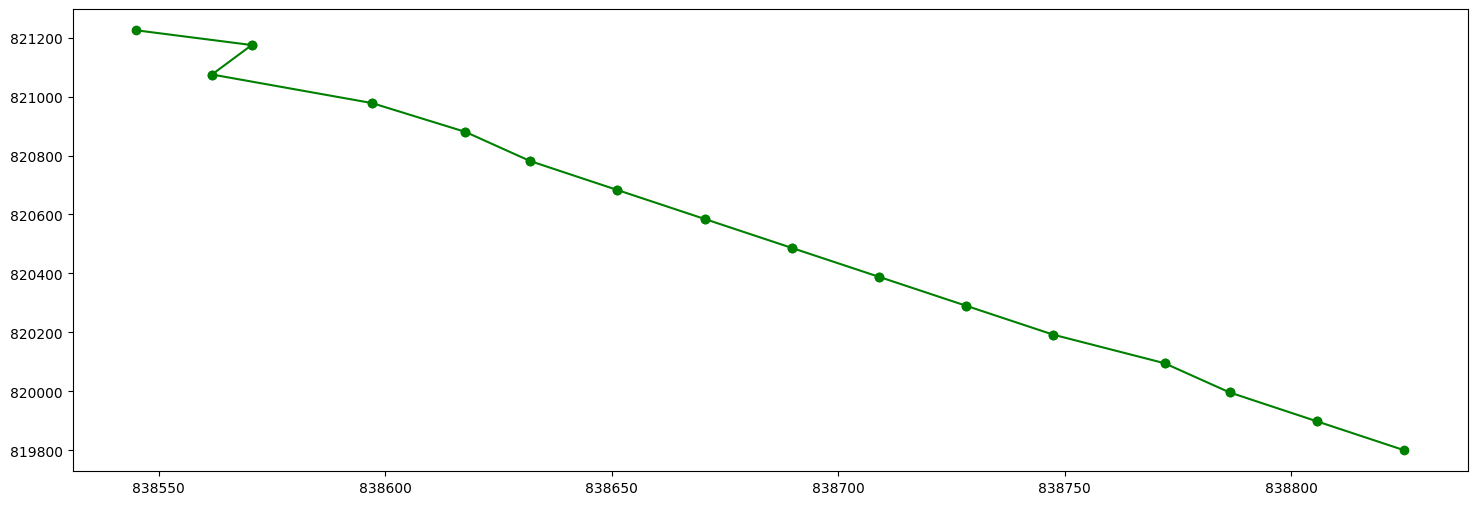

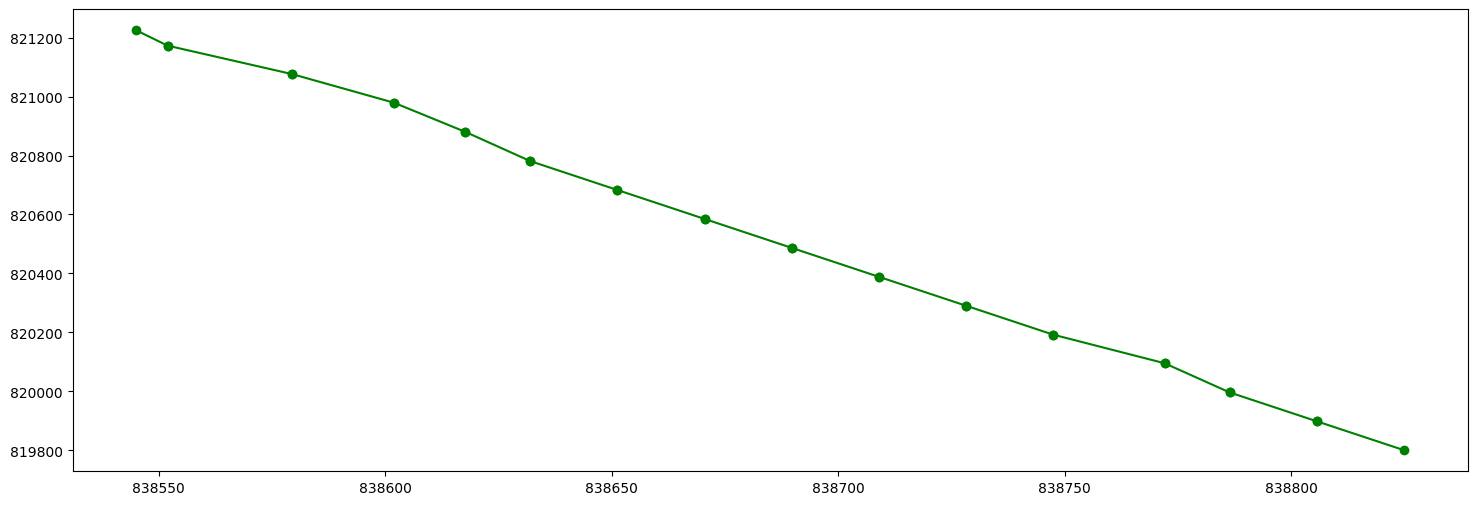

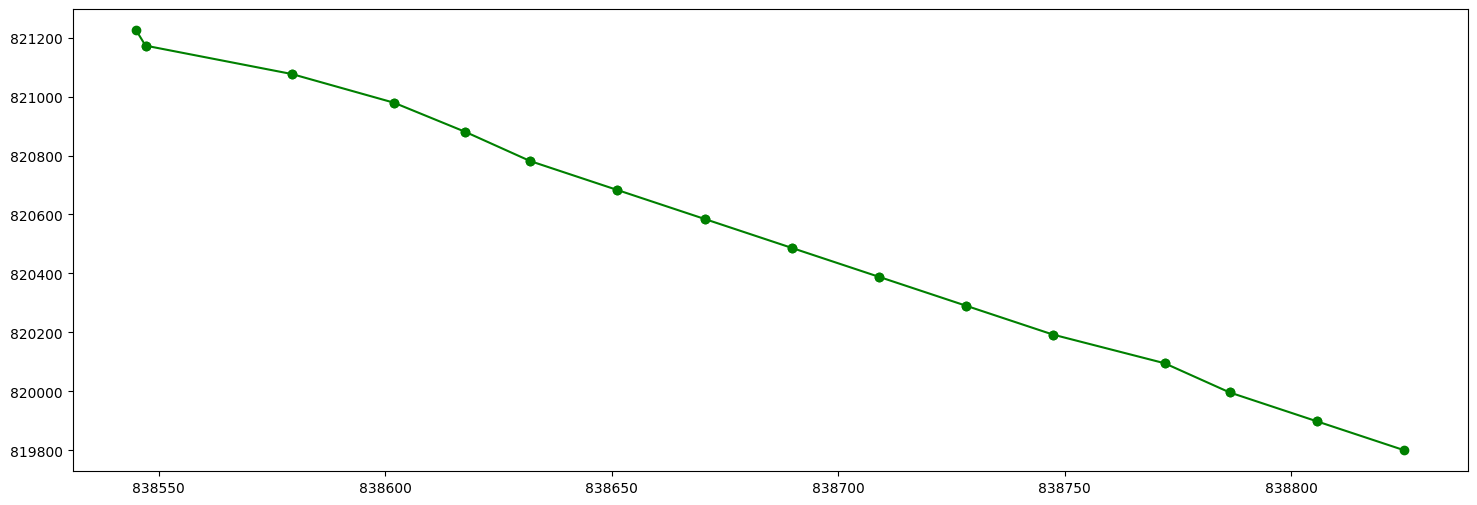

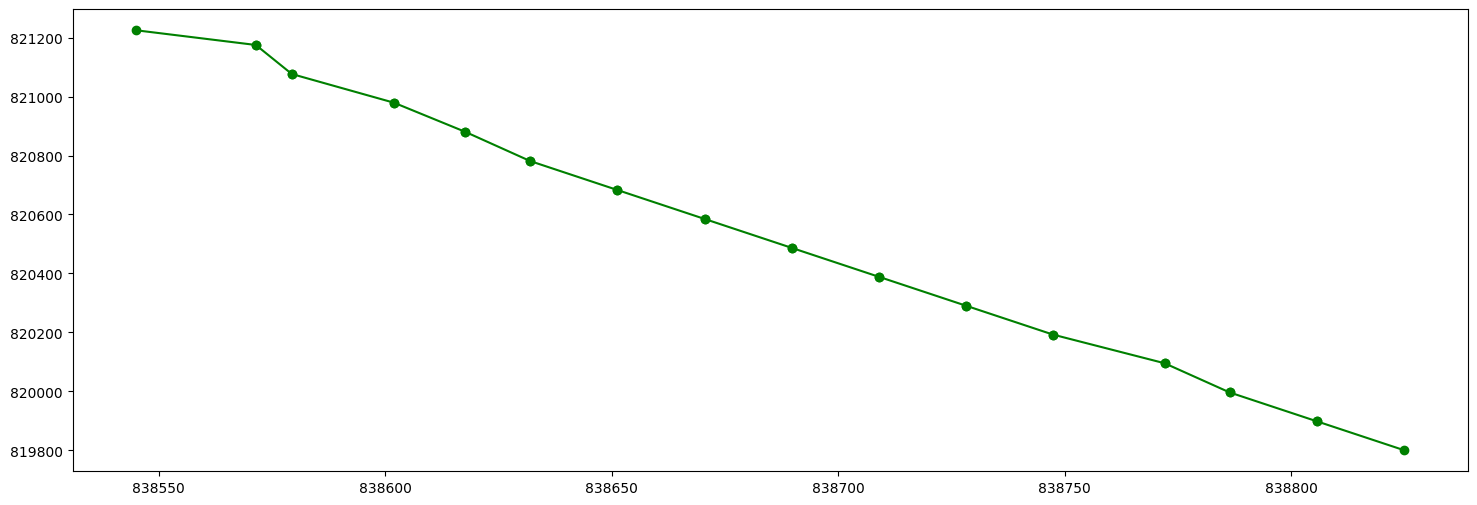

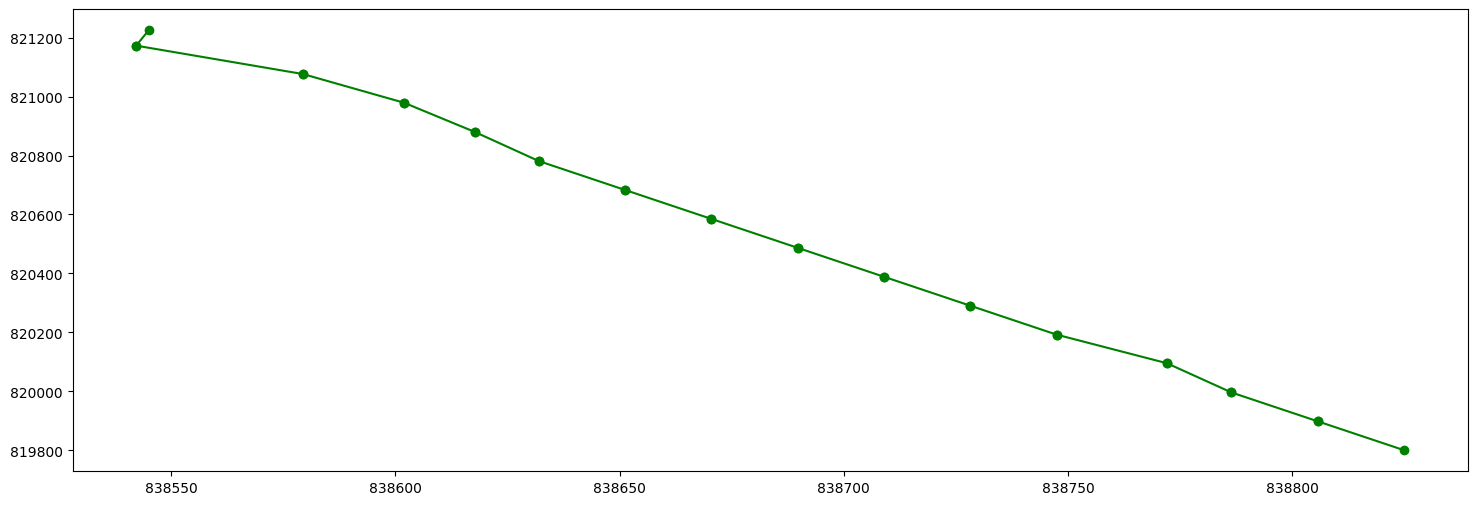

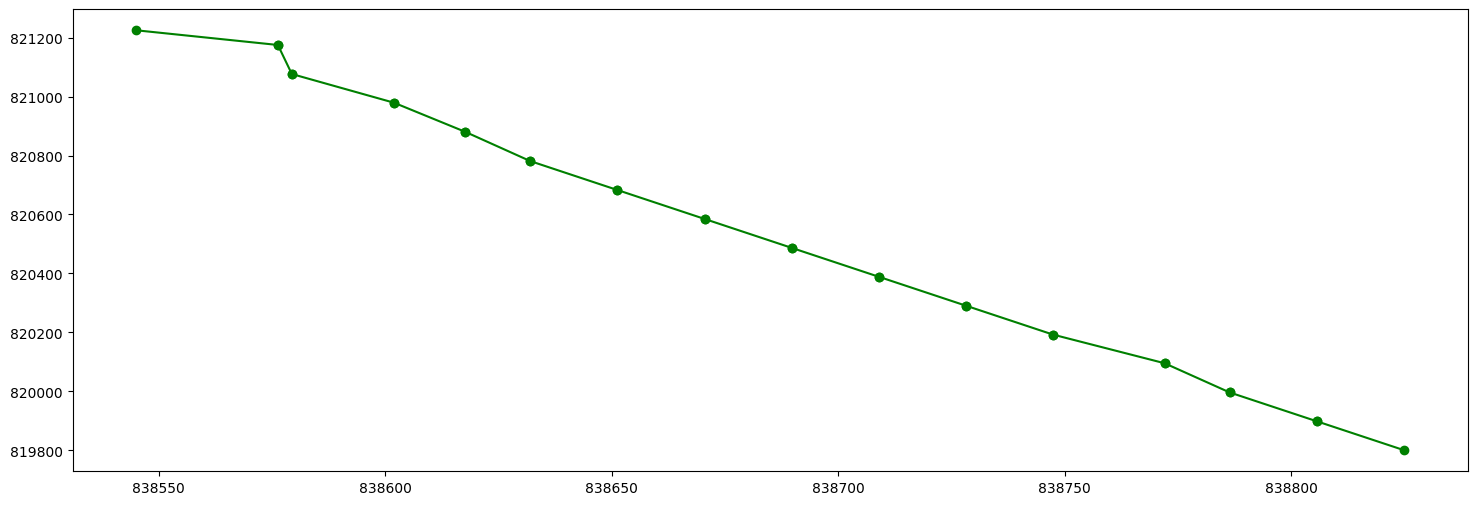

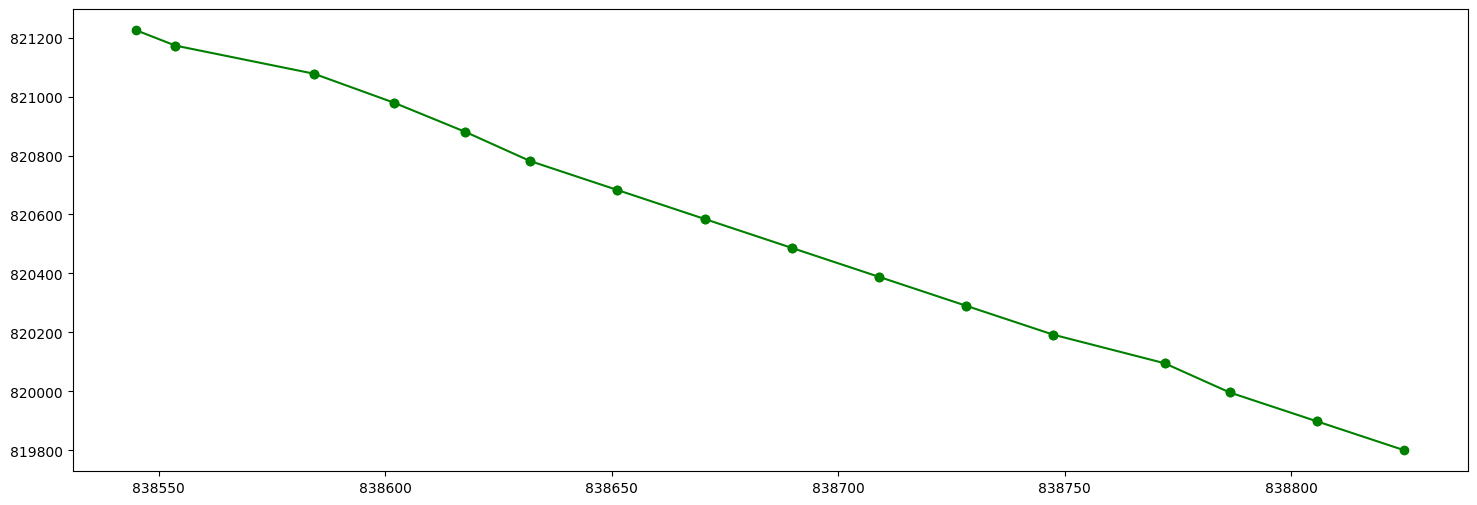

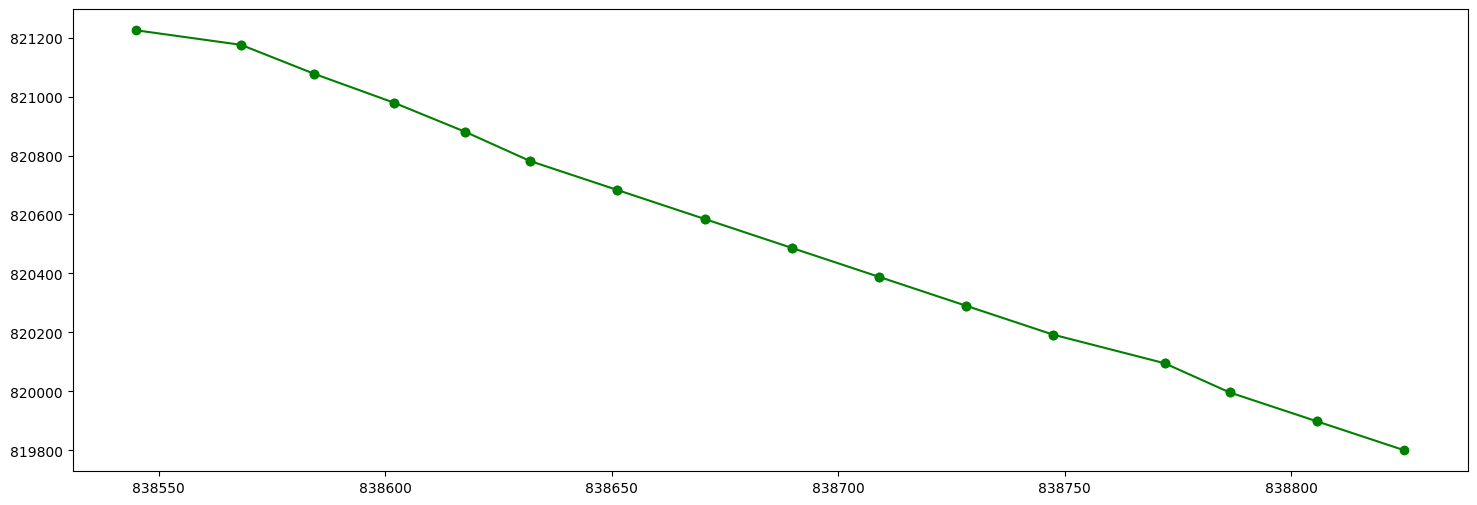

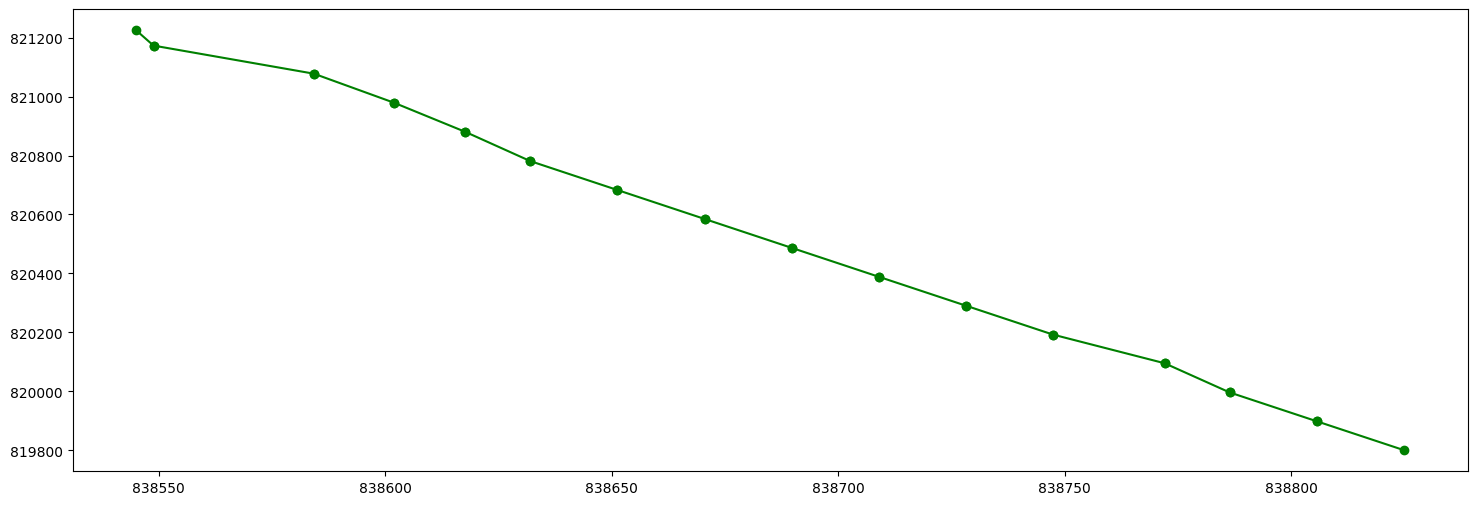

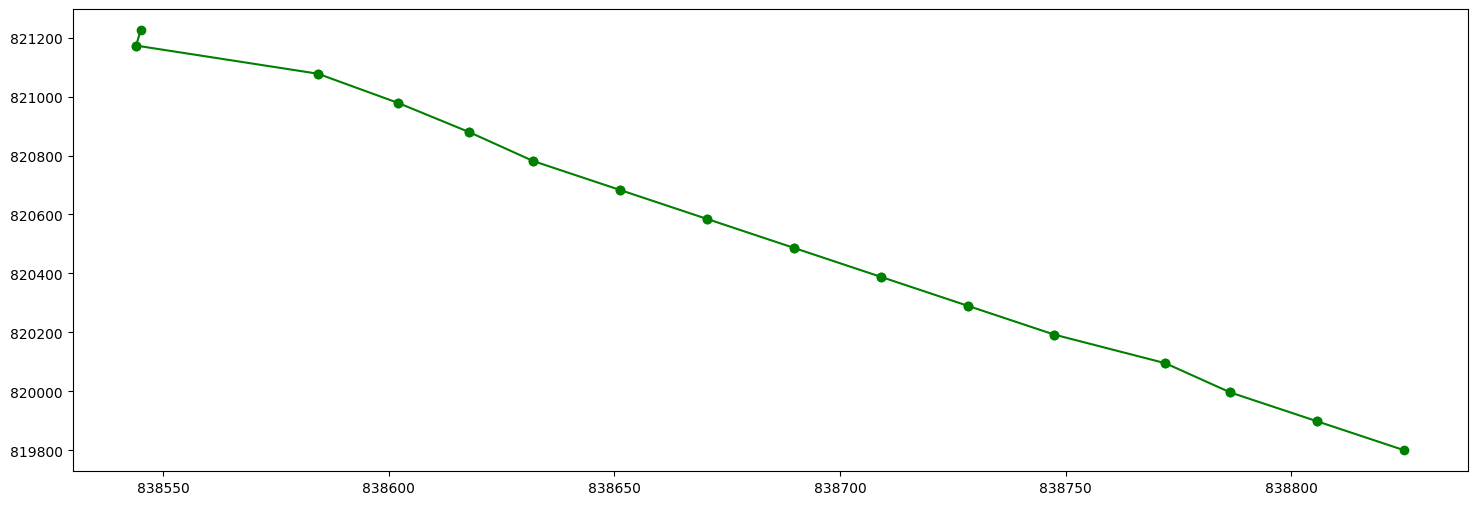

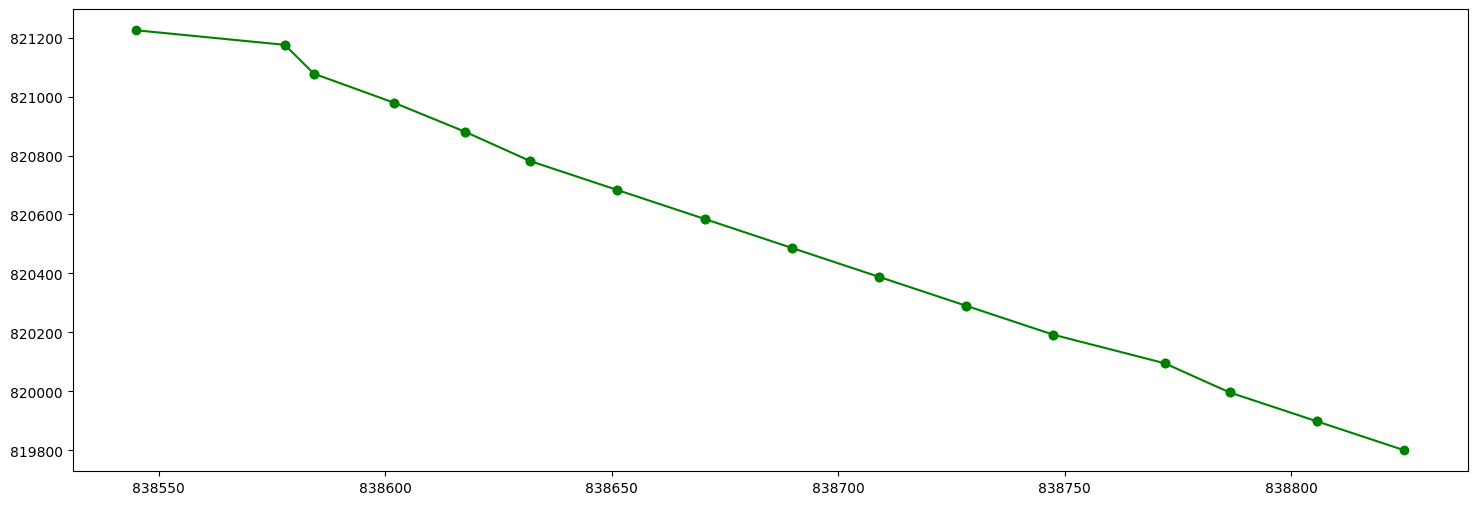

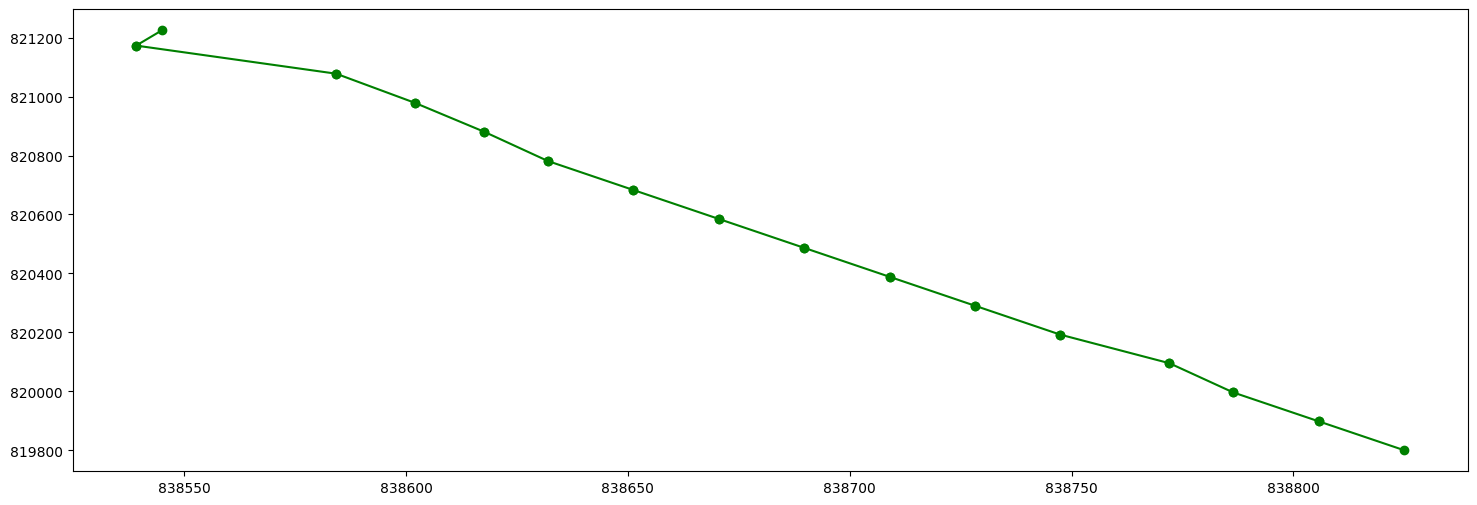

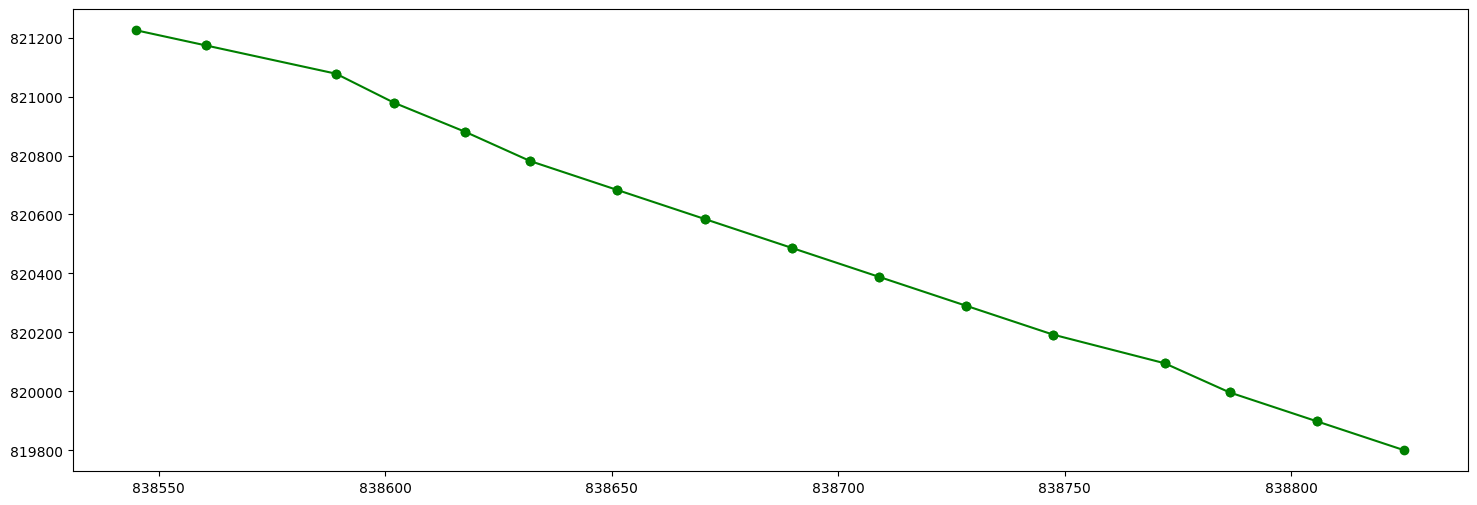

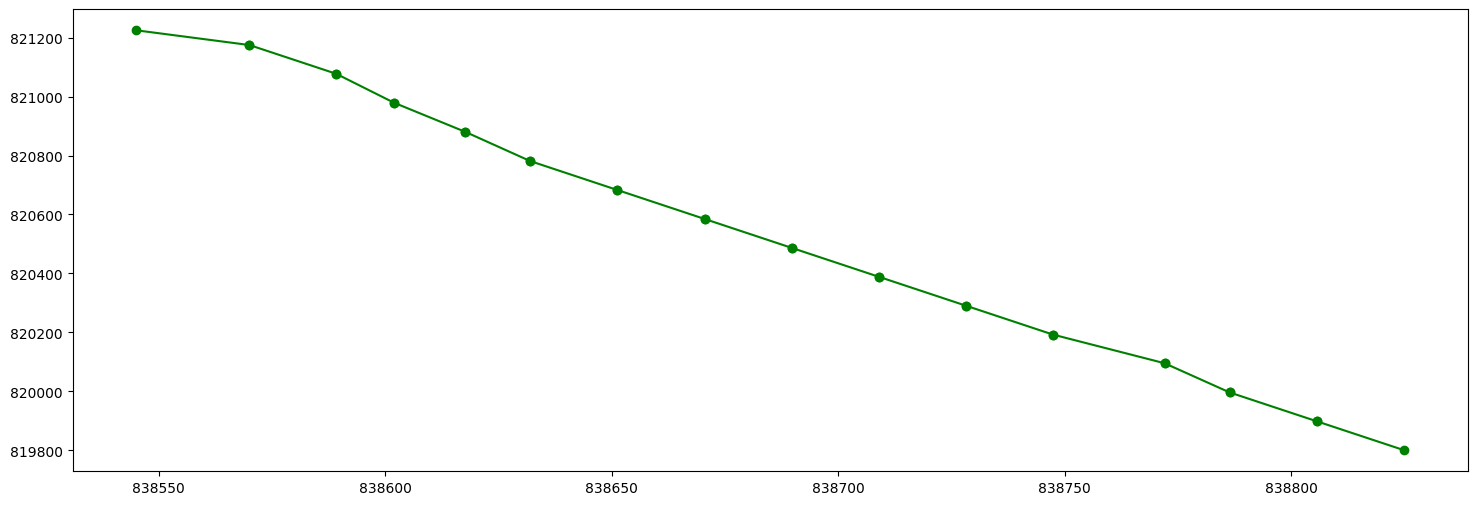

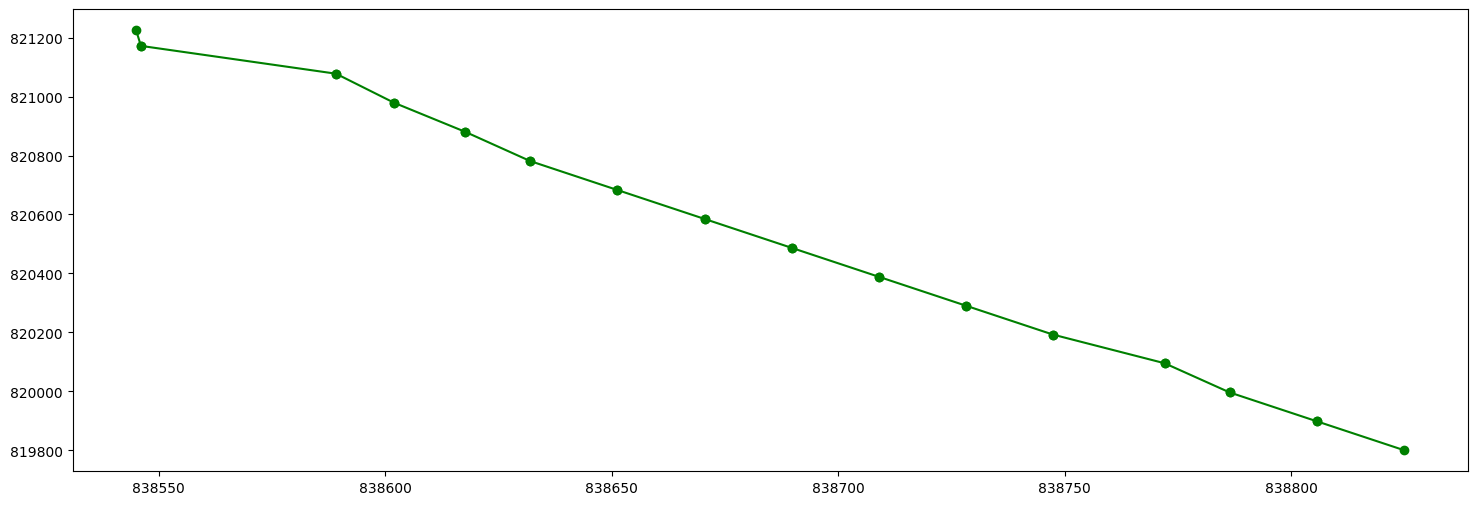

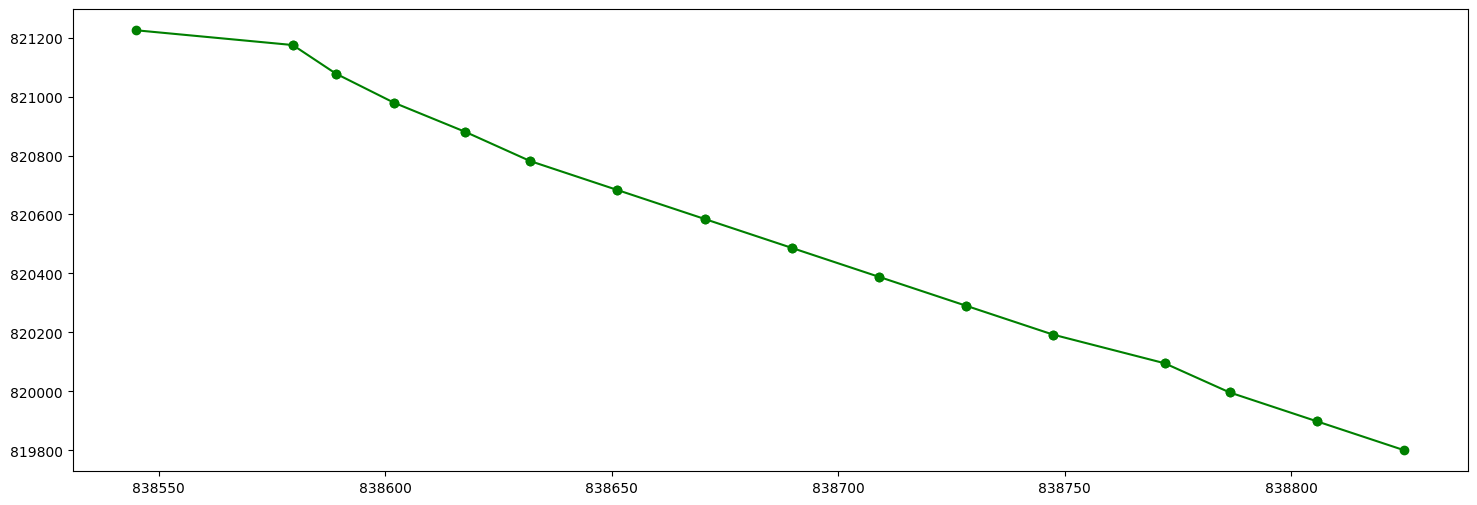

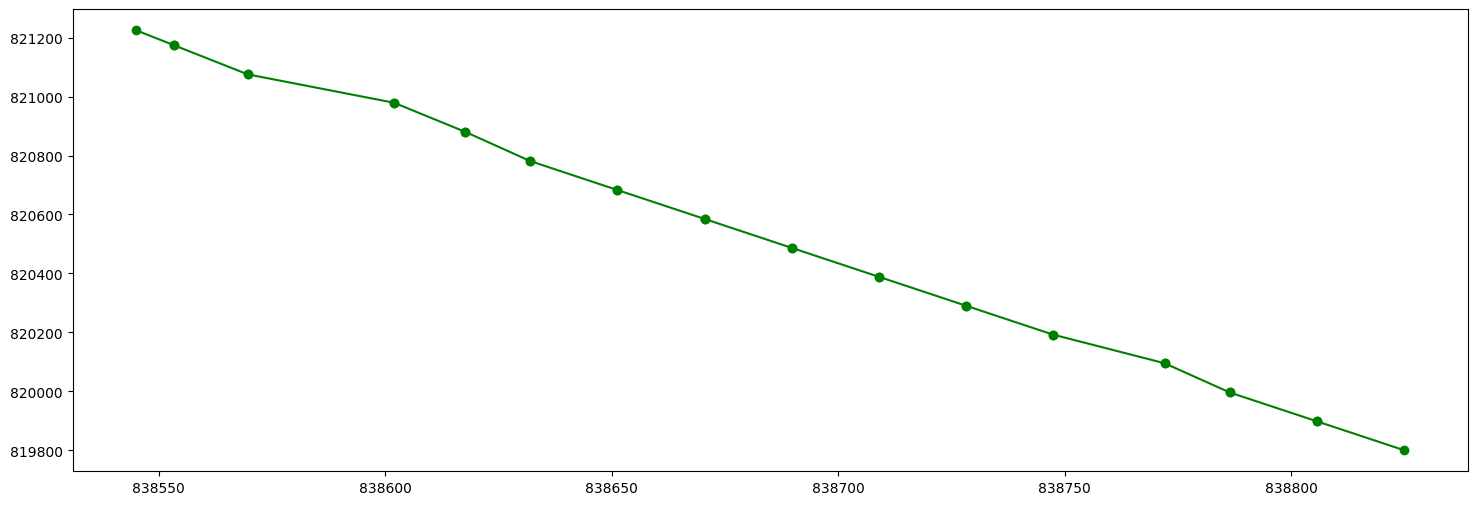

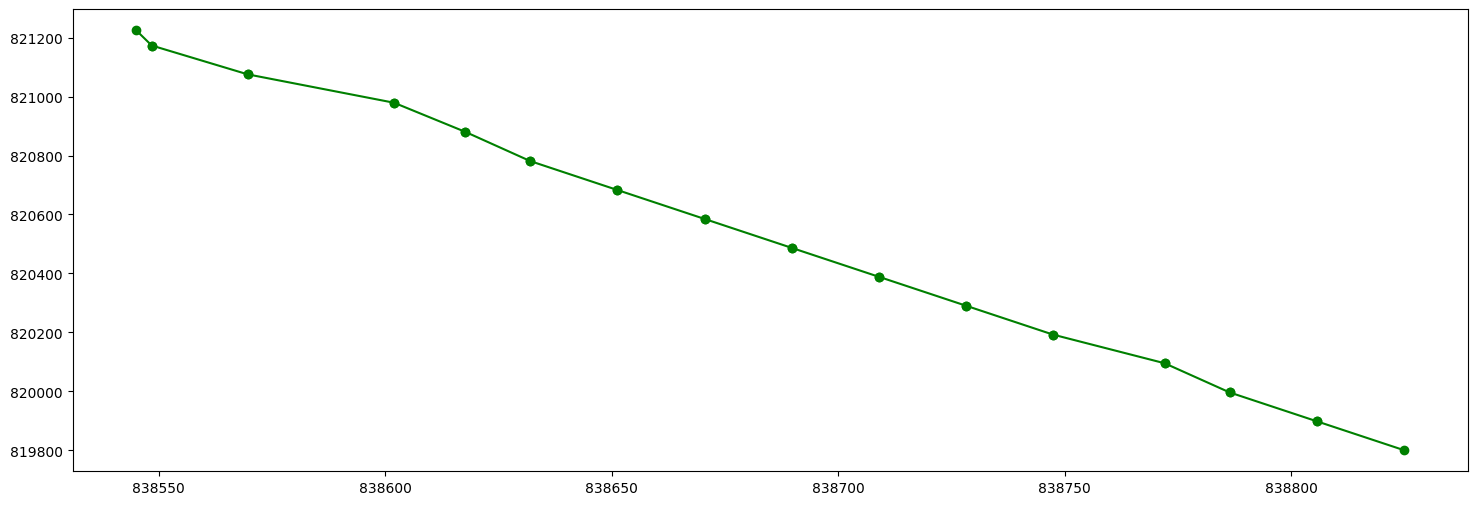

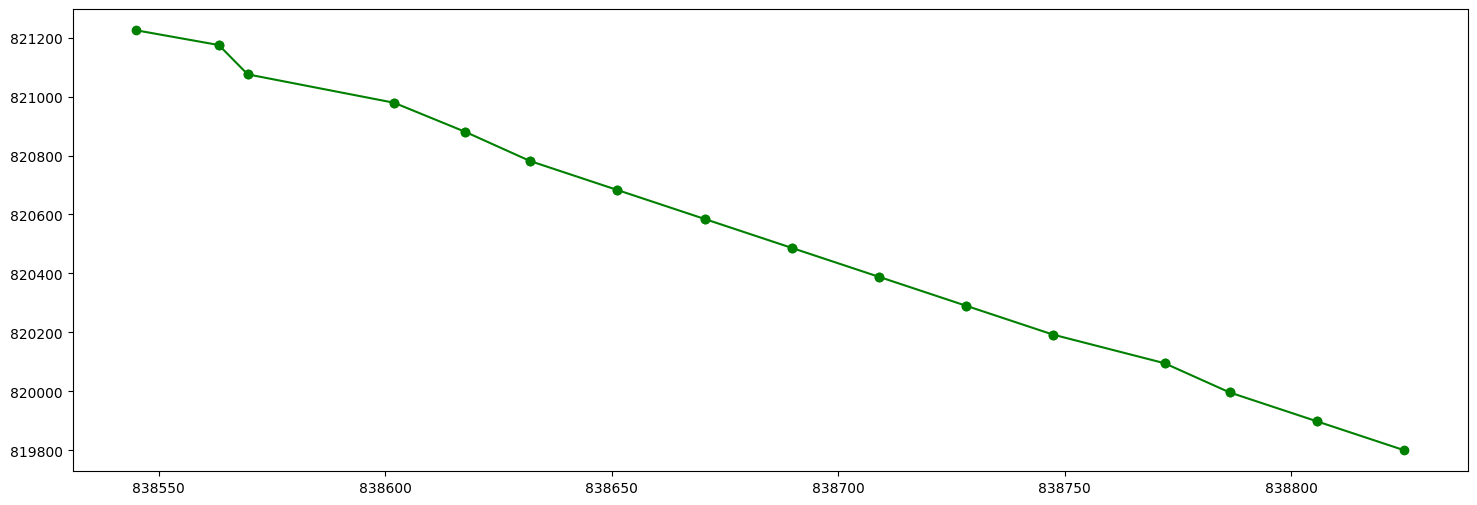

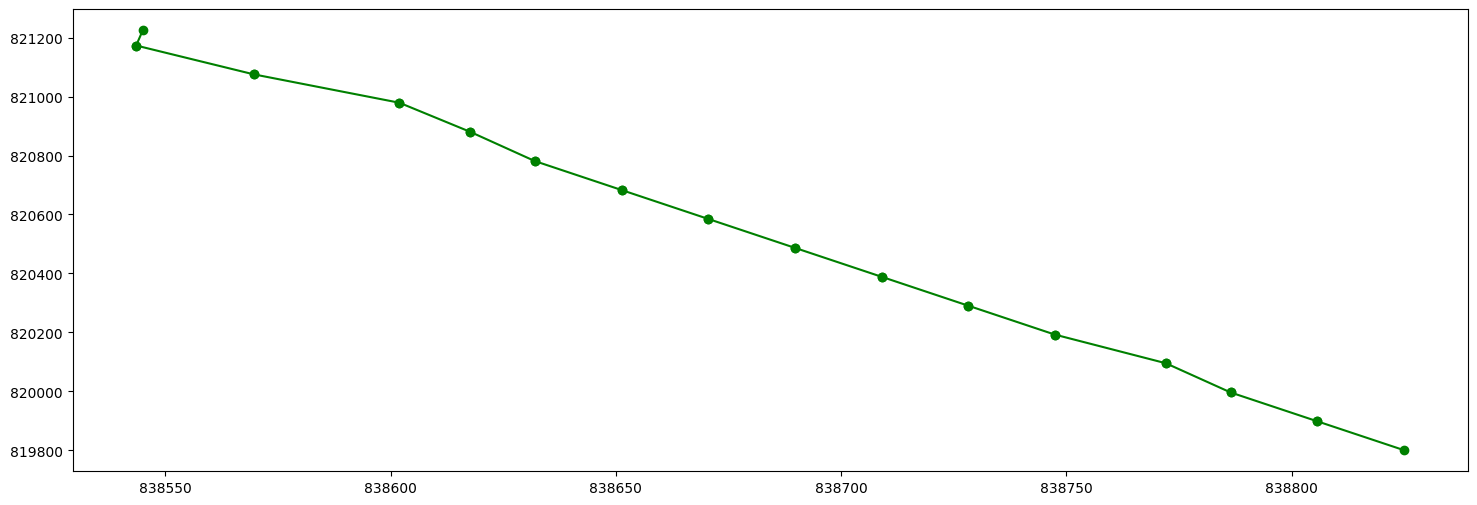

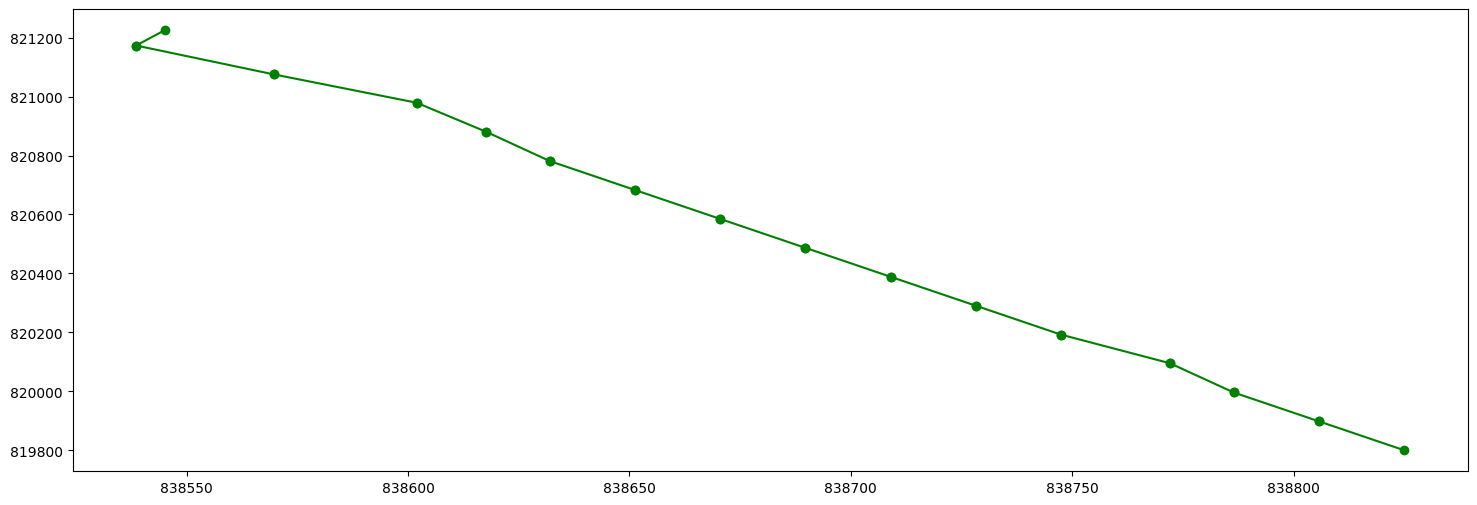

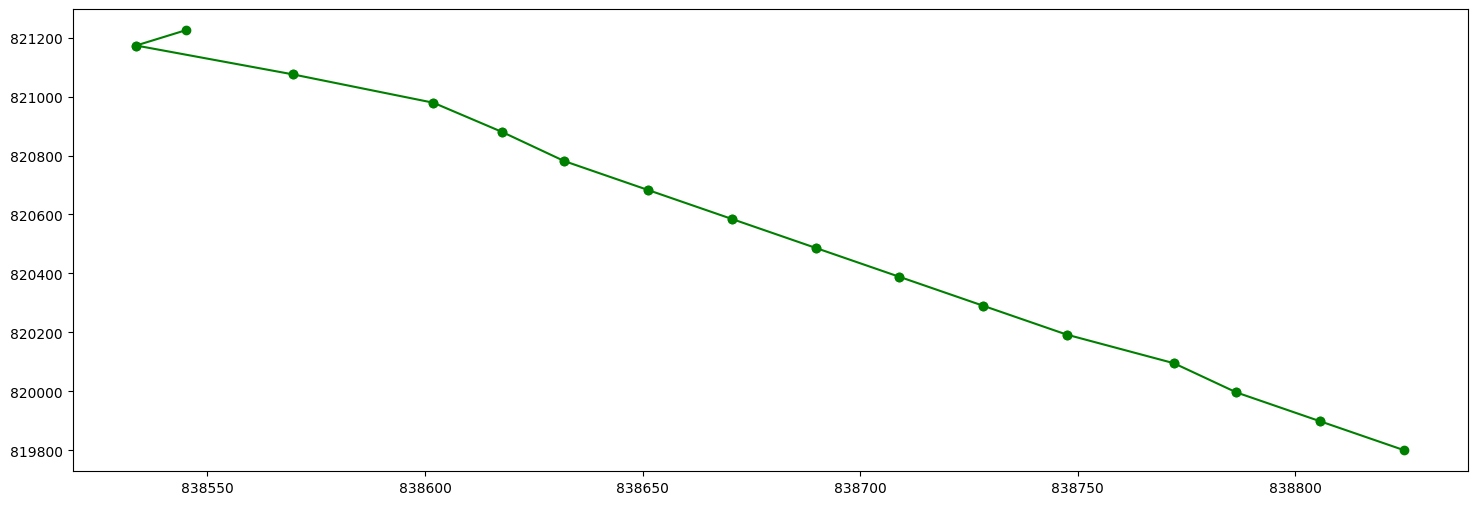

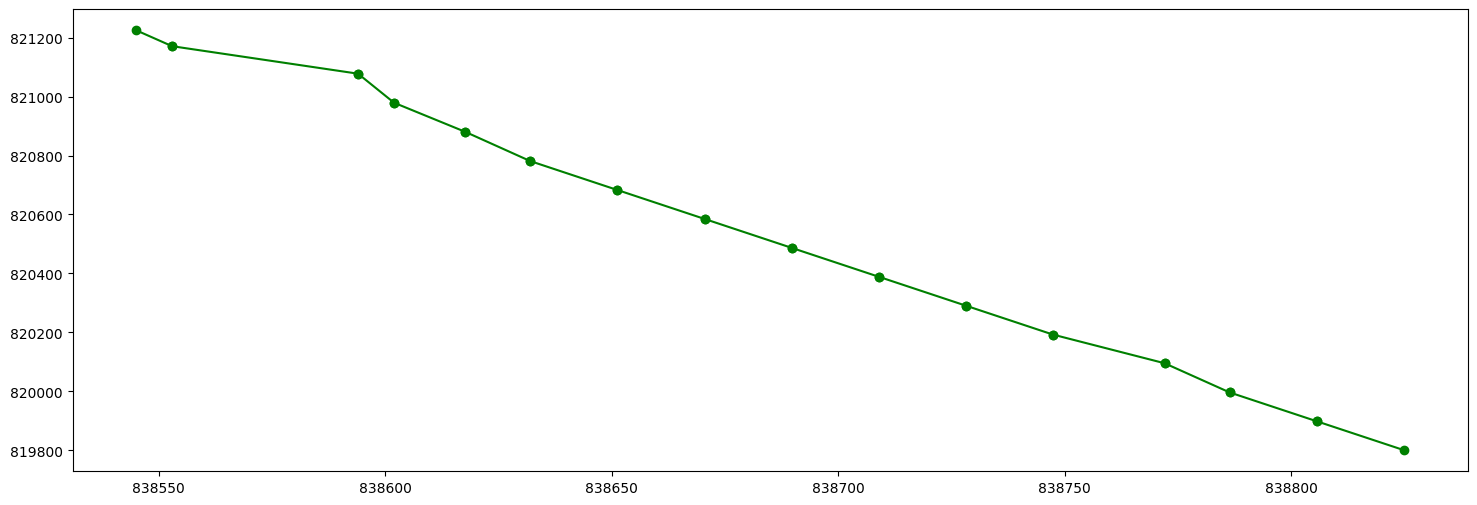

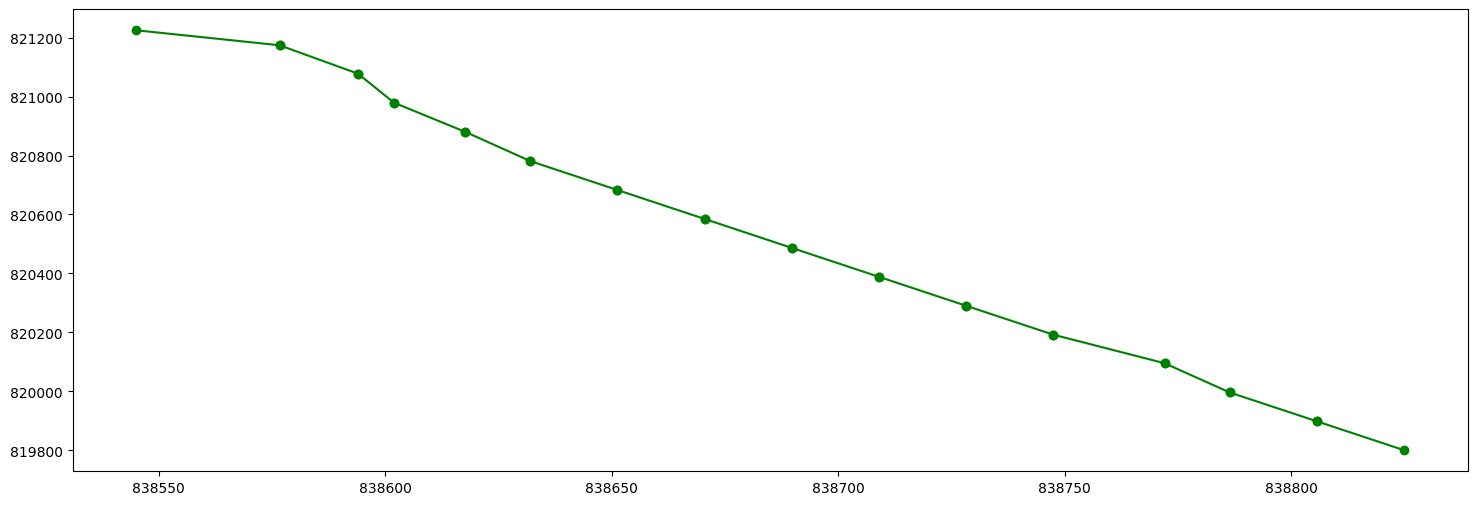

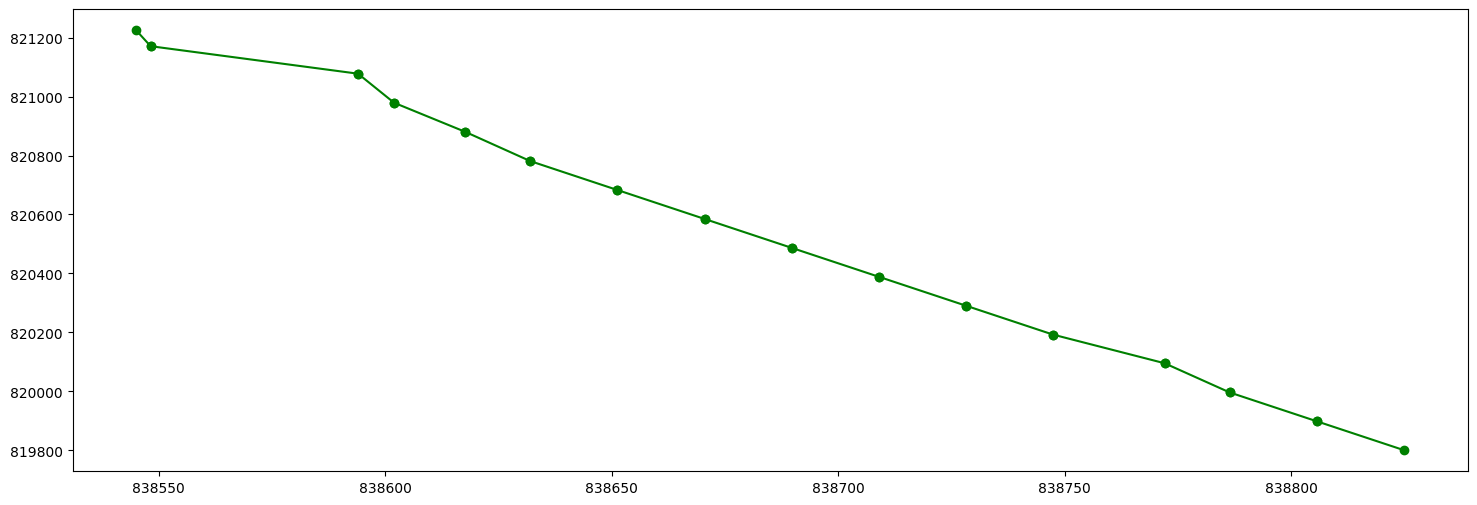

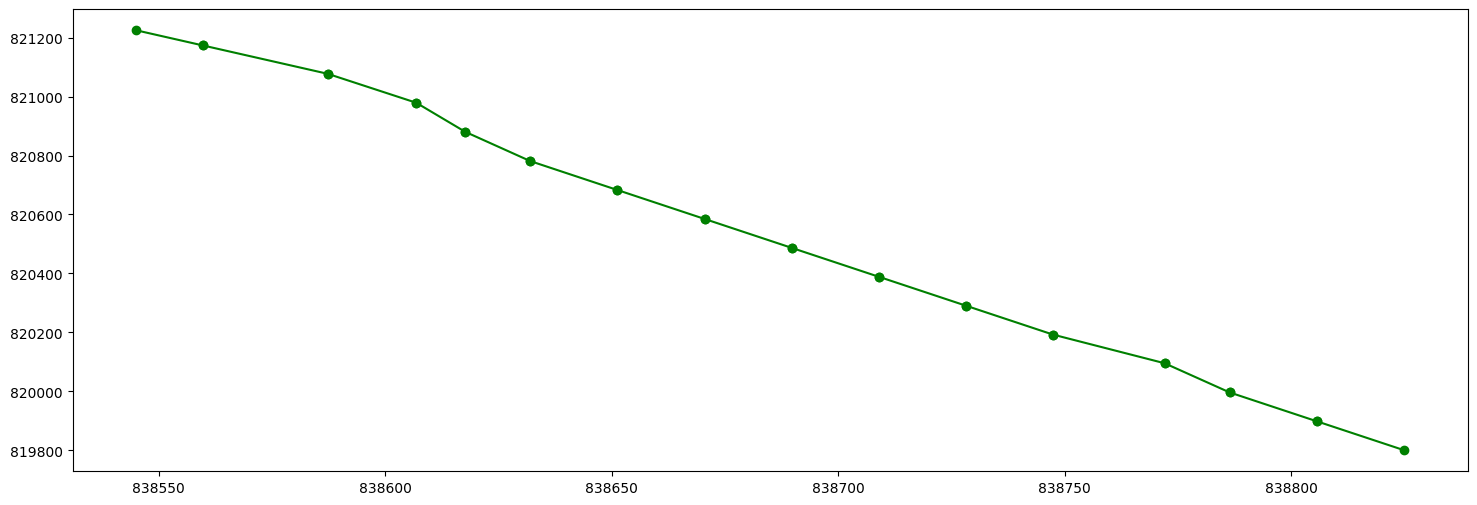

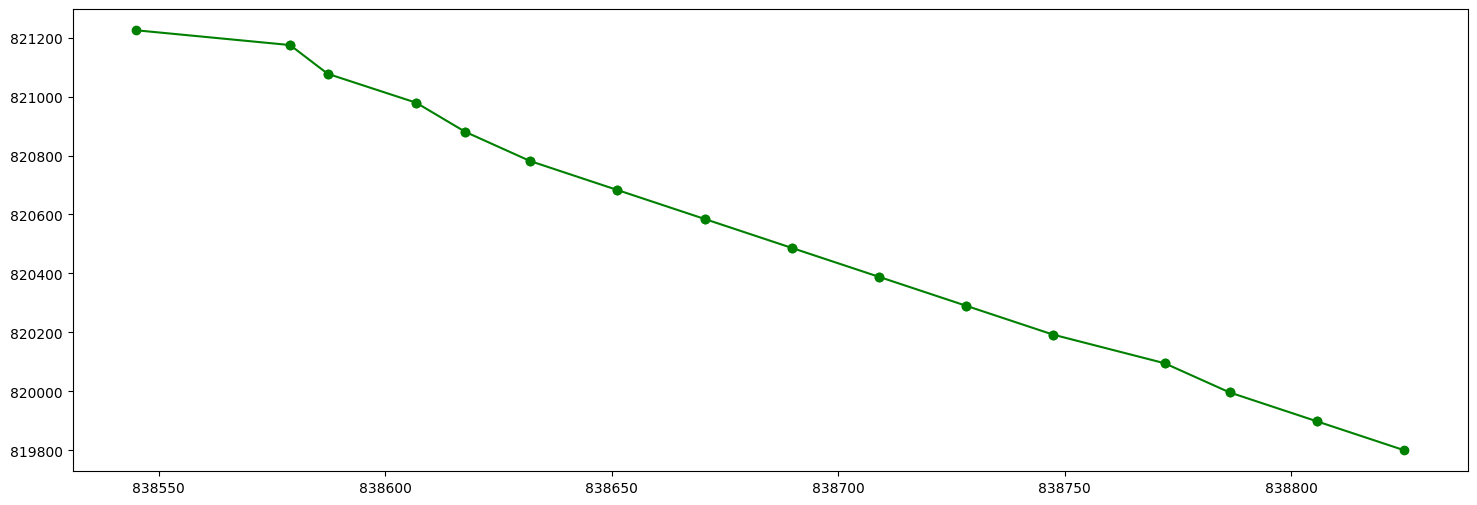

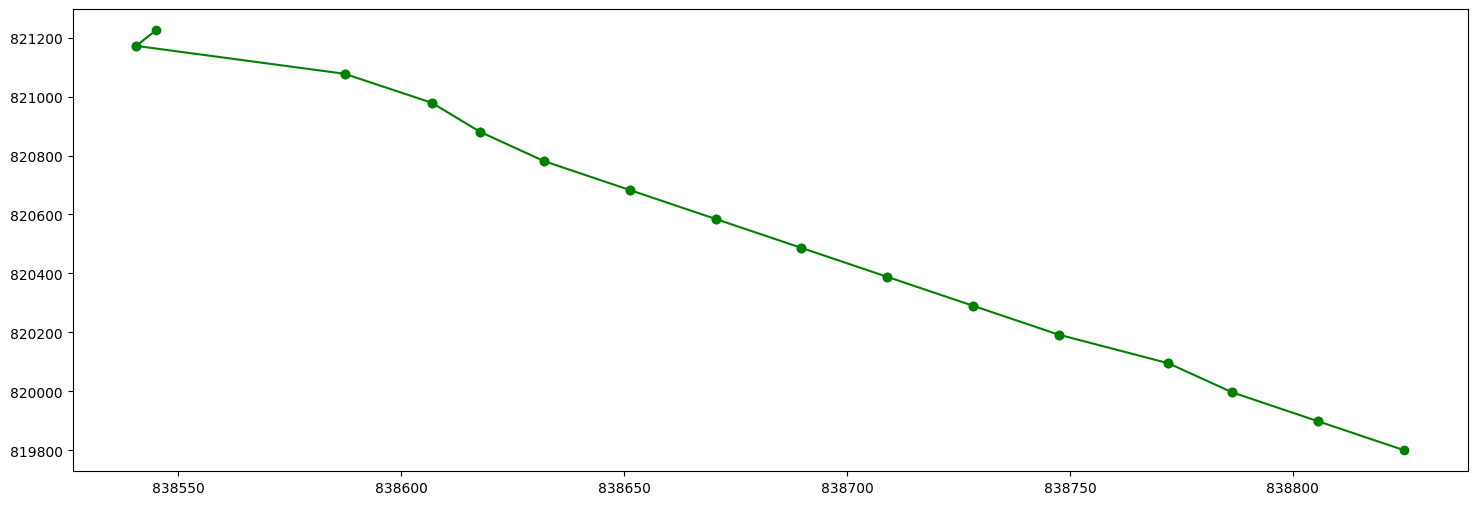

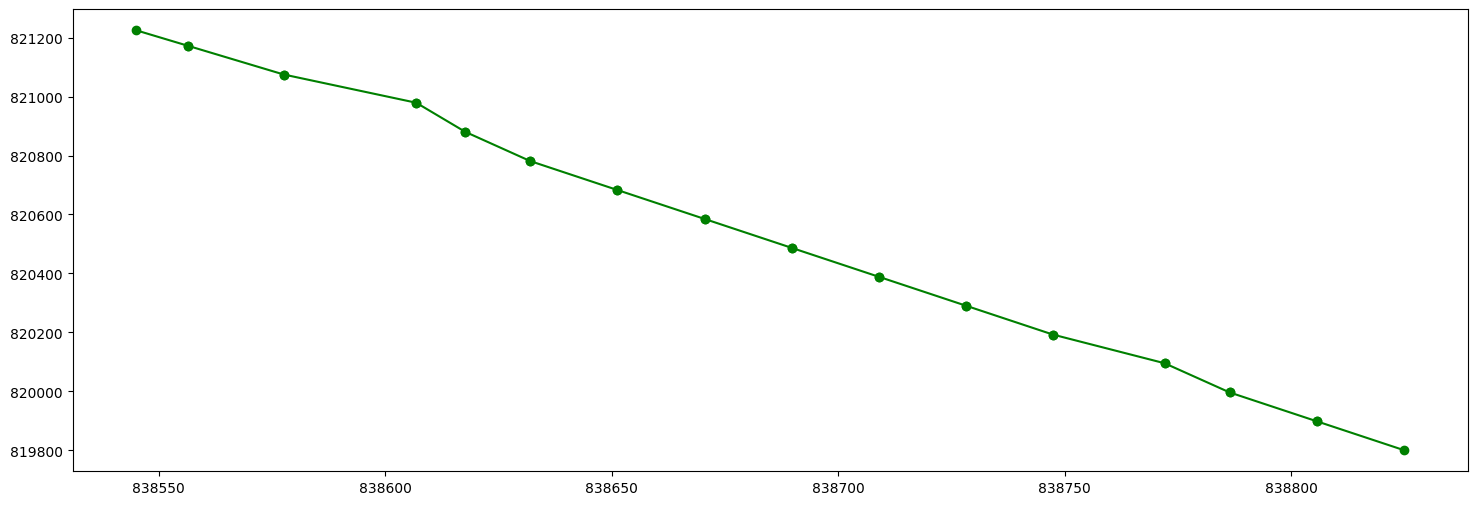

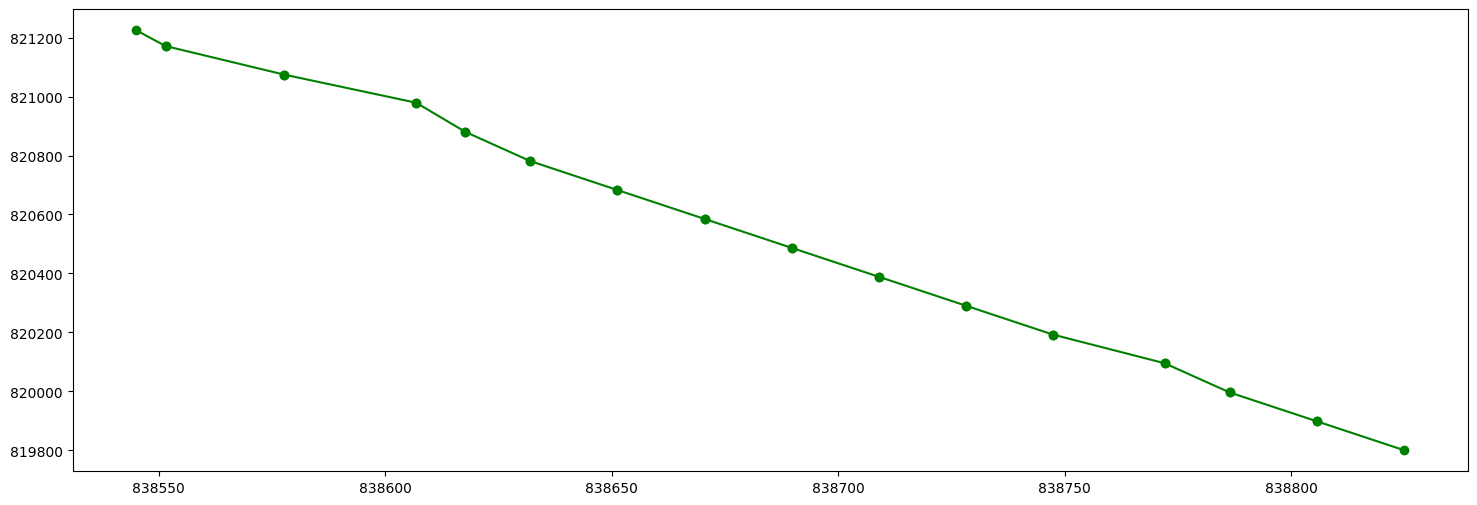

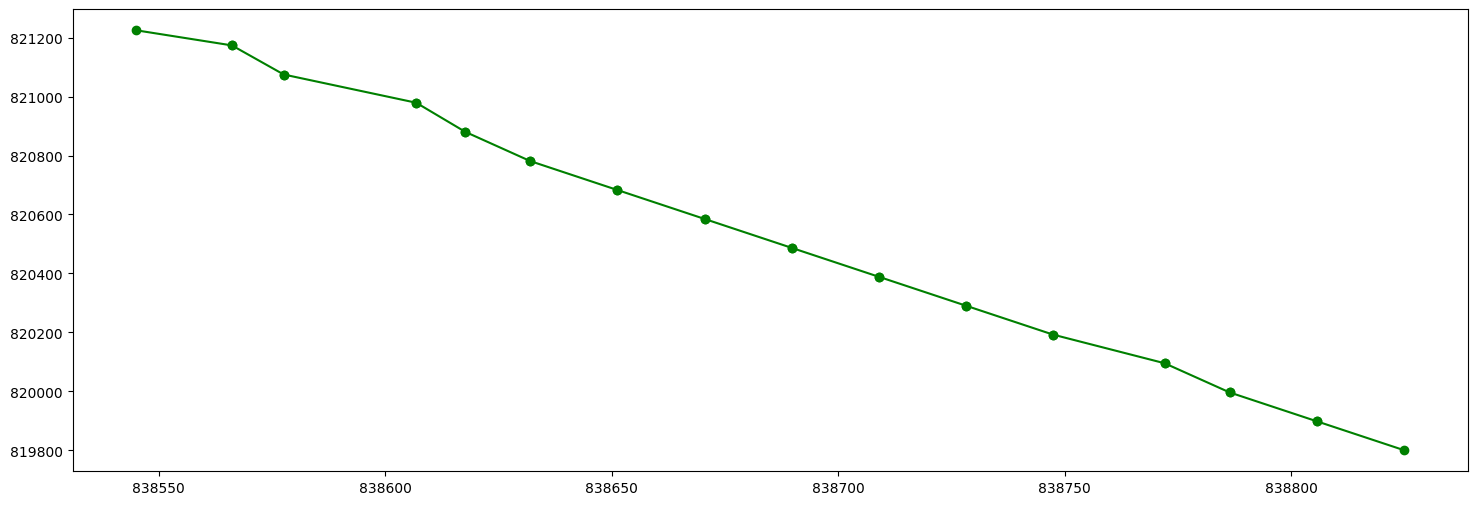

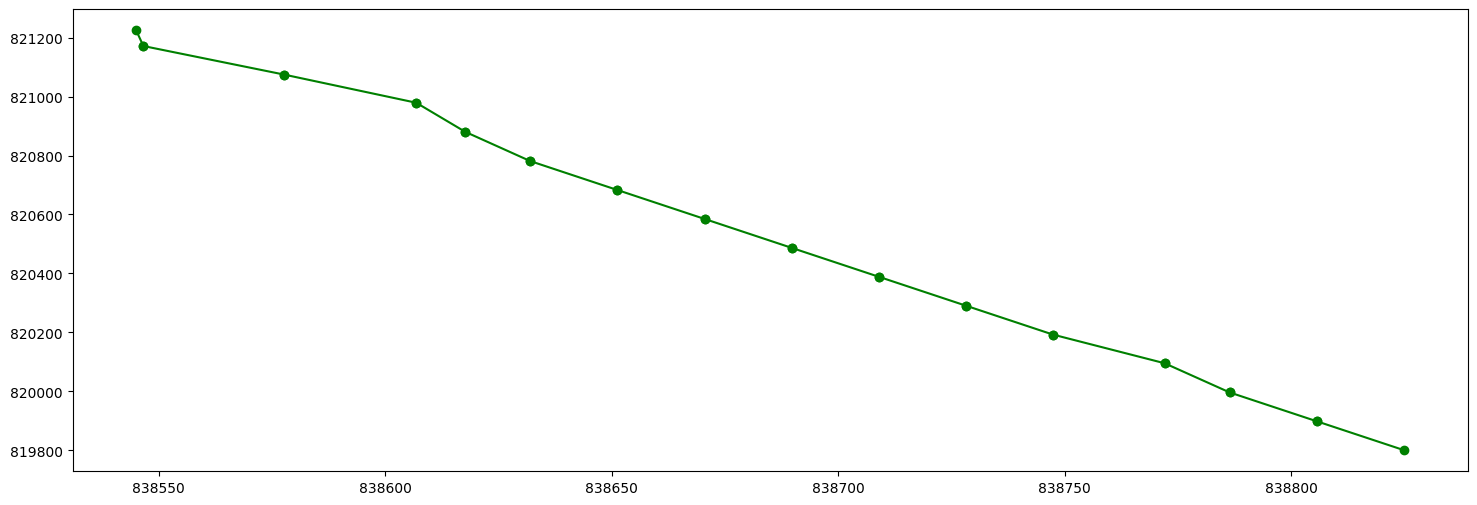

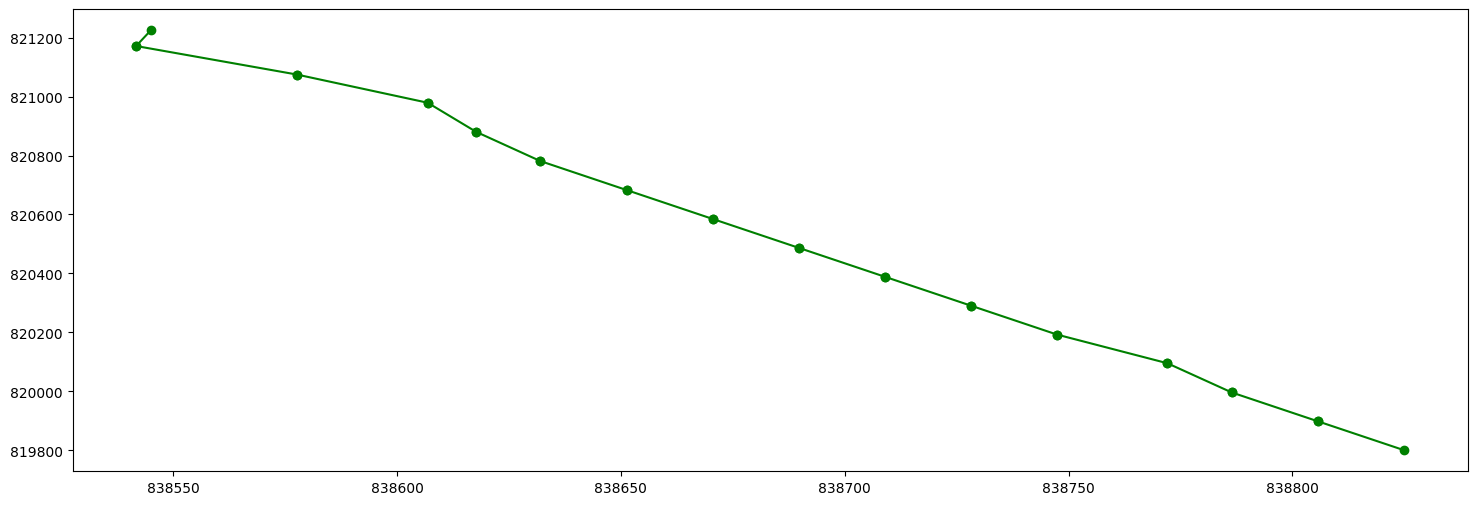

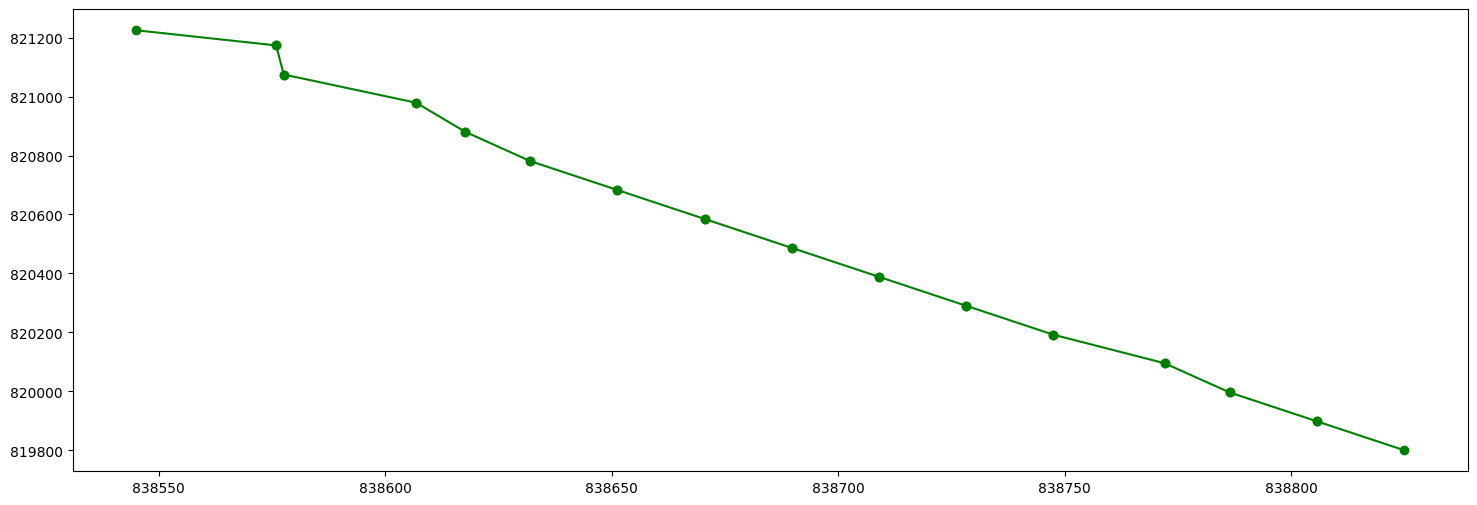

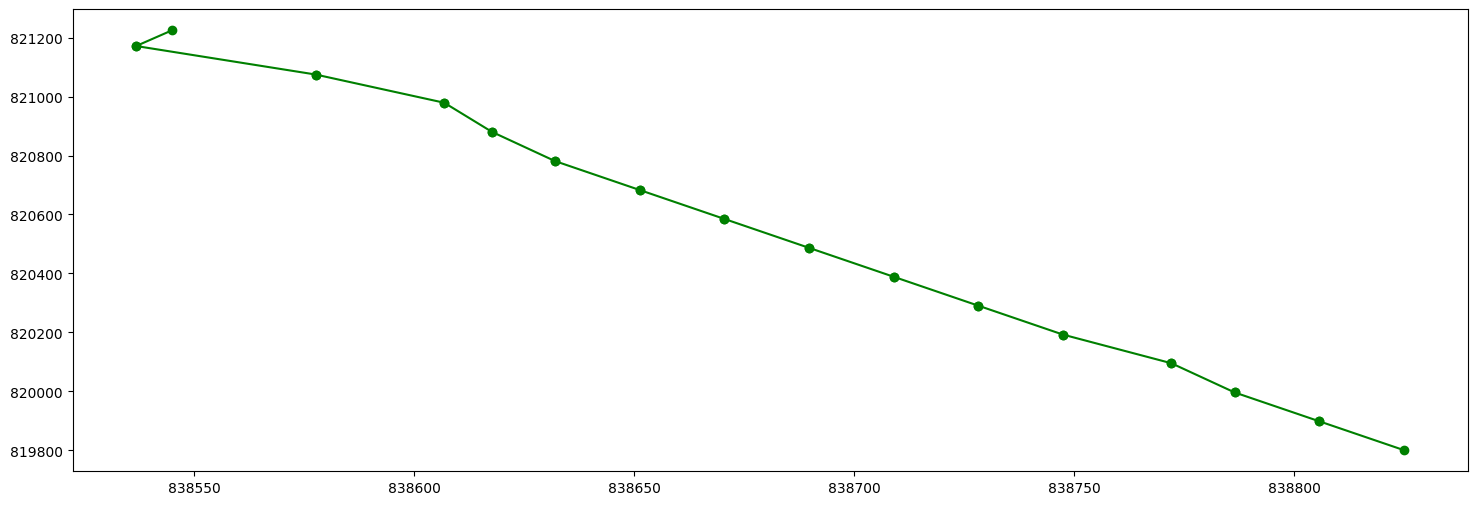

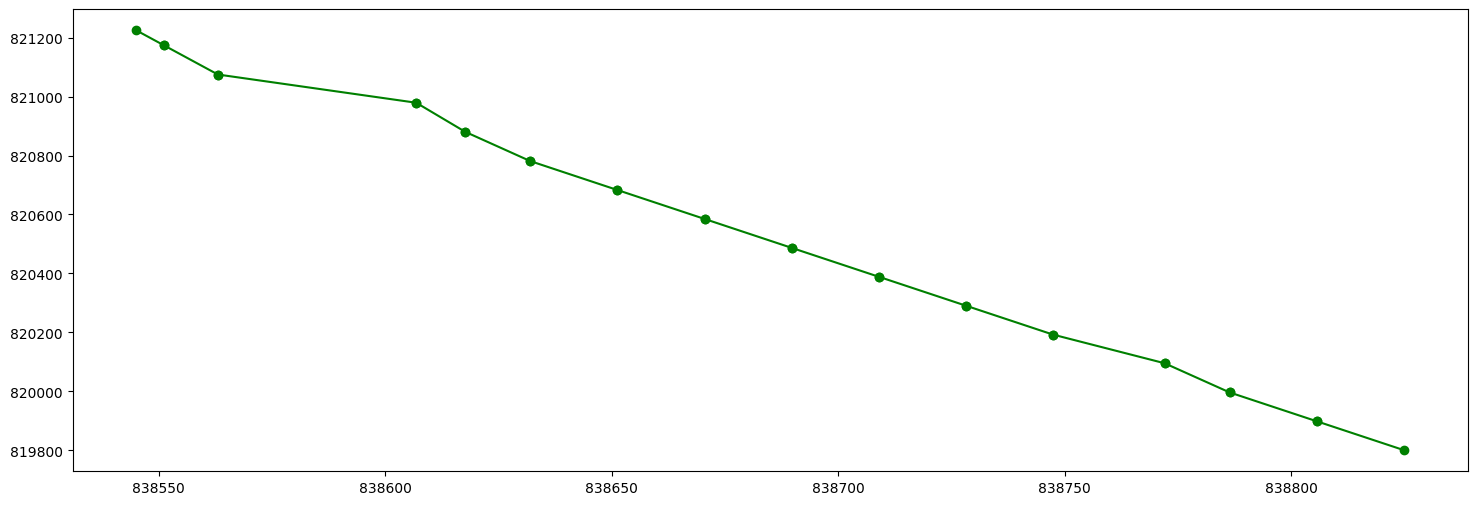

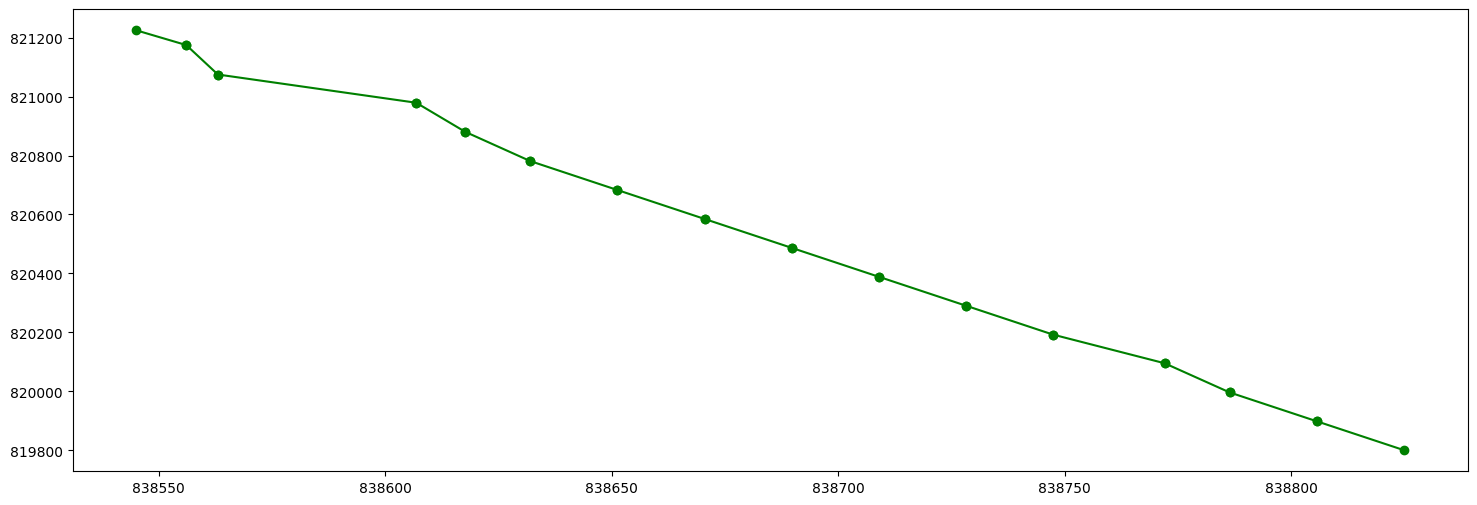

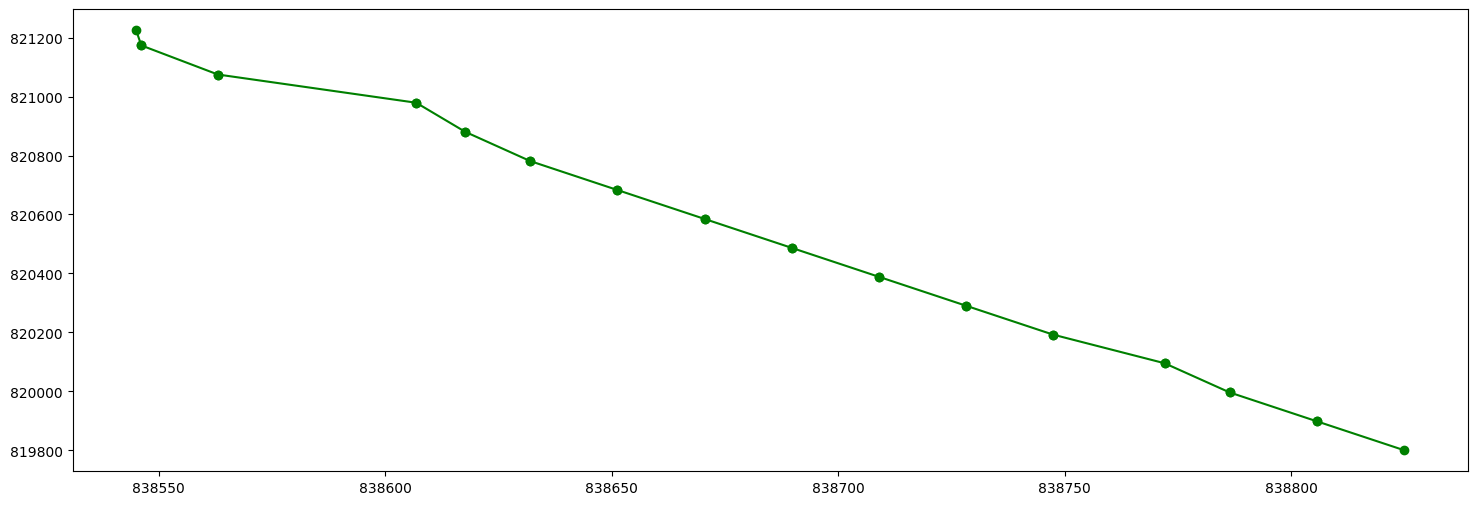

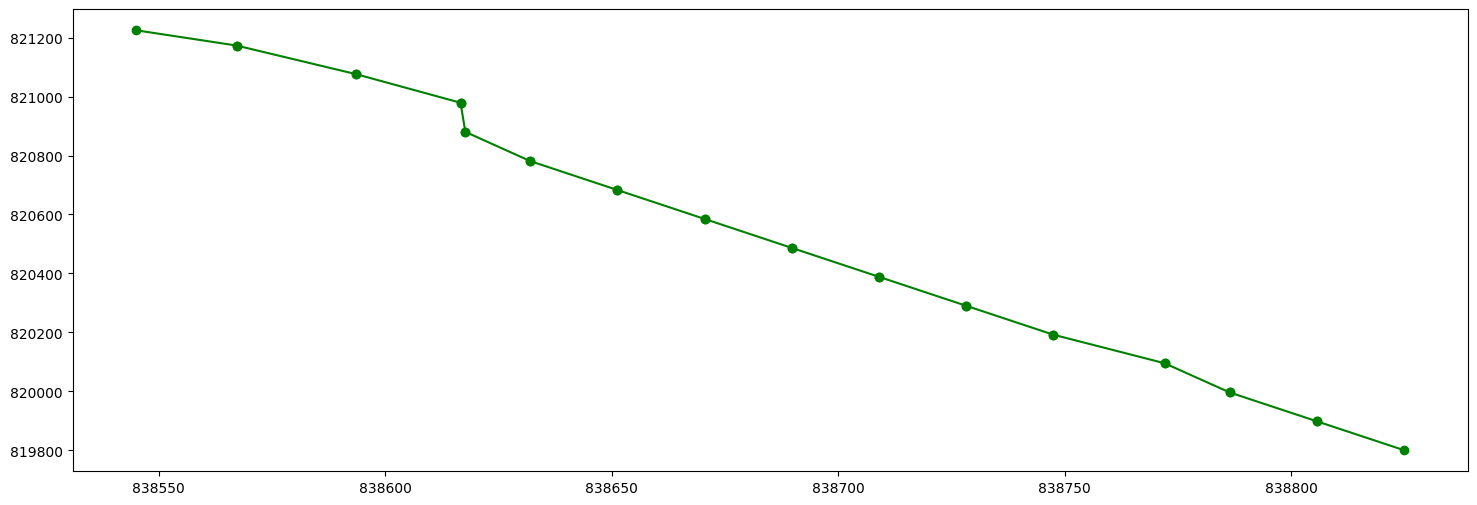

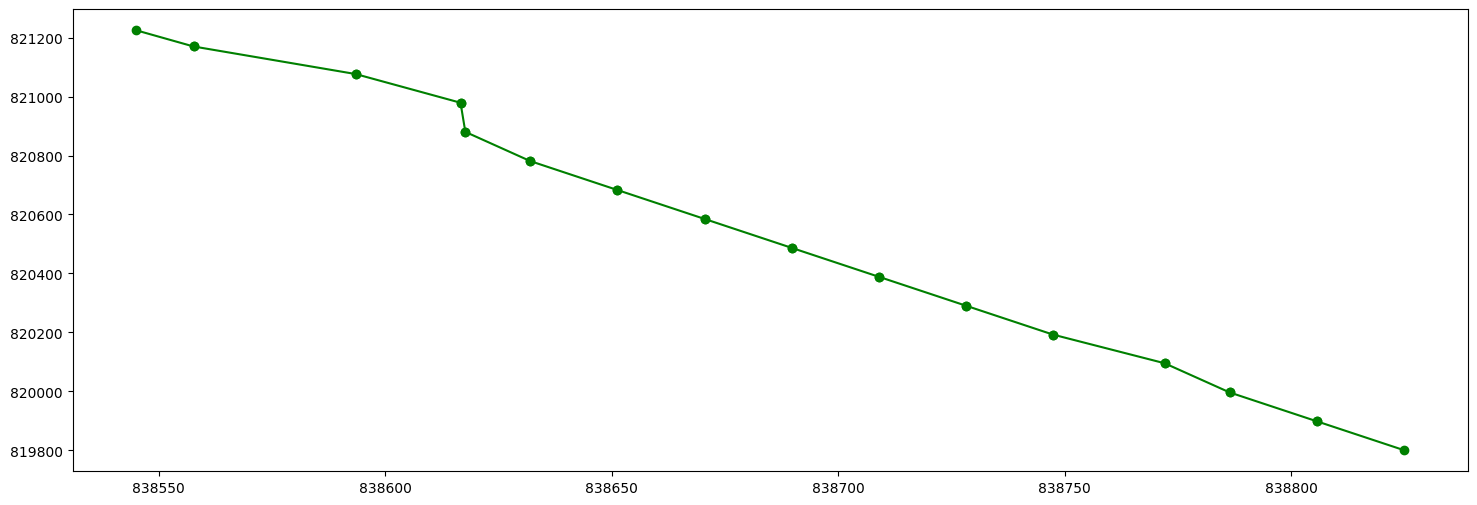

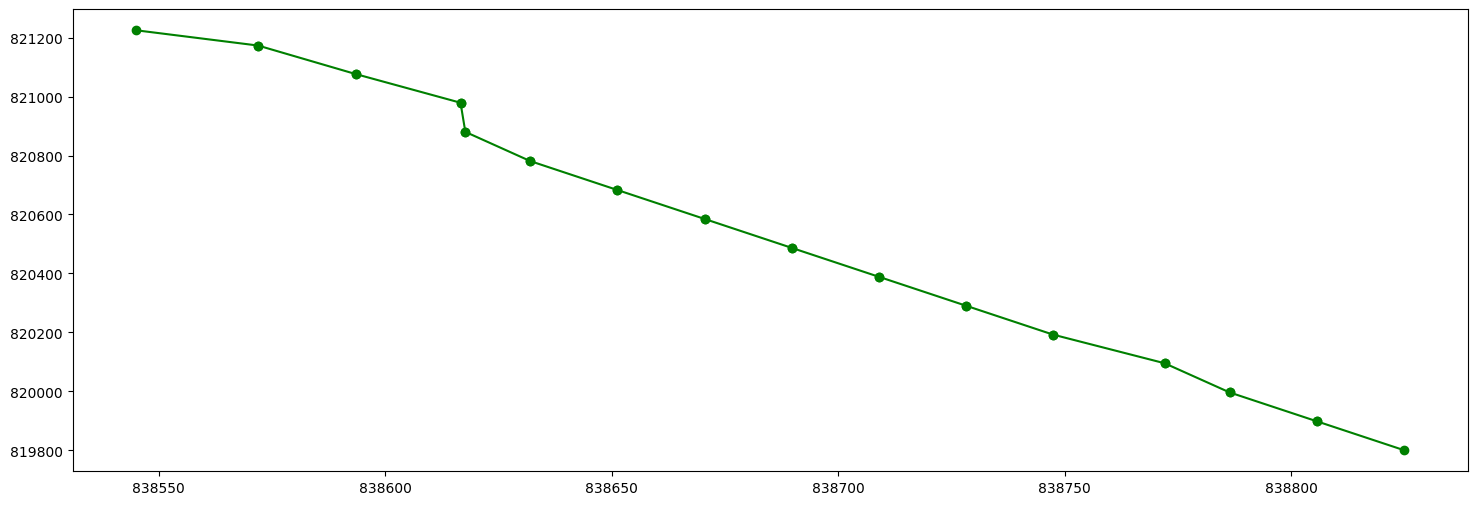

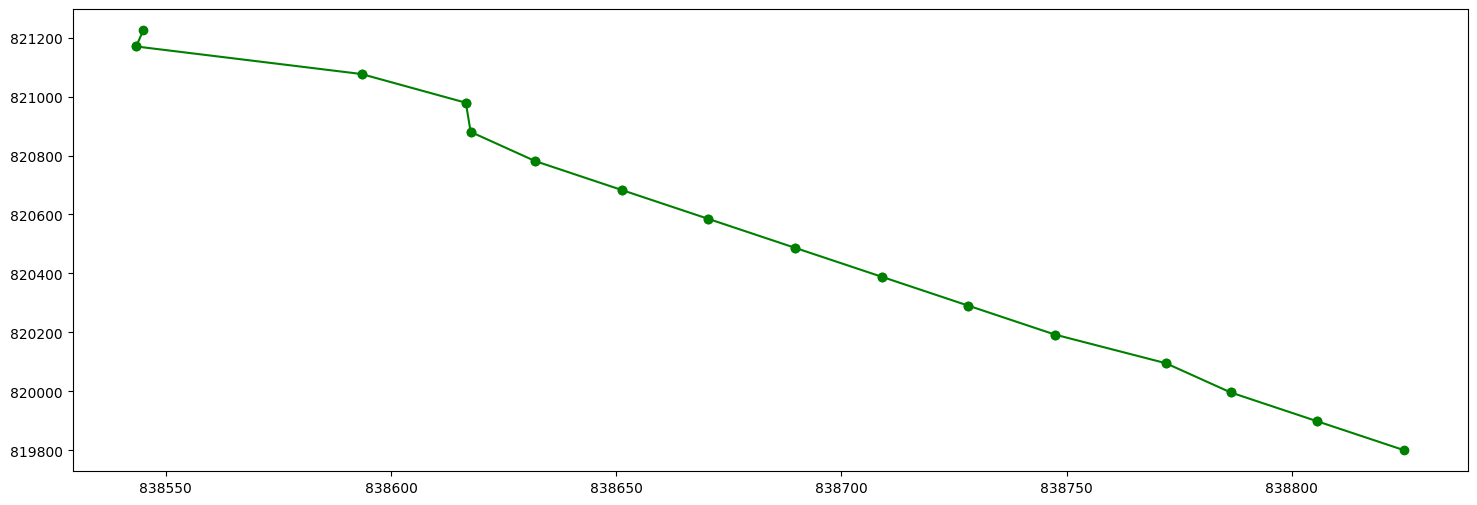

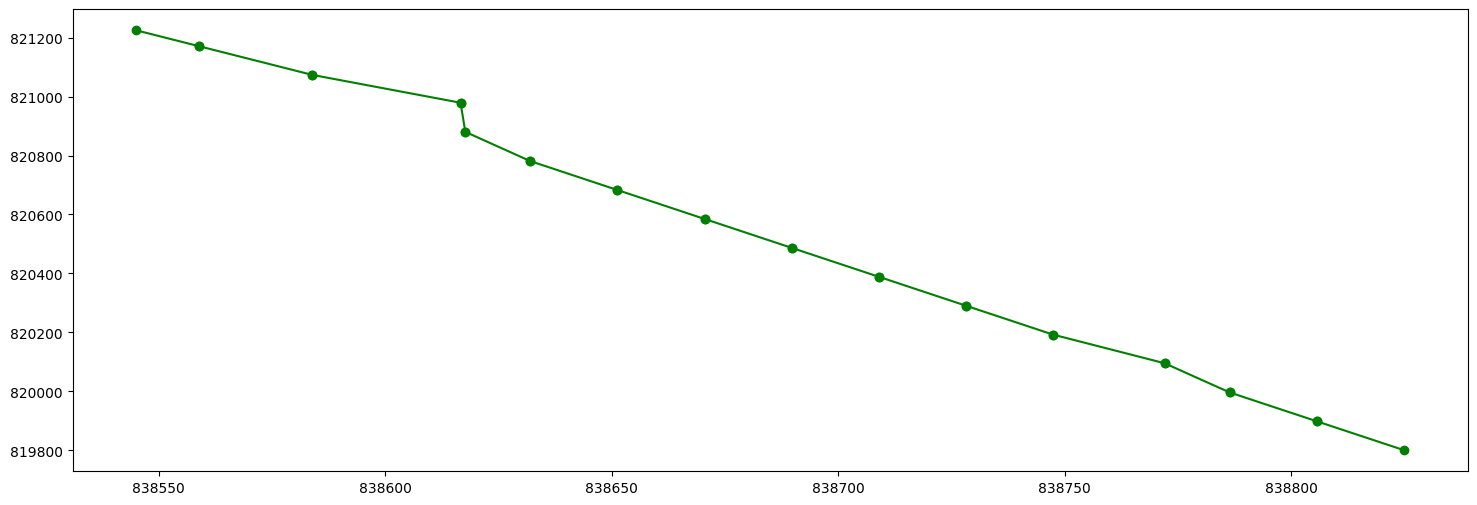

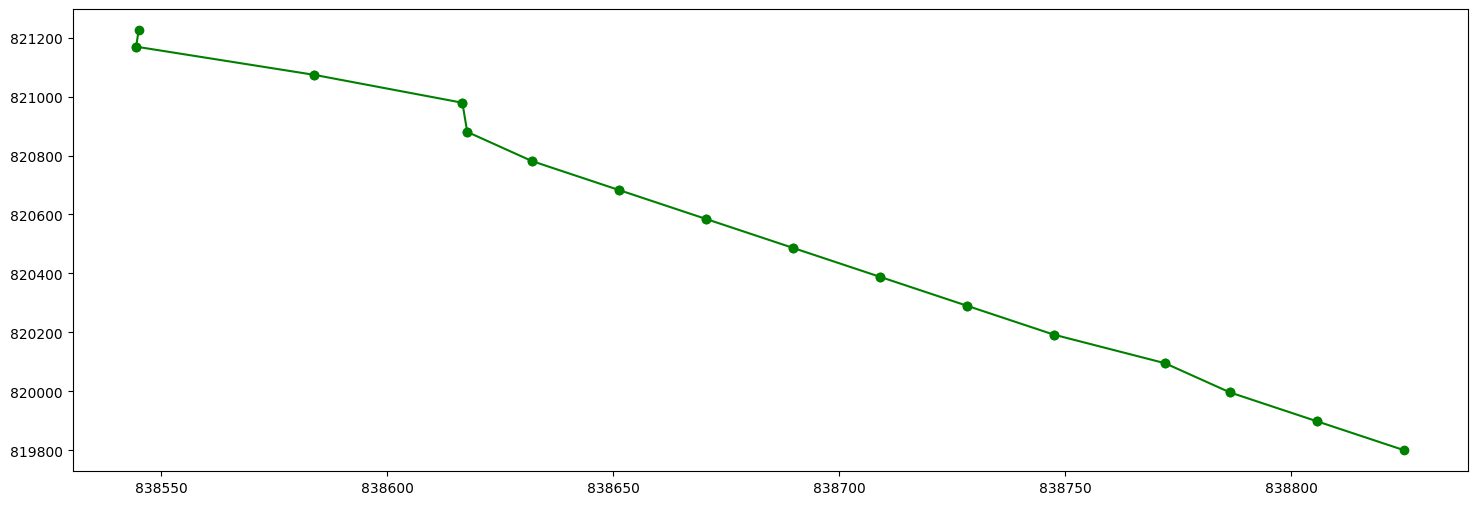

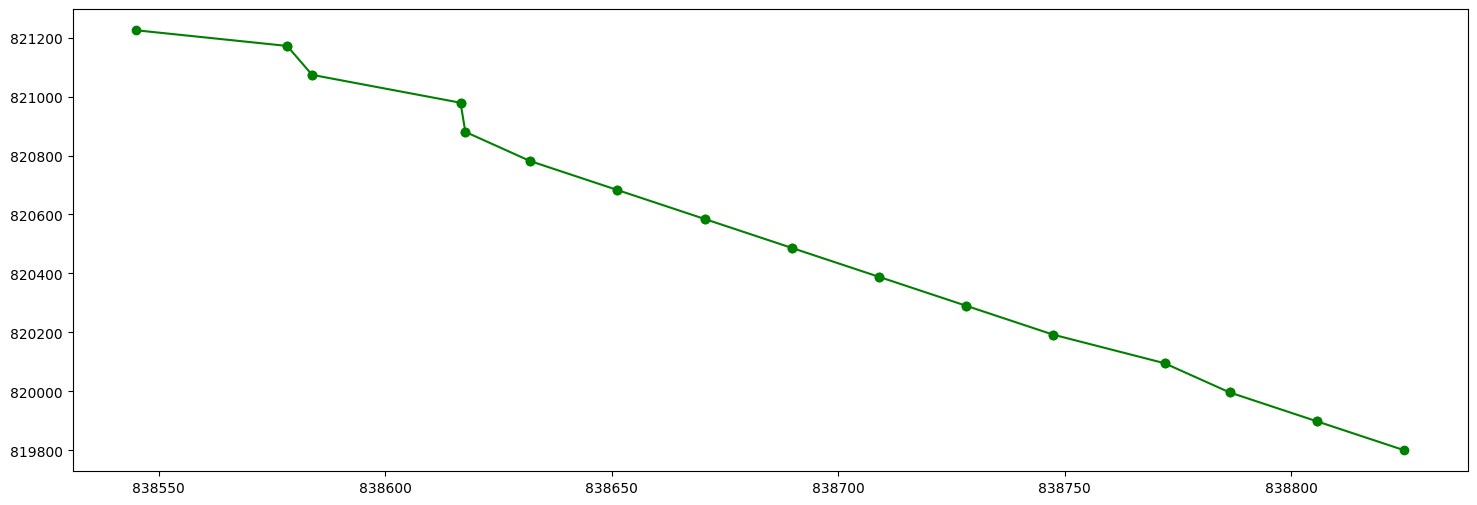

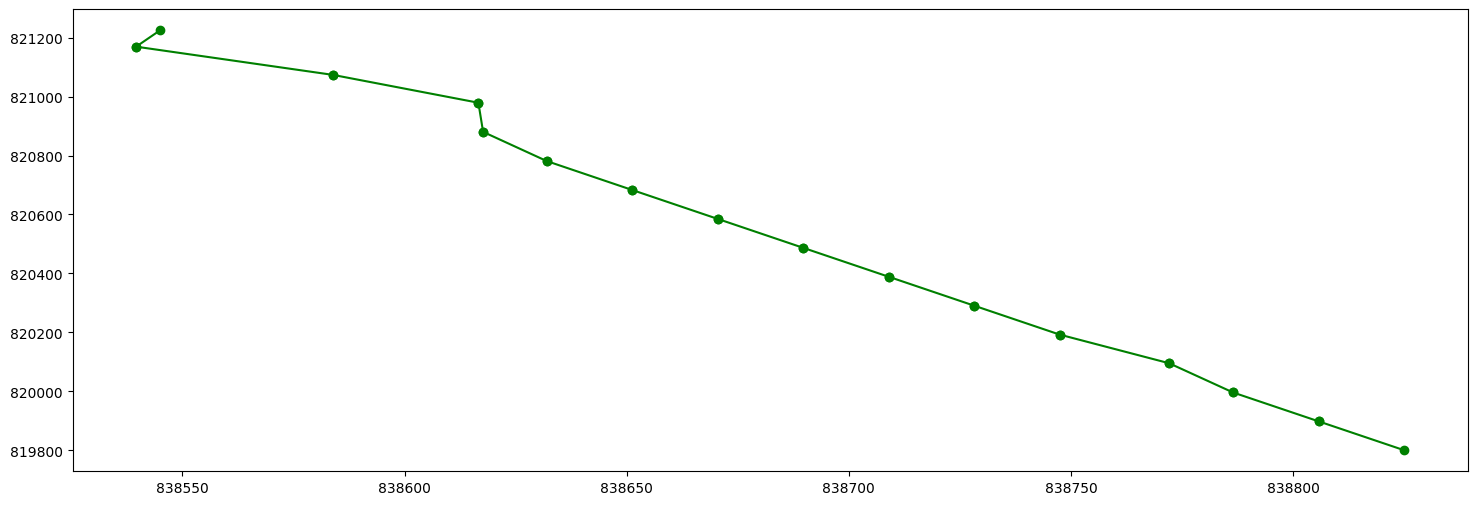

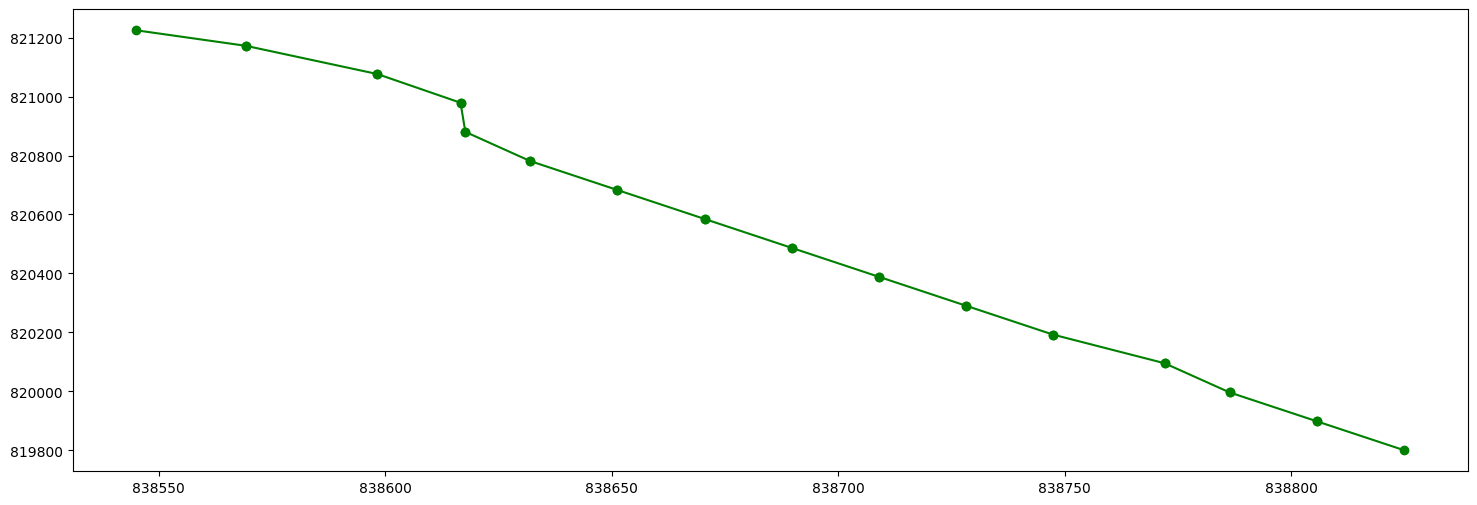

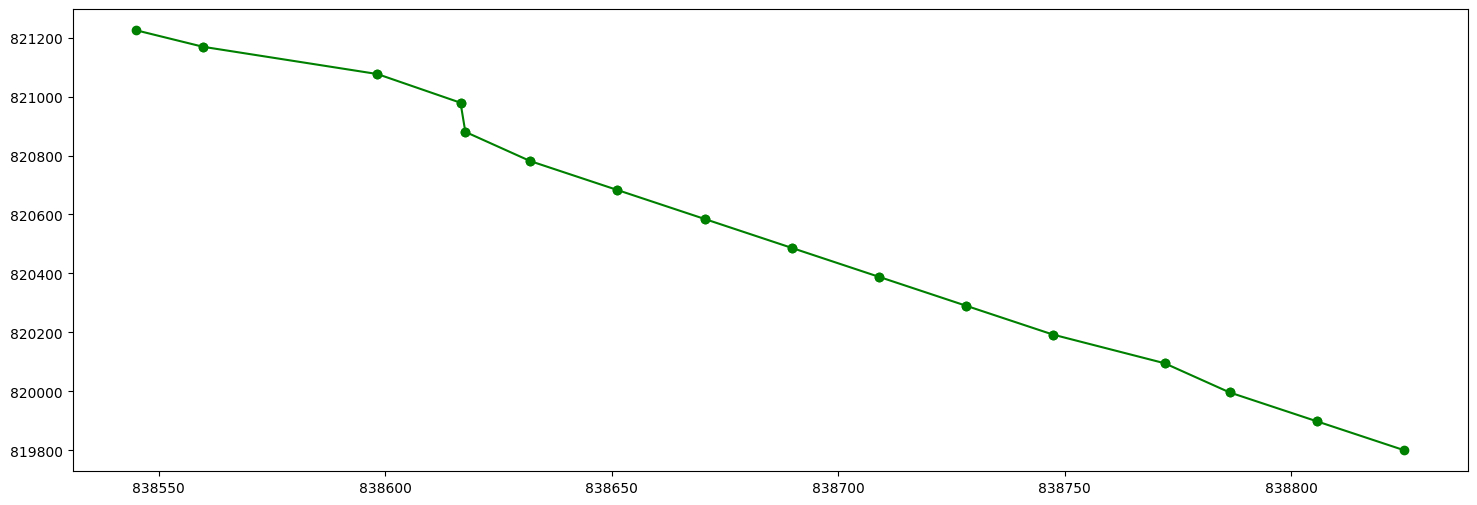

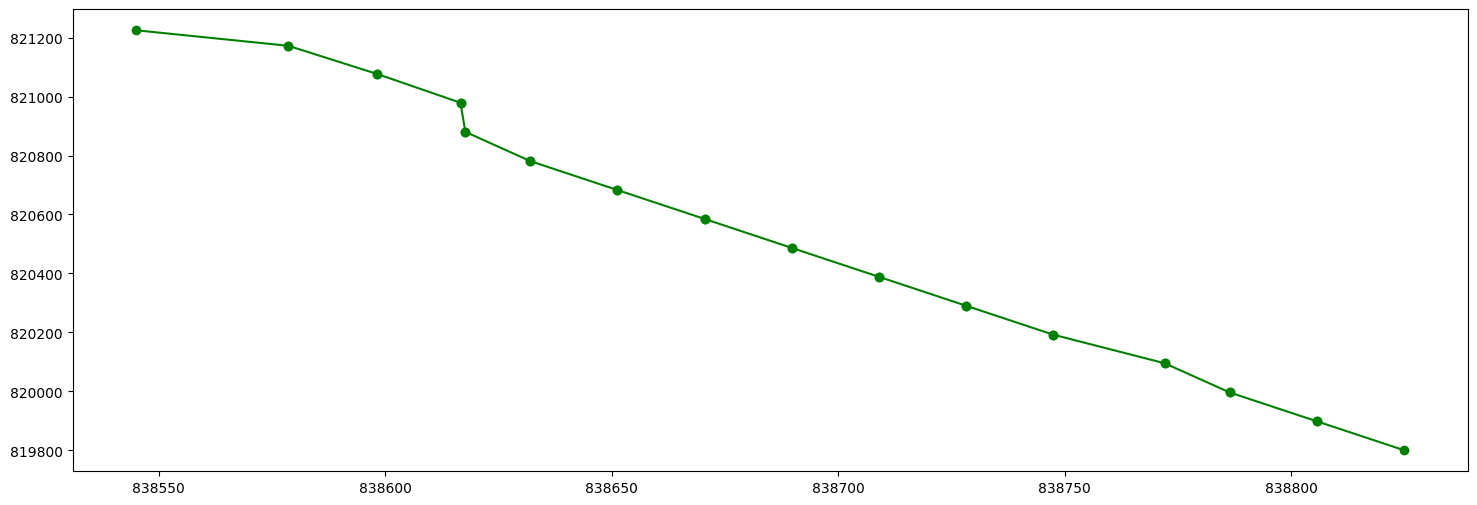

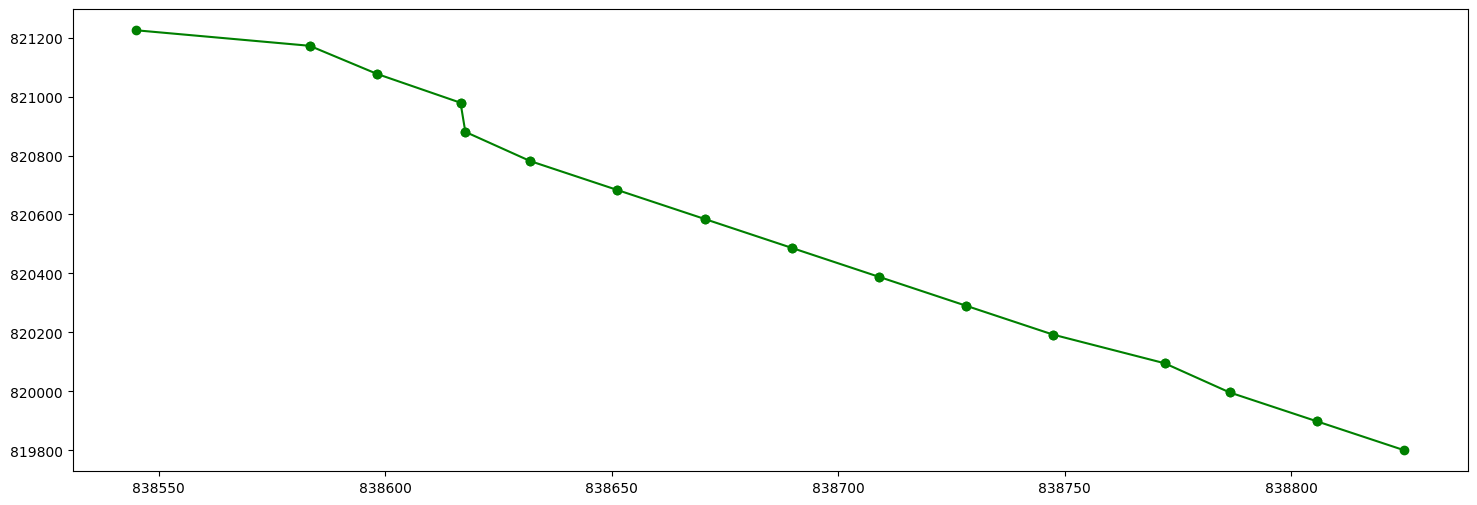

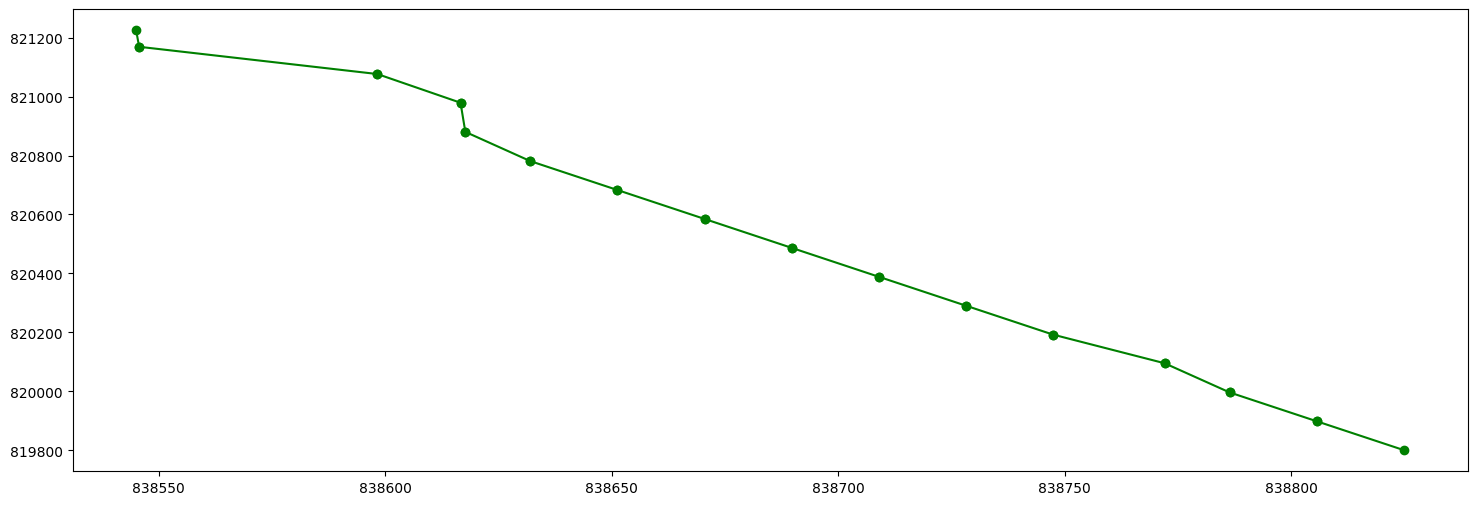

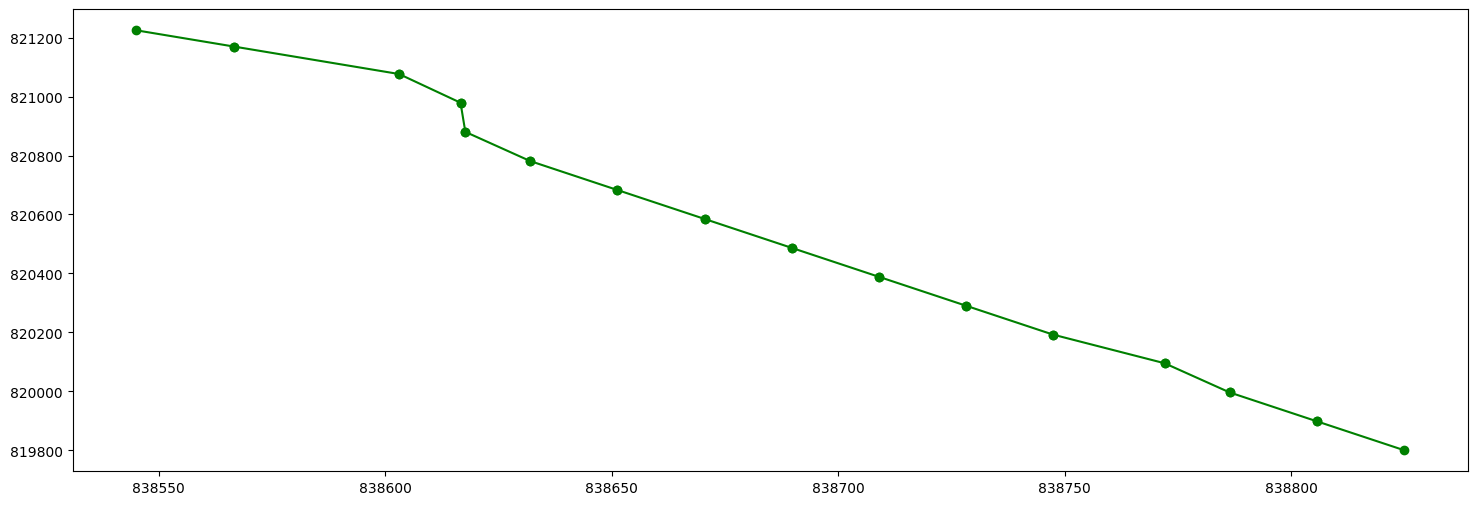

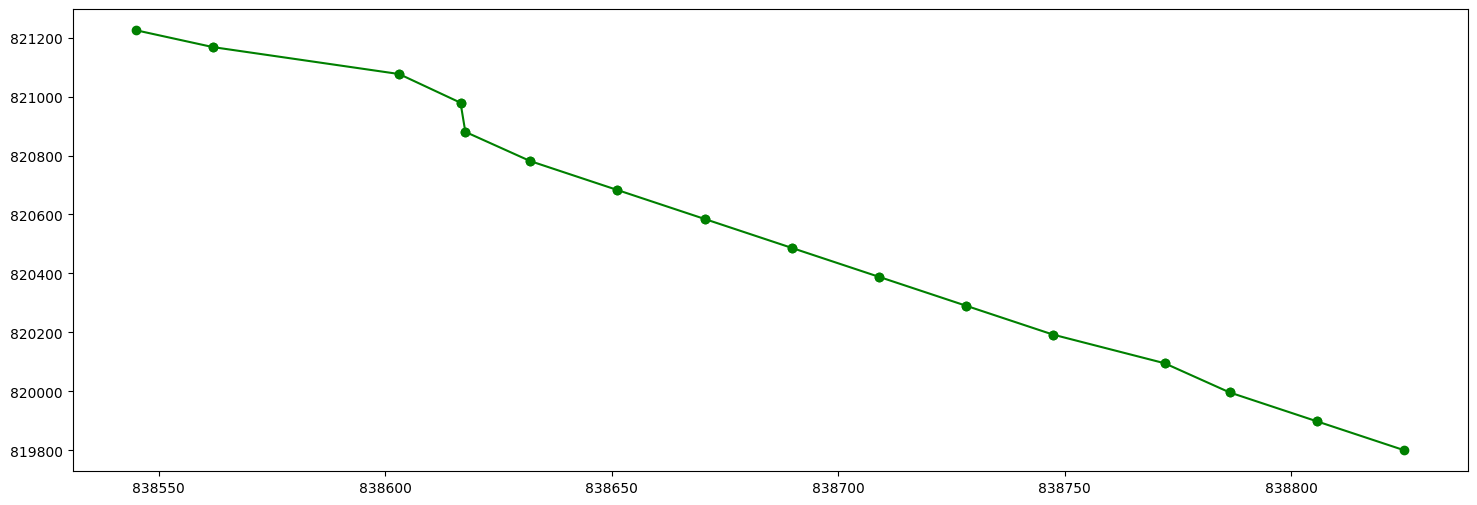

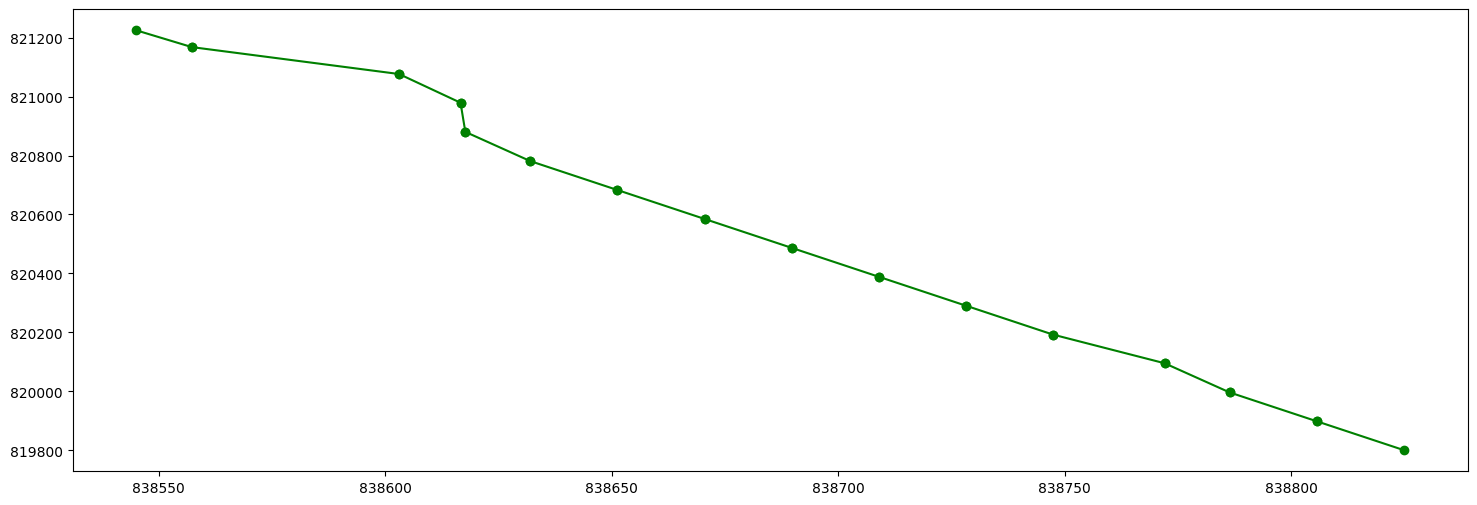

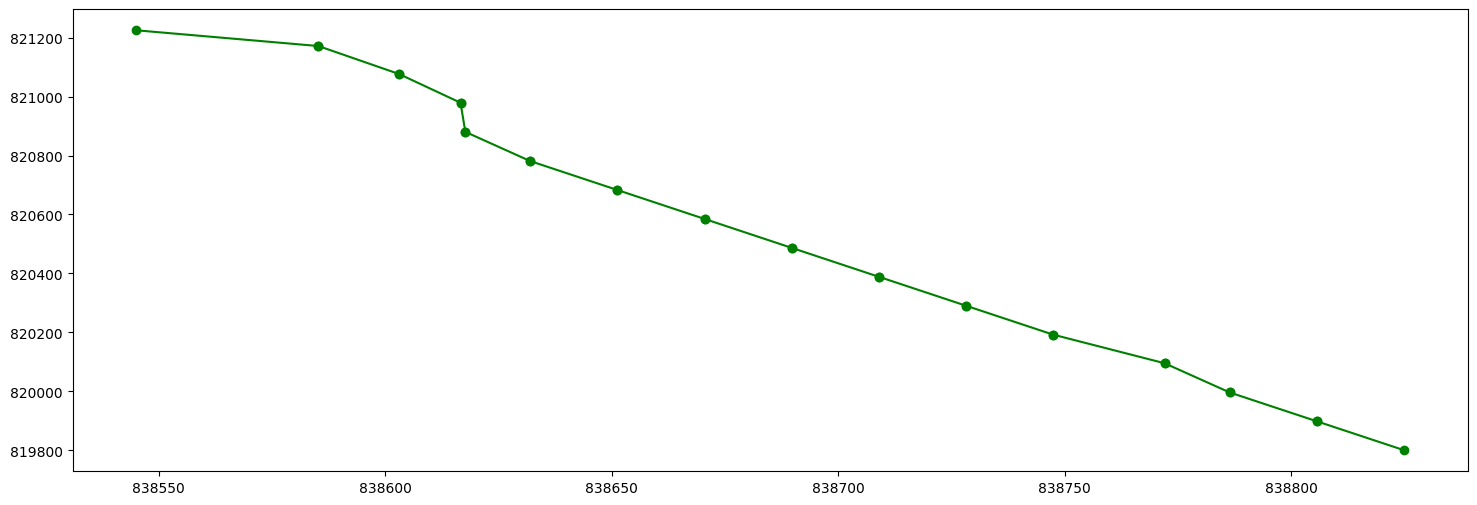

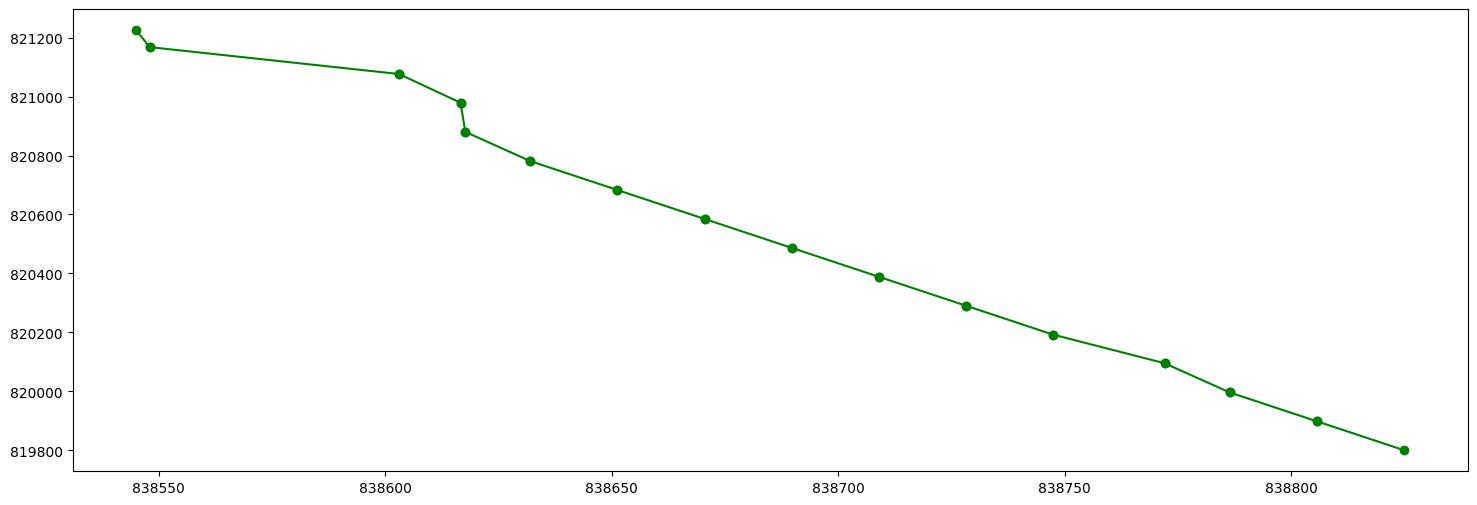

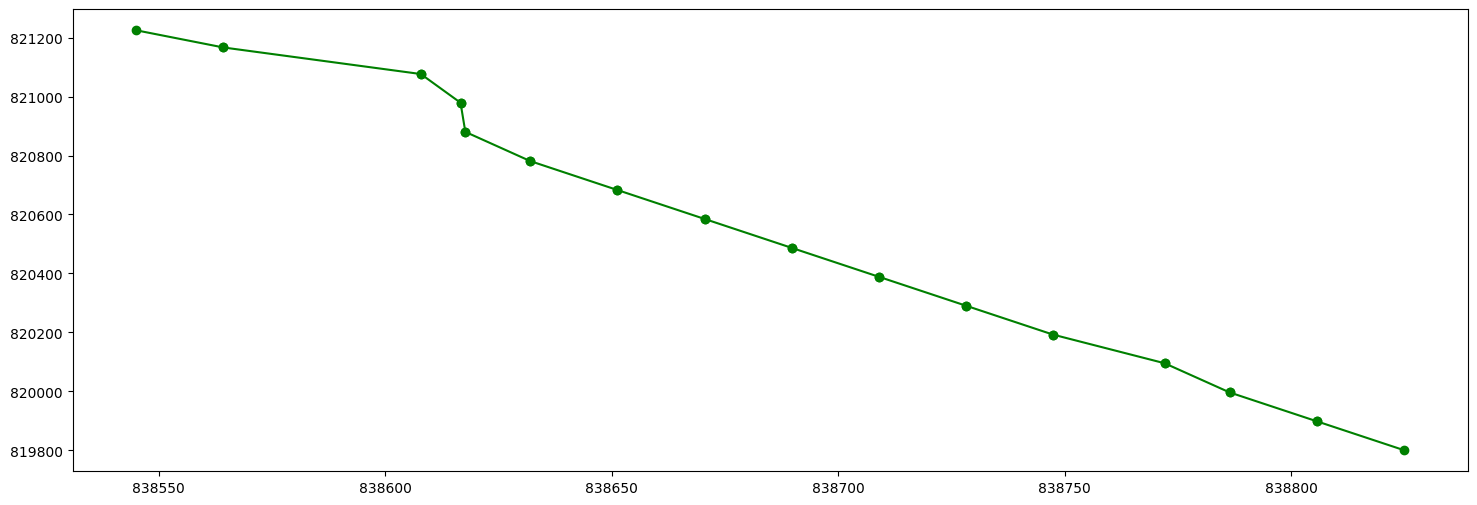

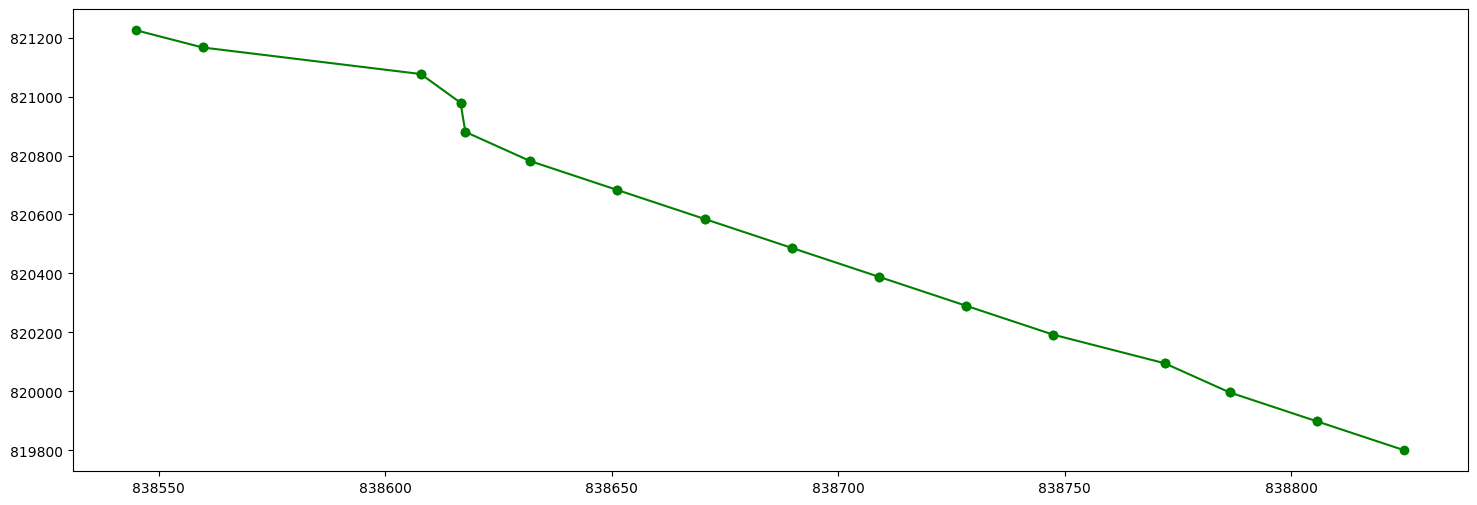

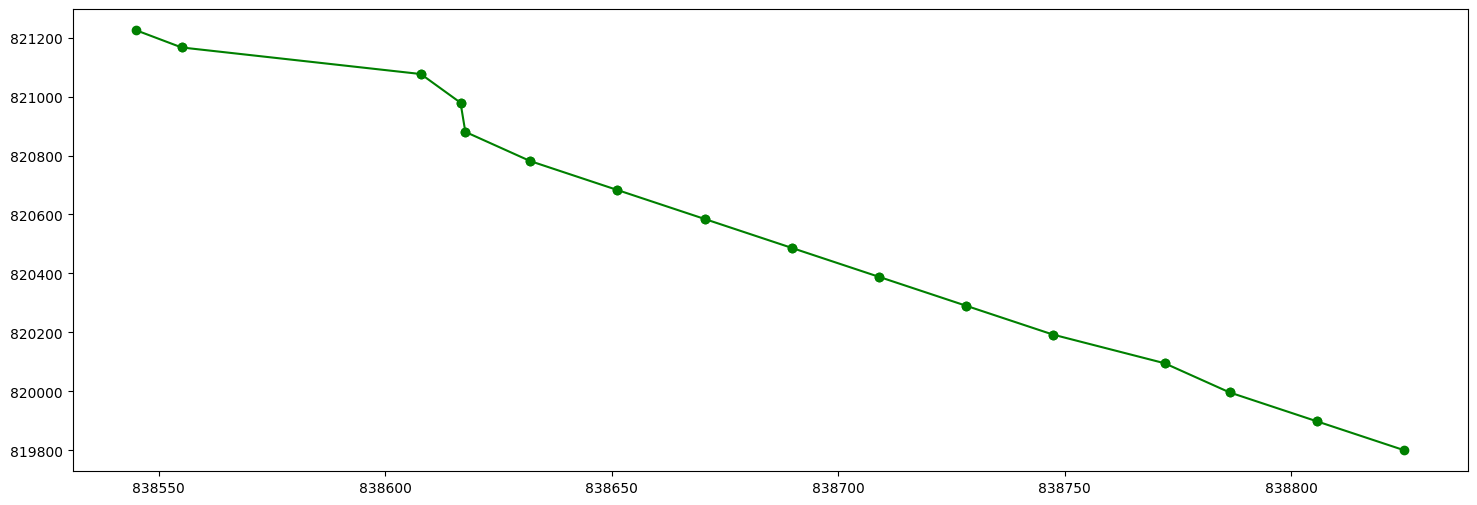

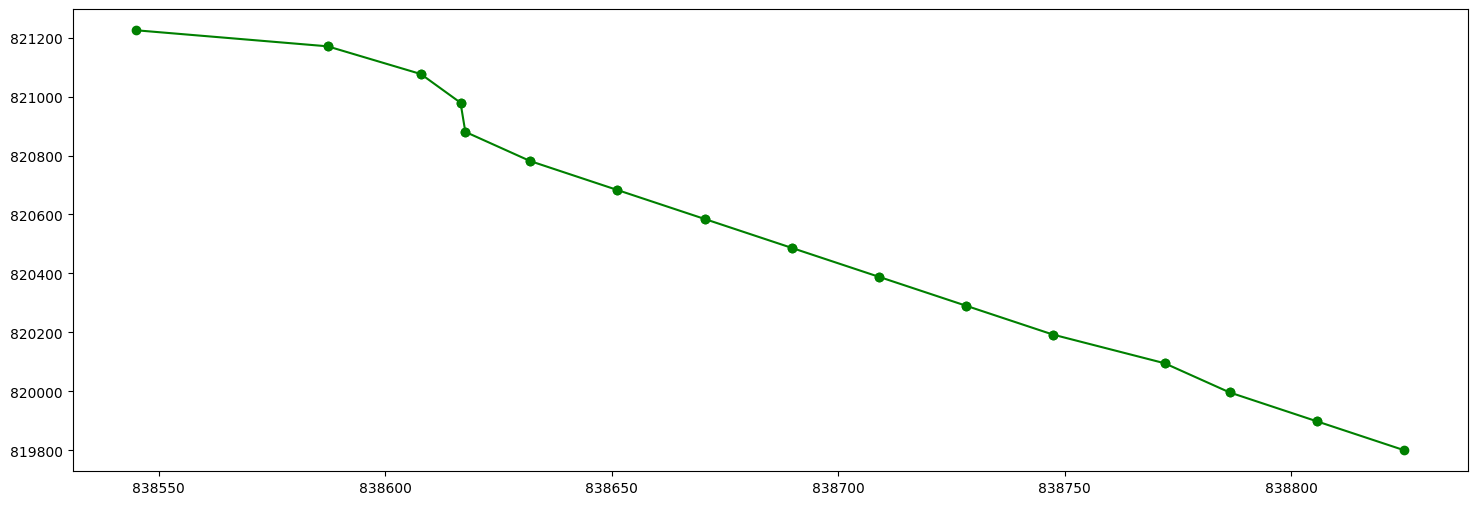

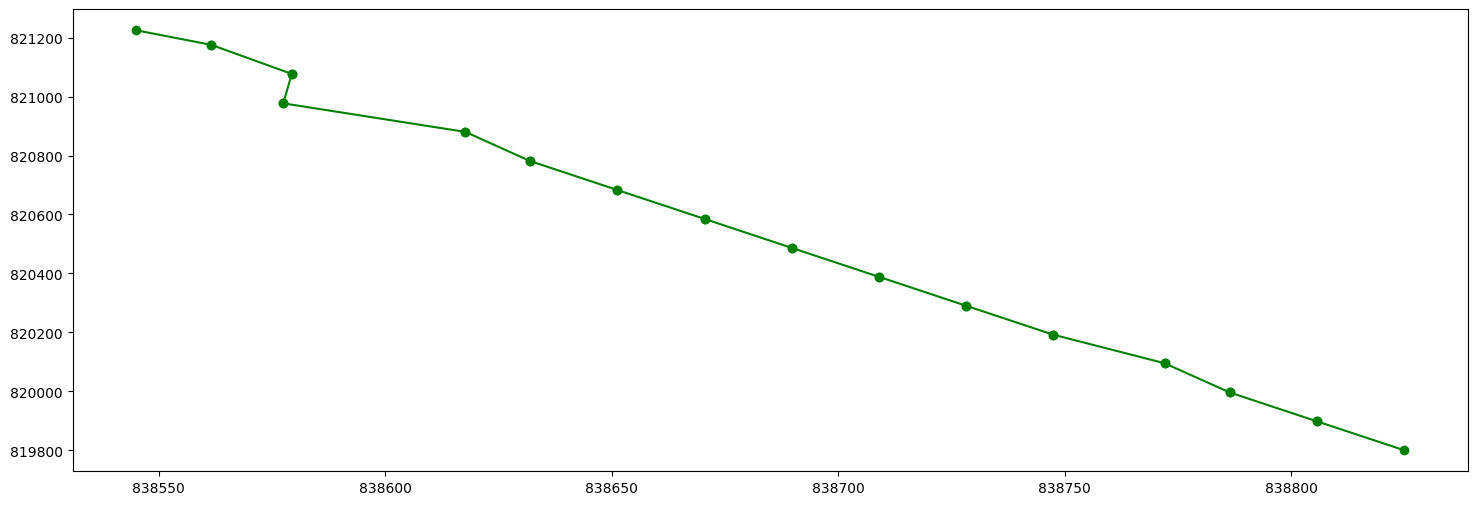

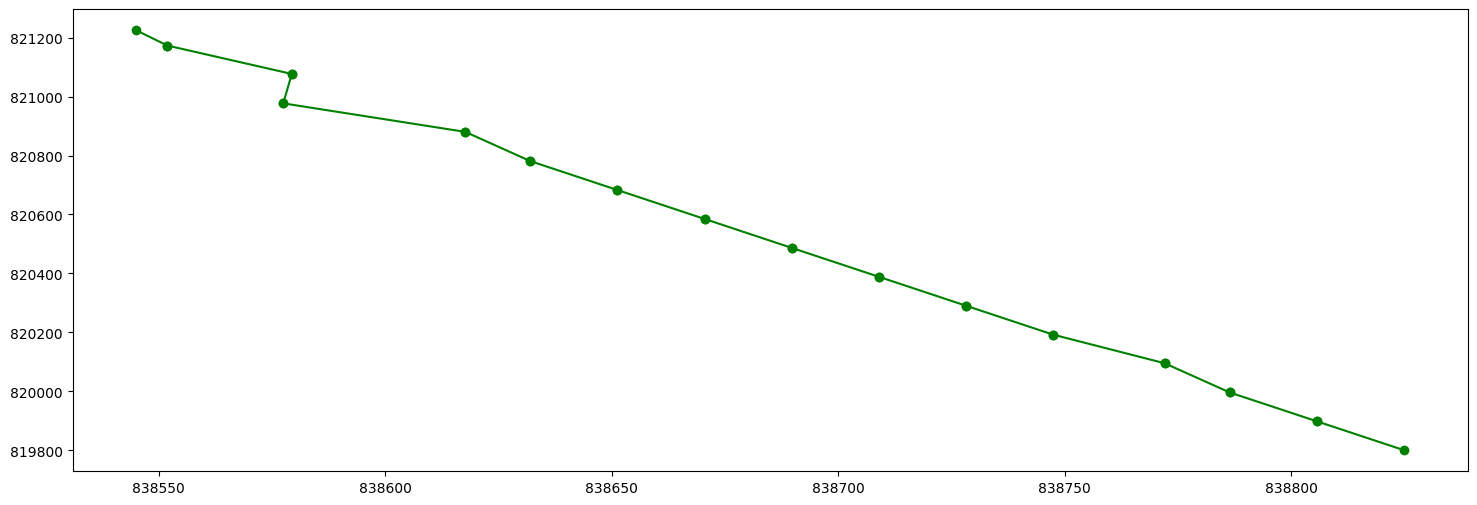

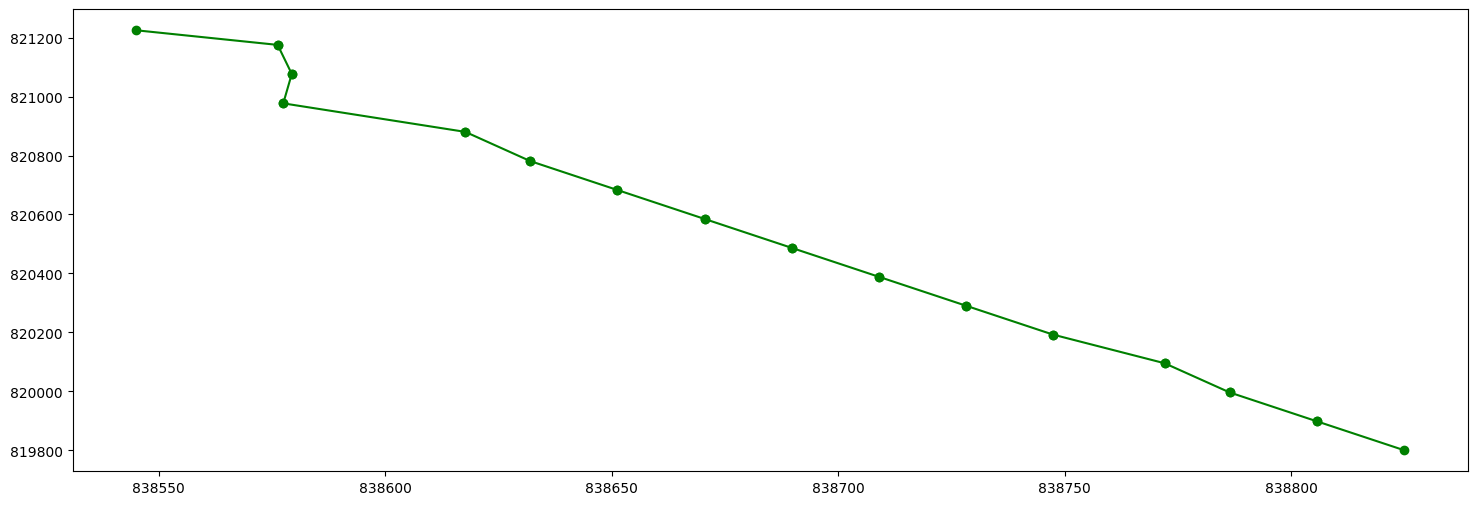

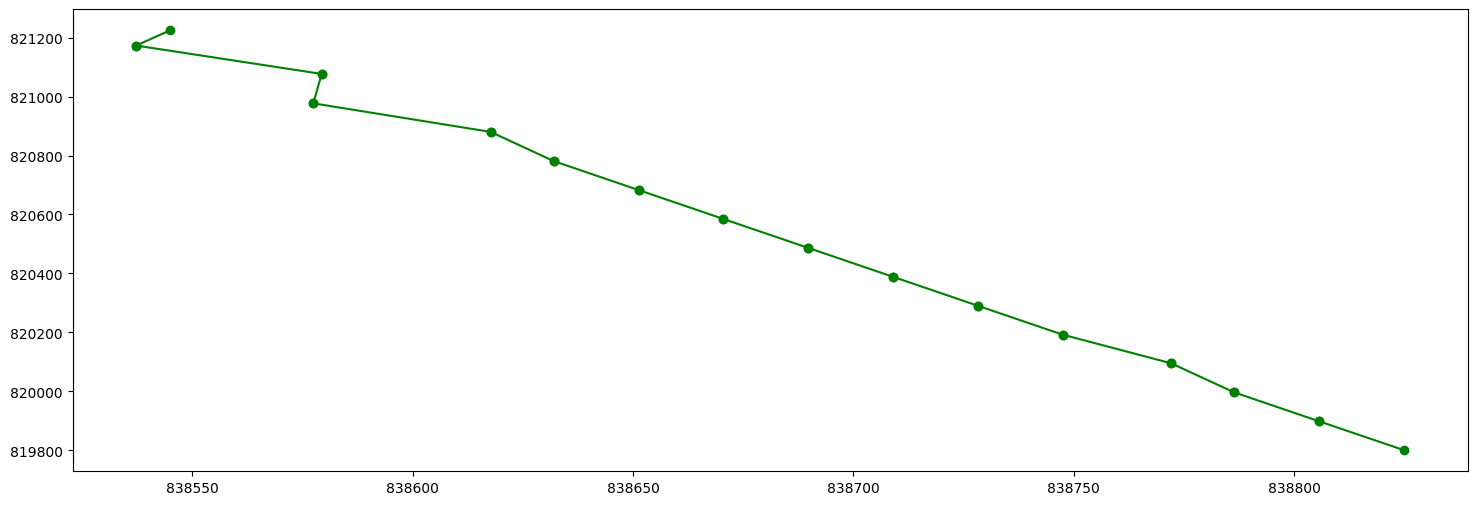

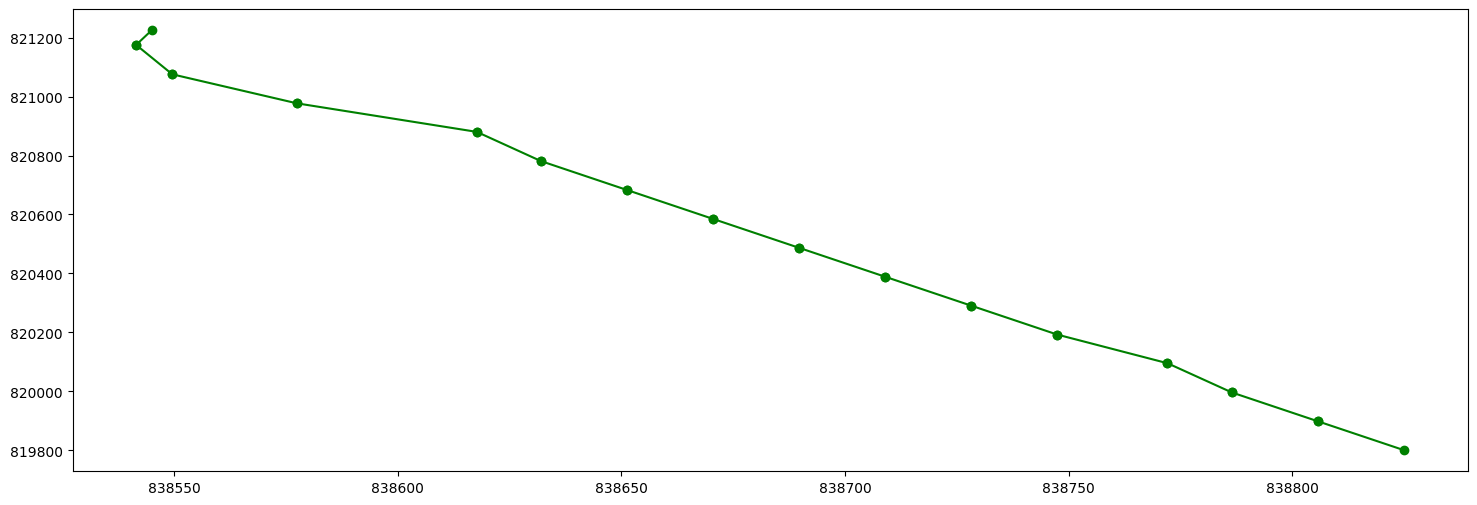

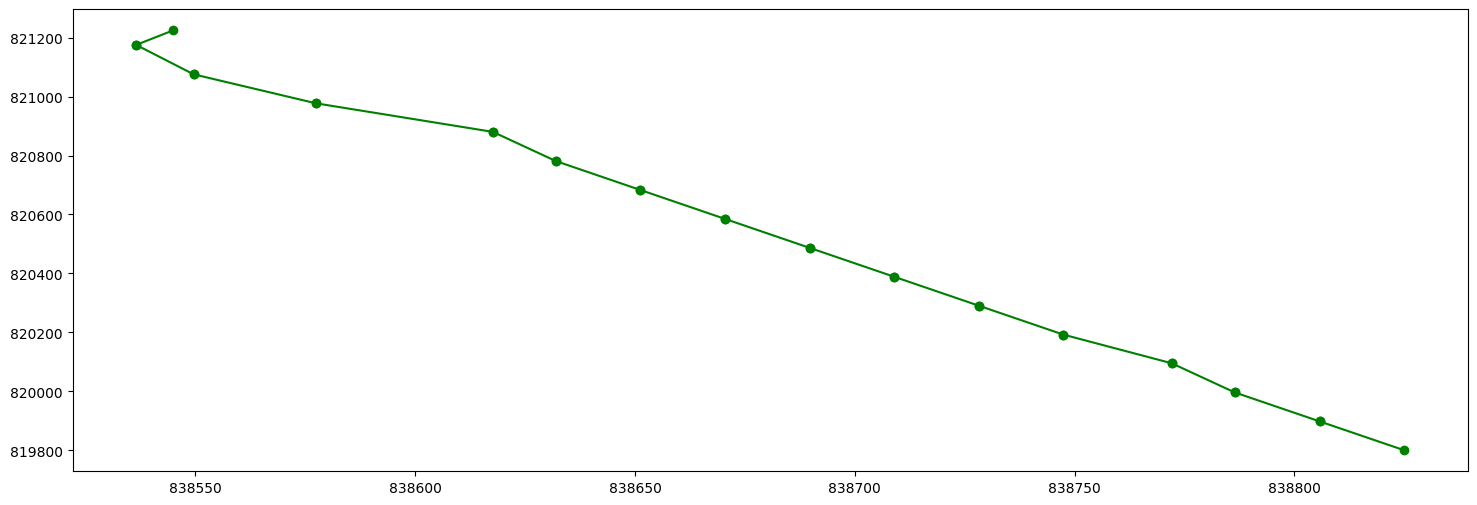

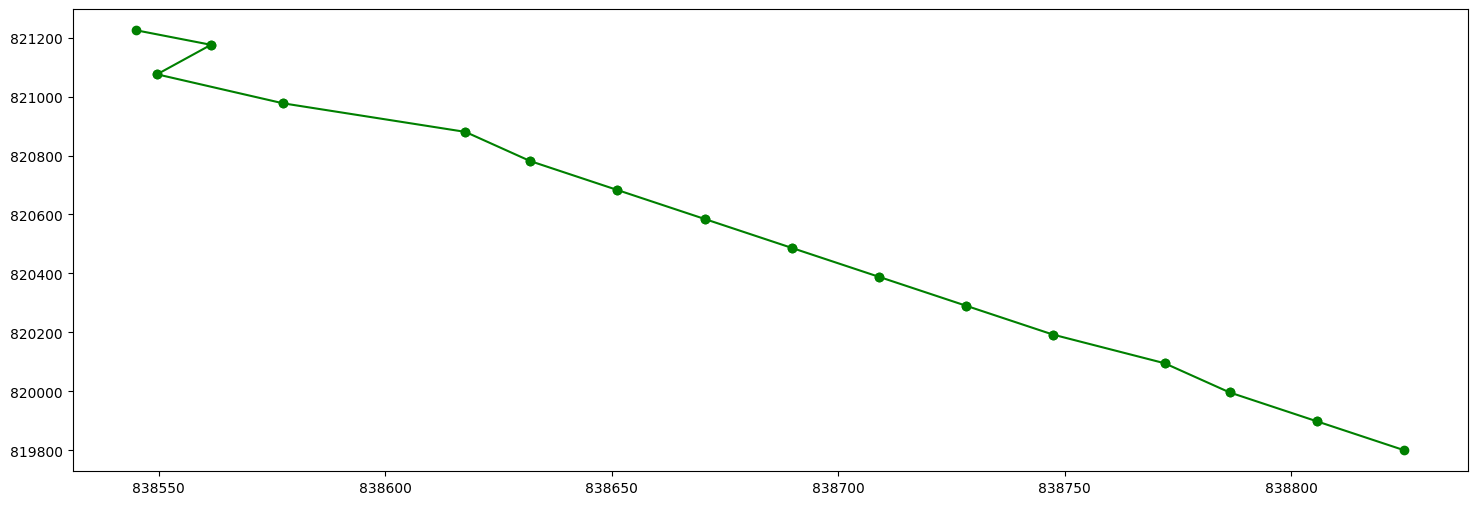

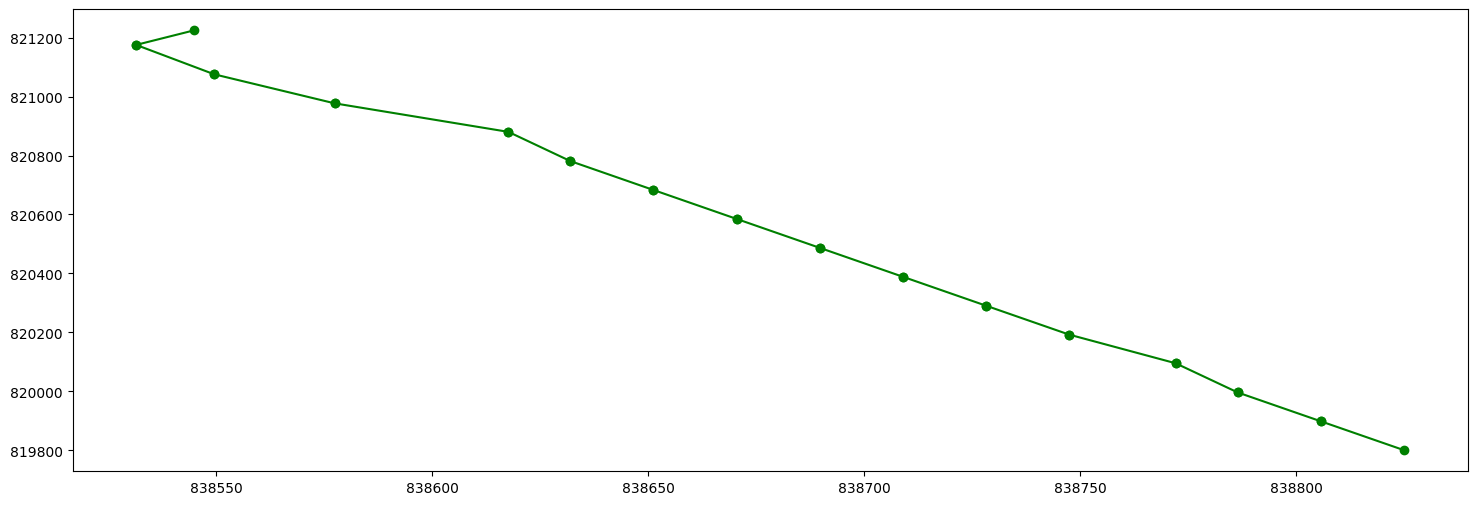

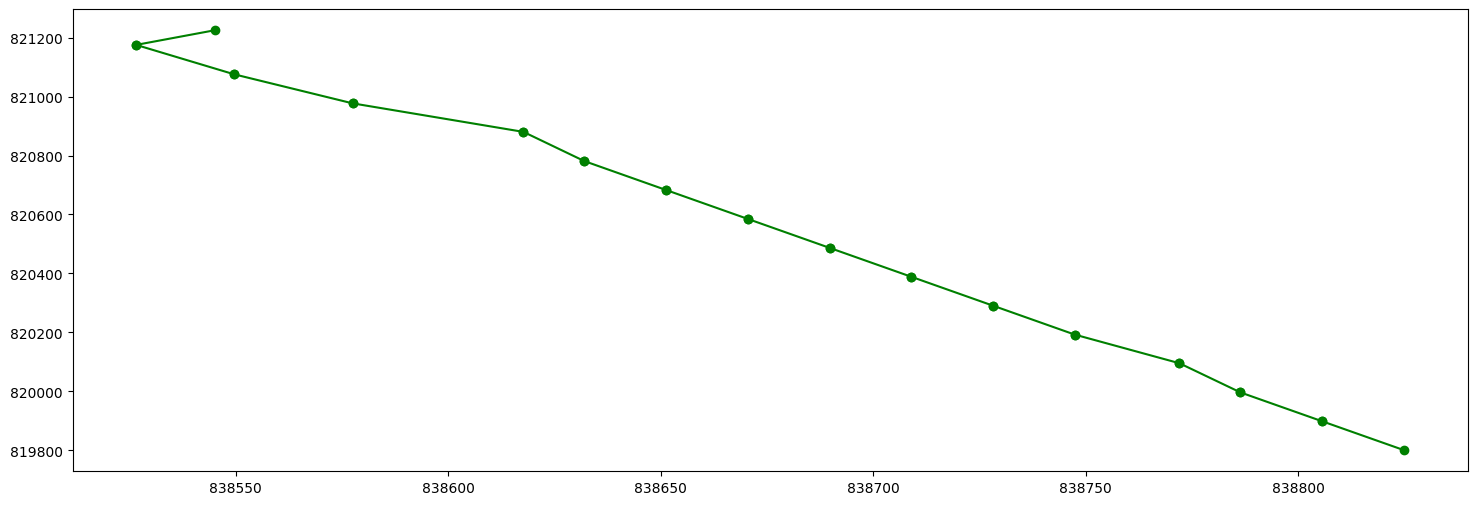

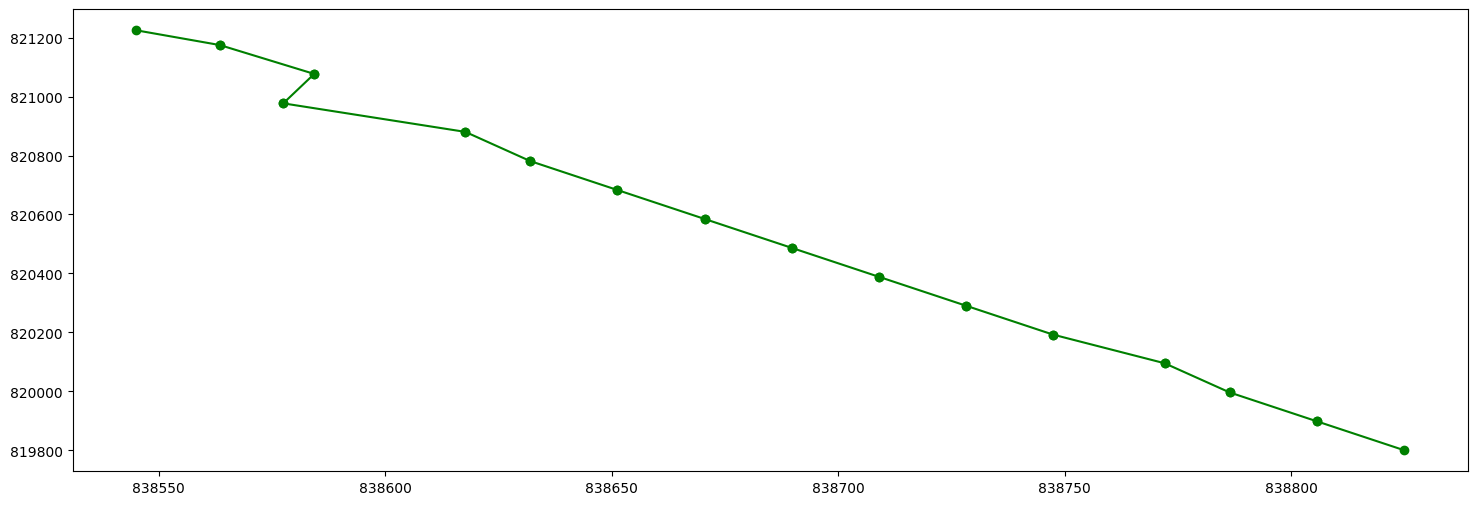

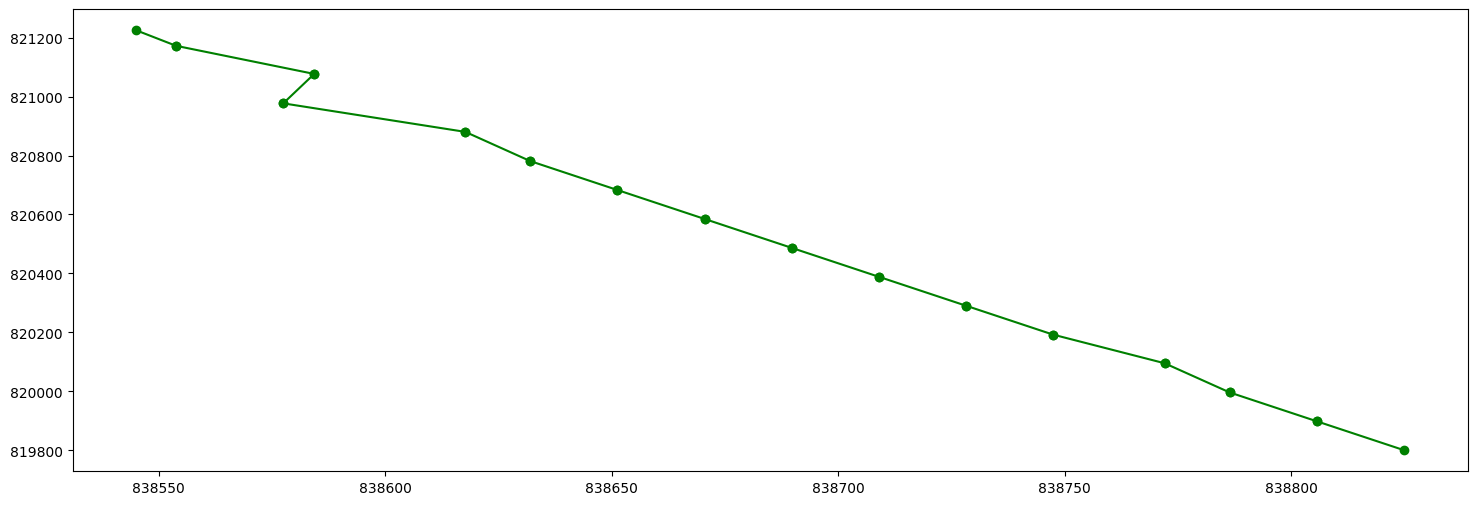

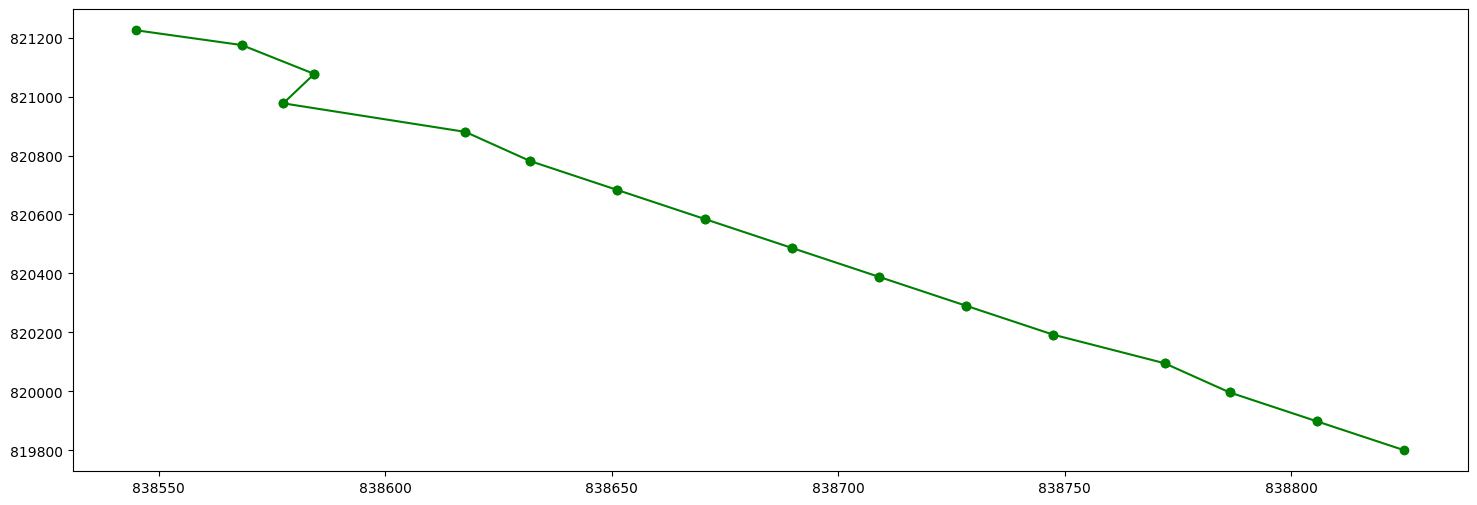

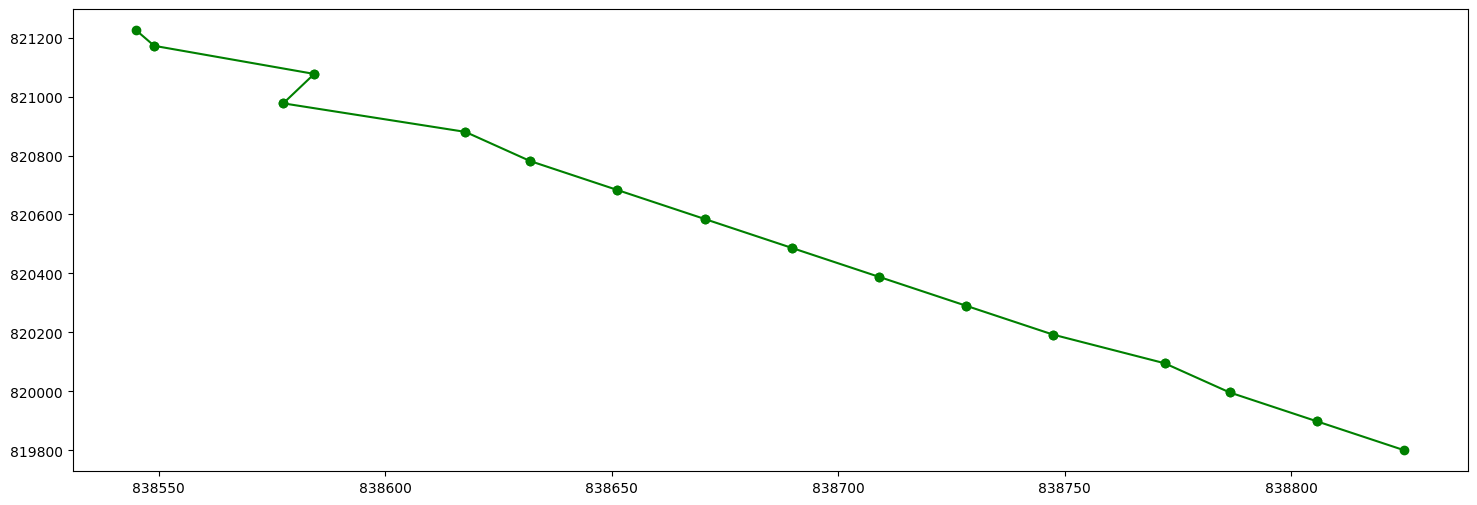

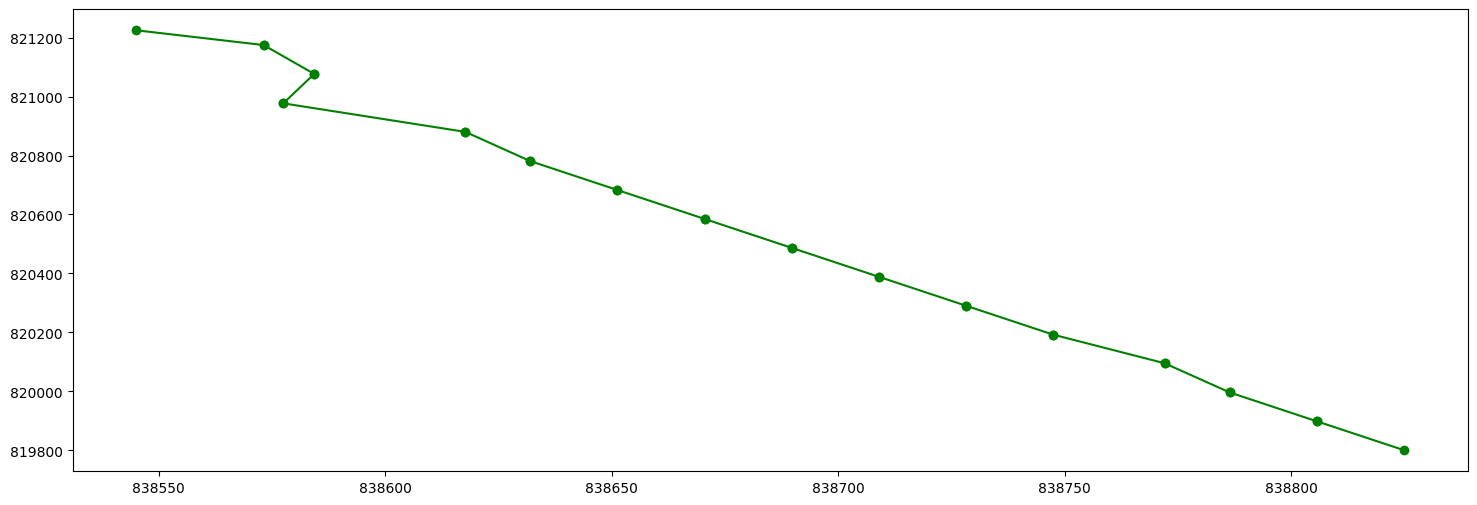

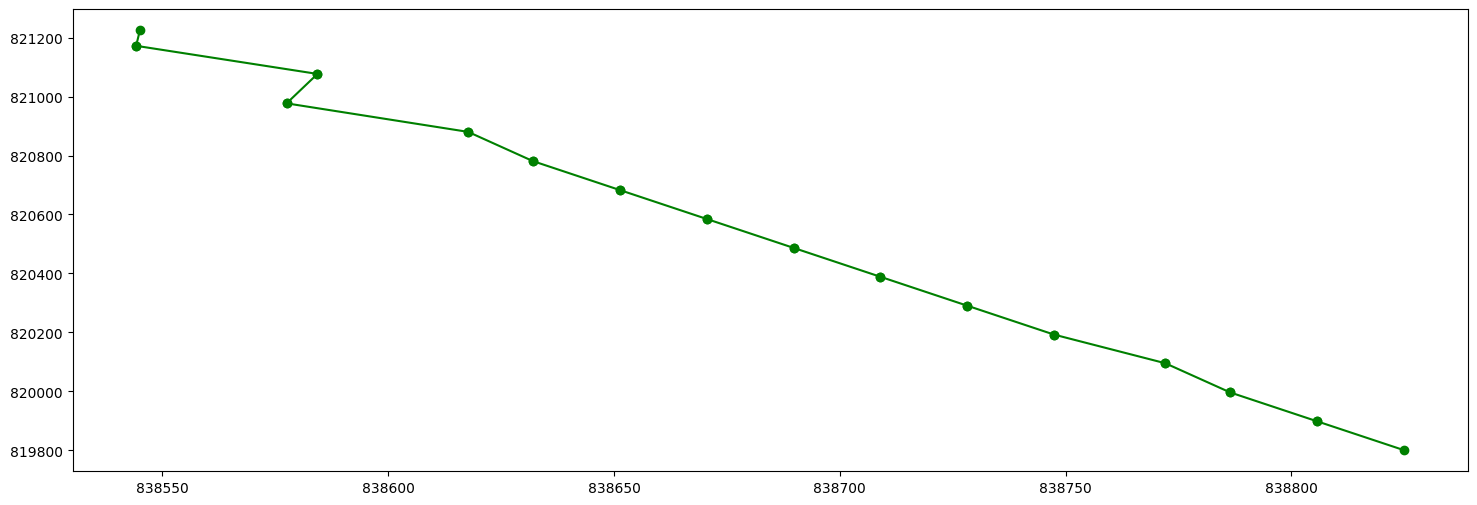

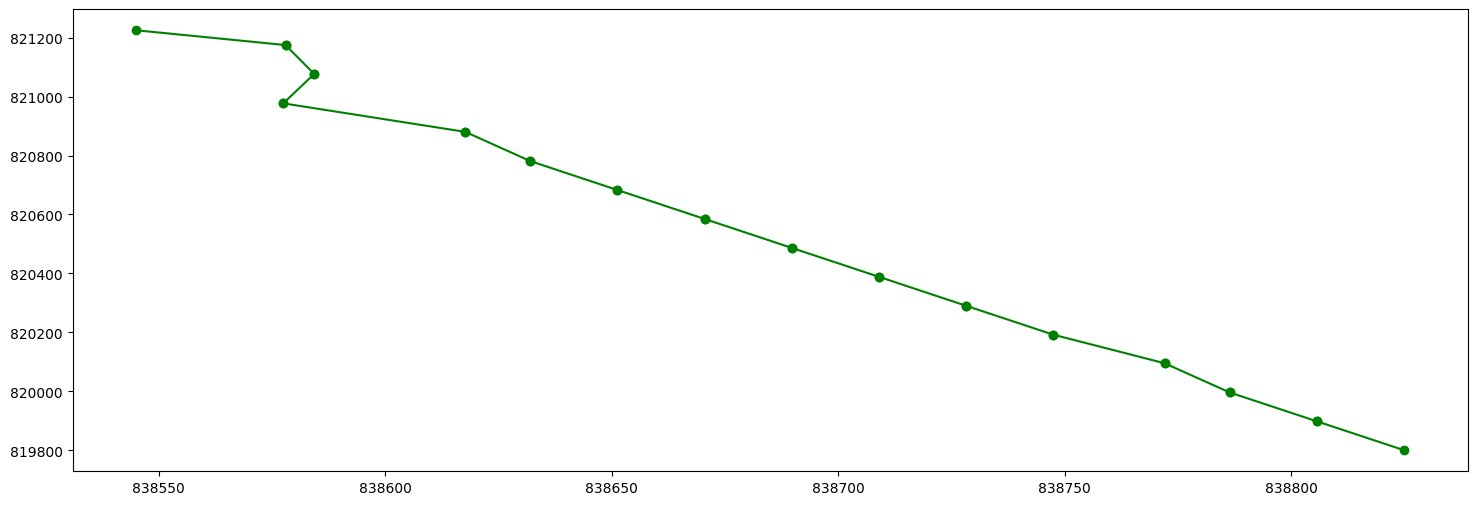

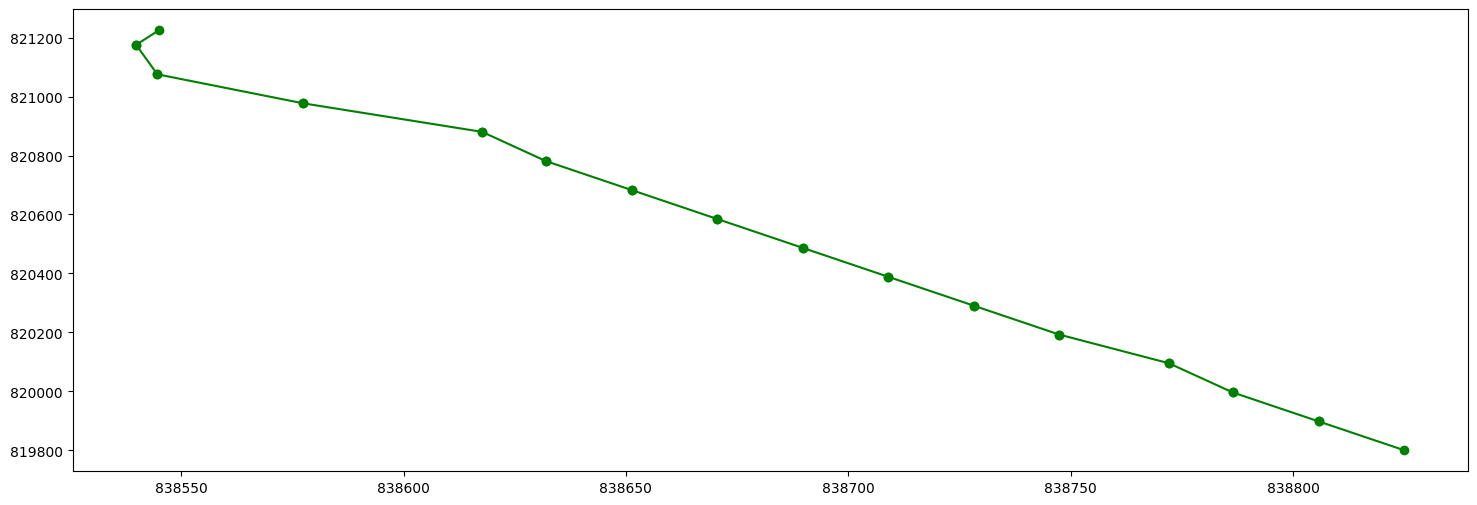

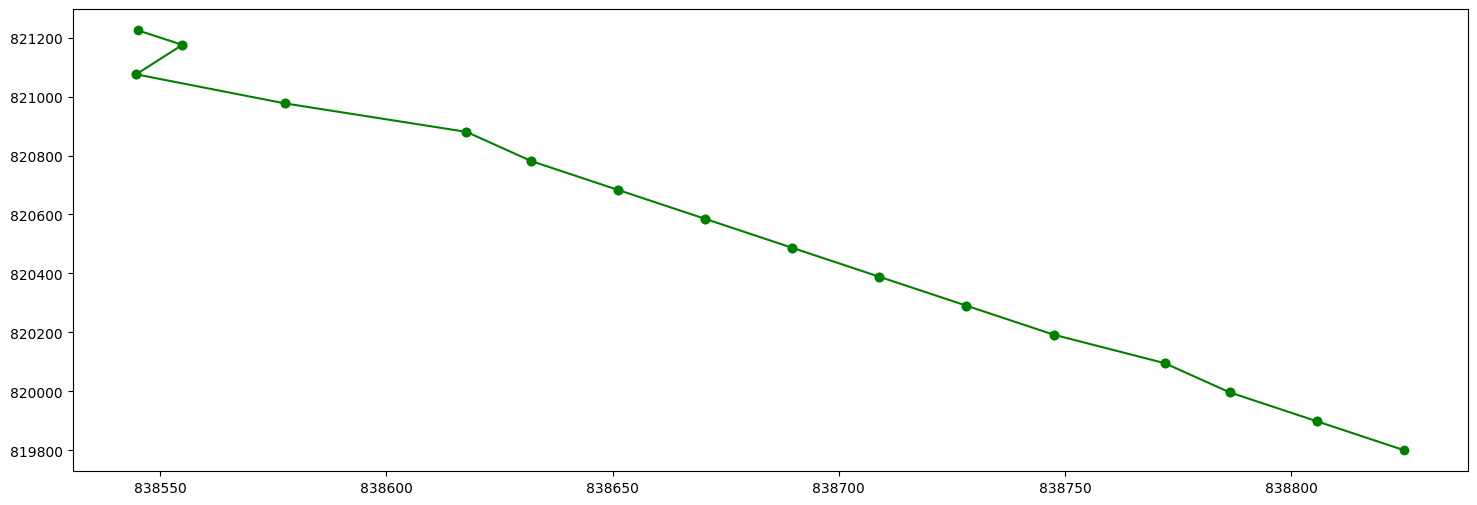

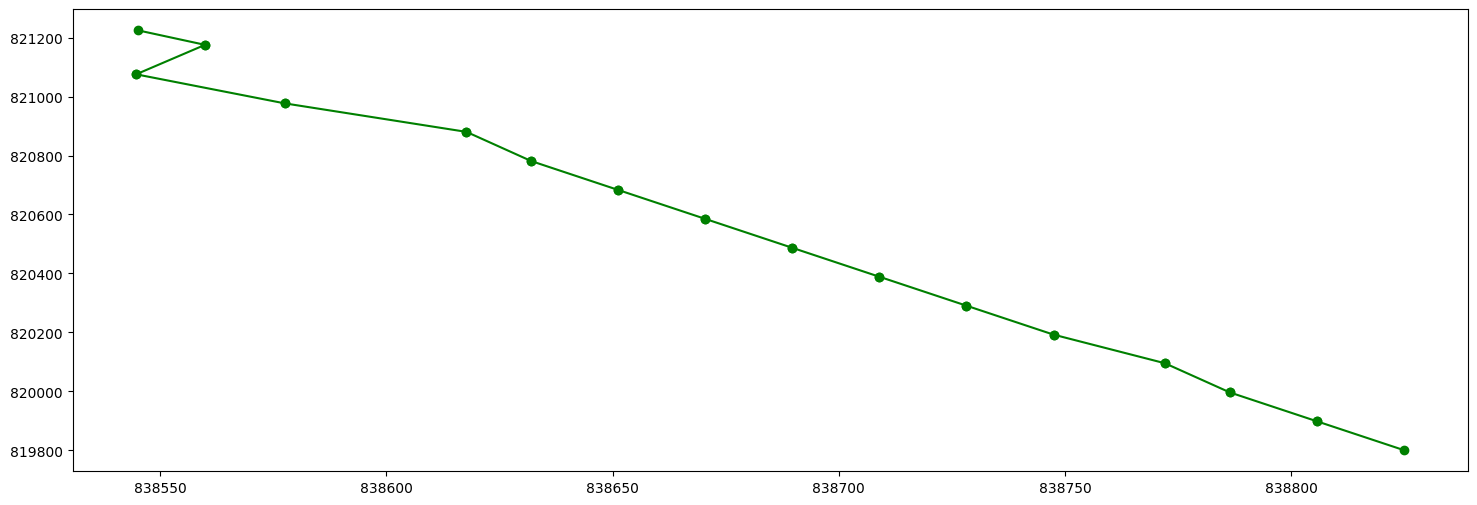

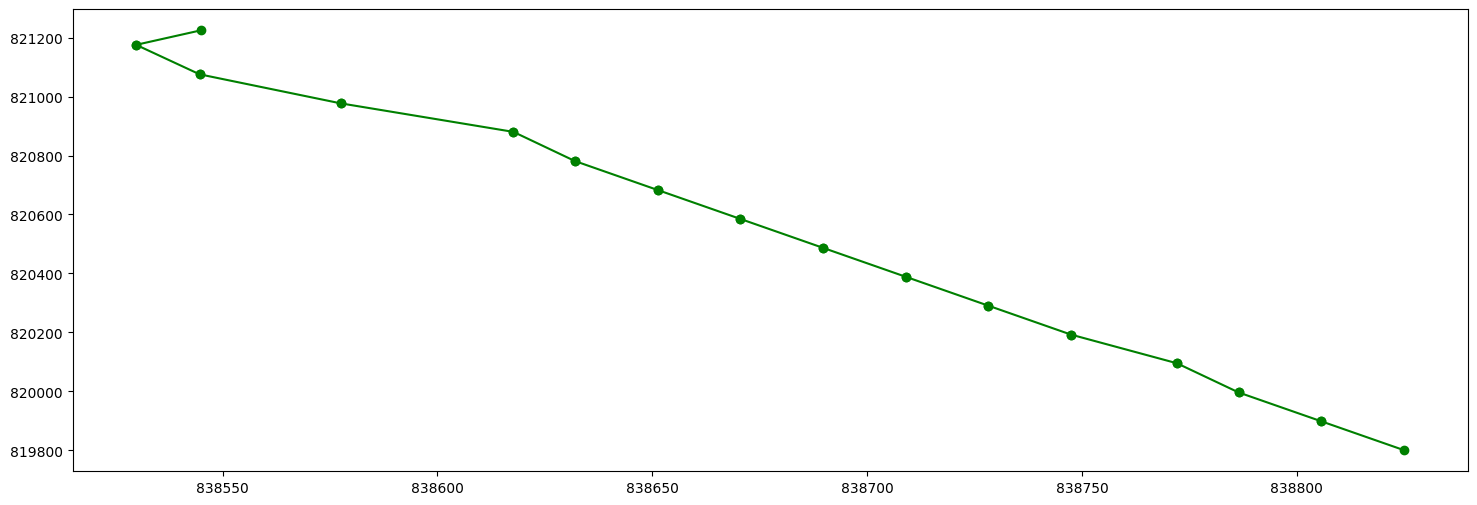

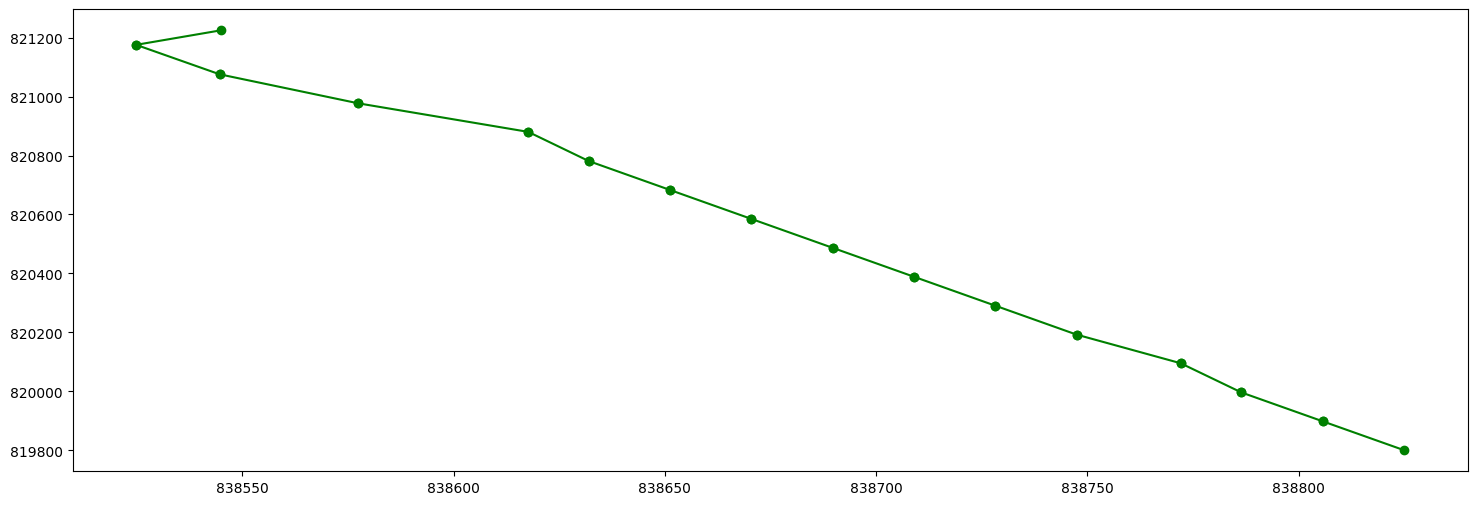

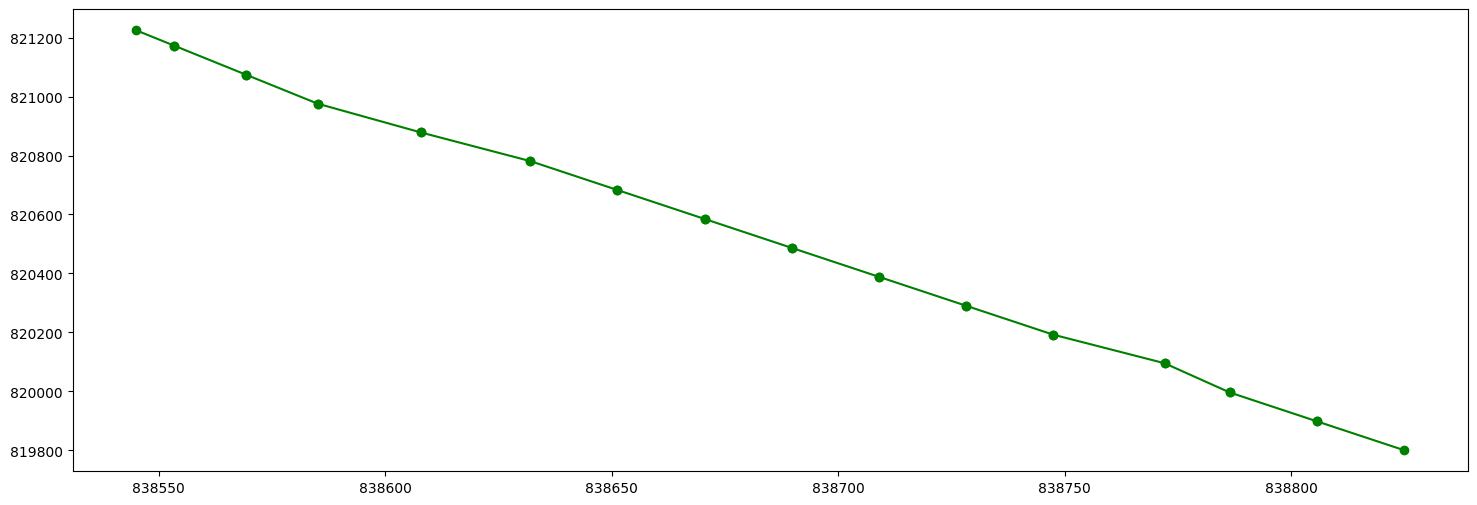

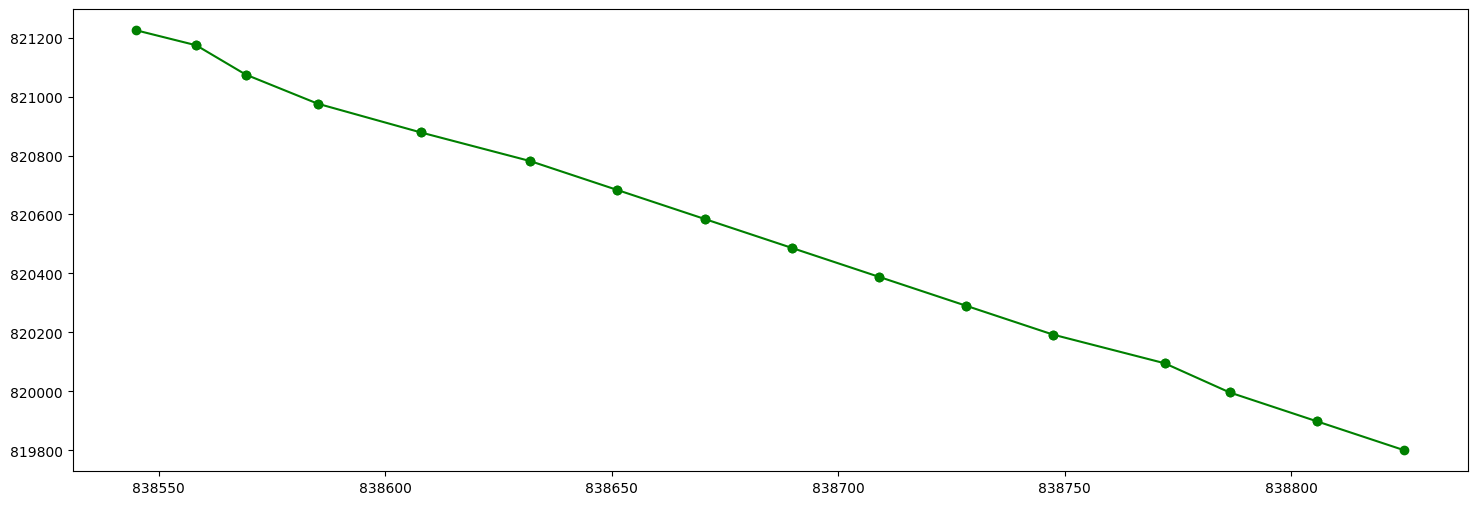

In [2]:
class Node(object):
    def __init__(self, x_meters, y_meters, parent_node=None, end_node=False):
        self.x_meters = x_meters
        self.y_meters = y_meters
        self.parent_node = parent_node
        self.end_node = end_node
        self.cost_of_current_node = self.calculate_cost_of_current_node()
        direction_to_current_b_x_meters = current_b_x_meters - x_meters
        direction_to_current_b_y_meters = current_b_y_meters - y_meters
        self.distance_to_current_b_meters = np.sqrt(np.power(direction_to_current_b_x_meters, 2) + np.power(direction_to_current_b_y_meters, 2))
        if self.distance_to_current_b_meters > step_length_meters:
            unit_direction_to_current_b_x = direction_to_current_b_x_meters / self.distance_to_current_b_meters
            unit_direction_to_current_b_y = direction_to_current_b_y_meters / self.distance_to_current_b_meters
            self.scaled_direction_to_current_b_x_meters = step_length_meters * unit_direction_to_current_b_x
            self.scaled_direction_to_current_b_y_meters = step_length_meters * unit_direction_to_current_b_y
            
            orthogonal_to_unit_direction_to_current_b_x_meters = 1.0
            orthogonal_to_unit_direction_to_current_b_y_meters = -unit_direction_to_current_b_x / unit_direction_to_current_b_y
            length_of_orthogonal_to_unit_direction_to_current_b_meters = np.sqrt(1.0 + np.power(-unit_direction_to_current_b_x / unit_direction_to_current_b_y, 2))
            self.unit_orthogonal_to_unit_direction_to_current_b_x = orthogonal_to_unit_direction_to_current_b_x_meters / length_of_orthogonal_to_unit_direction_to_current_b_meters
            self.unit_orthogonal_to_unit_direction_to_current_b_y = orthogonal_to_unit_direction_to_current_b_y_meters / length_of_orthogonal_to_unit_direction_to_current_b_meters
            self.scaled_orthogonal_to_unit_direction_to_current_b_x_meters = triangle_floor_interval_length_meters * self.unit_orthogonal_to_unit_direction_to_current_b_x
            self.scaled_orthogonal_to_unit_direction_to_current_b_y_meters = triangle_floor_interval_length_meters * self.unit_orthogonal_to_unit_direction_to_current_b_y
    
        self.descendant_id_descendant_node_mapping = dict()

    def calculate_cost_of_current_node(self):
        # if self.parent_node is None:
        #     # self.parent_node is None if this is the start_node.
        #     return 0.0
        # else:
        #     return 1.0
        random_number = np.random.uniform(0, 1)
        if random_number > 0.5:
            return 1.0
        else:
            return 0.0
        return random_number

    def generate_new_descendant(self):
        if self.distance_to_current_b_meters <= step_length_meters:
            if len(self.descendant_id_descendant_node_mapping.keys()) == 0:
                new_descendant_id = 0
                new_descendant = Node(x_meters=current_b_x_meters, y_meters=current_b_y_meters, parent_node=self, end_node=True)
                self.descendant_id_descendant_node_mapping[new_descendant_id] = new_descendant
                return new_descendant
            else:
                return None
        else:
            if len(self.descendant_id_descendant_node_mapping.keys()) == 0:
                new_descendant_id = 0
            else:
                new_descendant_id = max(list(self.descendant_id_descendant_node_mapping.keys())) + 1
    
            if new_descendant_id == maximum_number_of_descendants_per_node:
                return None
            else:
                if new_descendant_id == 0:
                    new_descendant = Node(x_meters=self.x_meters + self.scaled_direction_to_current_b_x_meters, y_meters=self.y_meters + self.scaled_direction_to_current_b_y_meters, parent_node=self, end_node=False)
                elif new_descendant_id % 2 == 1:
                    new_descendant = Node(x_meters=self.descendant_id_descendant_node_mapping[0].x_meters + ((new_descendant_id + 1) // 2) * self.scaled_orthogonal_to_unit_direction_to_current_b_x_meters, y_meters=self.descendant_id_descendant_node_mapping[0].y_meters + self.scaled_orthogonal_to_unit_direction_to_current_b_y_meters, parent_node=self, end_node=False)
                elif new_descendant_id % 2 == 0:
                    new_descendant = Node(x_meters=self.descendant_id_descendant_node_mapping[0].x_meters - ((new_descendant_id + 1) // 2) * self.scaled_orthogonal_to_unit_direction_to_current_b_x_meters, y_meters=self.descendant_id_descendant_node_mapping[0].y_meters - self.scaled_orthogonal_to_unit_direction_to_current_b_y_meters, parent_node=self, end_node=False)

                self.descendant_id_descendant_node_mapping[new_descendant_id] = new_descendant
                return new_descendant


start_node = Node(x_meters=a_x_meters, y_meters=a_y_meters, parent_node=None, end_node=False)

nodes_to_explore = [start_node]
current_final_nodes = []
while len(current_final_nodes) < number_of_paths_to_generate:
    node_to_explore = nodes_to_explore[-1]
    new_descendant = node_to_explore.generate_new_descendant()
    if new_descendant is None:
        nodes_to_explore.pop()
    elif new_descendant.end_node:
        current_final_nodes.append(new_descendant)
    elif new_descendant.cost_of_current_node == 0.0:
        continue
    else:
        nodes_to_explore.append(new_descendant)

# Find the final node with minimum cost
min_cost = np.inf
final_node_with_min_cost = None
for current_final_node in current_final_nodes:
    cost_of_current_final_node = current_final_node.cost_of_current_node
    if cost_of_current_final_node < min_cost:
        min_cost = cost_of_current_final_node
        final_node_with_min_cost = current_final_node

# Plot paths, right bottom: start of the tunnel, left top: end of the tunnel
for current_node in current_final_nodes:
    plt.figure(figsize=(18, 6))
    while current_node.parent_node is not None:
        plt.plot([current_node.x_meters, current_node.parent_node.x_meters], [current_node.y_meters, current_node.parent_node.y_meters], "go-")
        current_node = current_node.parent_node

# Print the selected path from start point to end point
current_node = final_node_with_min_cost
path = [(current_node.x_meters, current_node.y_meters)]
while current_node.parent_node is not None:
    current_node = current_node.parent_node
    path = [(current_node.x_meters, current_node.y_meters)] + path
    print(path)